In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os, pprint, pickle, math, time, platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
# import mrcnn.utils     as utils
# import mrcnn.visualize as visualize

pp = pprint.PrettyPrinter(indent=2, width=100)
print('Current working dir: ', os.getcwd())
if '..' not in sys.path:
    print("appending '..' to sys.path")
    sys.path.append('..')
import mrcnn.calculate_map as cmap

eval_method = '1'
eval_method = '1'
syst = platform.system()
if syst == 'Windows':
    MAP_PATH = "E:/git_projs/MRCNN3/train_newshapes/eval_method"+eval_method+"_results_BCE2"
elif syst == 'Linux':
    MAP_PATH = "/home/kbardool/mrcnn3/train_newshapes/eval_method"+eval_method+"_results_BCE2"
else :
    raise Error('unrecognized system ')

print(' OS ' , syst, ' : ', MAP_PATH)

# FCN_DIR_WEIGHTS =  'F:/models_newshapes/train_fcn8L2_BCE/fcn20181224T0000'  
# FCN_DIR_WEIGHTS =  '/home/kbardool/models_newshapes/train_fcn8L2_BCE/fcn20181224T0000' 
# fcn_files   = ['fcn_0001.h5', 'fcn_0150.h5', 'fcn_0346.h5', 'fcn_0421.h5',
#                'fcn_0450.h5', 'fcn_0521.h5', 'fcn_0687.h5', 'fcn_0793.h5',
#                'fcn_0821.h5', 'fcn_0940.h5', 'fcn_1012.h5', 'fcn_1127.h5',
#                'fcn_1644.h5', 'fcn_1776.h5', 'fcn_1848.h5', 'fcn_2017.h5','fcn_2084.h5']


# FCN_DIR_WEIGHTS =  'F:/models_newshapes/train_fcn8L2_BCE2/fcn20190131T0000'  
# FCN_DIR_WEIGHTS =  '/home/kbardool/models_newshapes/train_fcn8L2_BCE2/fcn20190131T0000' 
files   = ['fcn_0001.h5', 'fcn_0022.h5', 'fcn_0057.h5', 'fcn_0092.h5',
               'fcn_0101.h5', 'fcn_0220.h5', 'fcn_0290.h5', 'fcn_0304.h5',
               'fcn_0372.h5', 'fcn_0423.h5', 'fcn_0500.h5', 'fcn_0530.h5',
               'fcn_0578.h5', 'fcn_0648.h5']

COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']    

class_names = ['ALL CLASSES', 'person', 'car', 'sun','building', 'tree', 'cloud']
class_ids = [1,2,3,4,5,6] 

Current working dir:  /home/kbardool/git_projs/mrcnn3/notebooks
appending '..' to sys.path
 OS  Linux  :  /home/kbardool/mrcnn3/train_newshapes/eval_method1_results_BCE2


In [4]:
print(MAP_PATH)
FILE_IDX = 1
epochs = files[FILE_IDX].split('_')[1].replace('.h5','')
print(files[FILE_IDX], '    ', epochs)


/home/kbardool/mrcnn3/train_newshapes/eval_method1_results_BCE2
fcn_0022.h5      0022


## Build Mean Average Precision Data Structure 
Using loaded gt_boxes and pr_boxes.
    ALL_DATA is a dictionary keyed by class_id to dictionaries, one for each possible score. Each SCORE dictionary is itrself a dictionary with keys for iOUs 
    between 0.5 and 0.95. Each dictionary entry has the following keys:
    {'iou', 'model_thrs', 'recalls', 'precisions', 'avg_prec'}
    iou :         indicates the iOU threshold of the dictionary entry
    model_thrs:   score thresholds
    recalls   :   recall at threshold
    precision :   precision at threshold


- Create `gt_boxes_class`, `pr_boxes_class` (separated by class)  - 

### Build and Save `map_info_epochxxxx` file from  `gt_boxes`, `pr_boxes`, and `cls_info` data structures 

In [8]:
for idx in [0]:
    epochs = files[FILE_IDX].split('_')[1].replace('.h5','')
    
    cls_info_file = 'eval'+eval_method+'_cls_info_epoch' +epochs+'_500.pkl'
    pr_boxes_file = 'eval'+eval_method+'_pr_bboxes_epoch'+epochs+'_500.pkl'
    gt_boxes_file = 'eval'+eval_method+'_gt_bboxes_epoch'+epochs+'_500.pkl'
 
    with open(os.path.join(MAP_PATH, cls_info_file), 'rb') as infile:
        cls_info = pickle.load(infile)            
    with open(os.path.join(MAP_PATH, pr_boxes_file), 'rb') as infile:
        pr_boxes = pickle.load(infile)
    with open(os.path.join(MAP_PATH, gt_boxes_file), 'rb') as infile:
        gt_boxes = pickle.load(infile)
    print('loaded :', cls_info_file, '   ', pr_boxes_file, '    ', gt_boxes_file)    

     ## build gt_boxes_class, pr_boxes_class which only containing info for each class
    class_ids = [1,2,3,4,5,6]    
    scores    = [ 'mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
    iou_thresholds = np.arange(0.20, 0.95, 0.05)
    
    all_data = gt_boxes_class = pr_boxes_class = {}
    gt_boxes_class, pr_boxes_class  = cmap.filter_by_class(gt_boxes, pr_boxes, class_ids= class_ids)

    all_data = cmap.build_mAP_data_structure_by_class(gt_boxes_class, pr_boxes_class, class_ids, scores, iou_thresholds)
    all_data[0] = cmap.build_mAP_data_structure_combined(gt_boxes, pr_boxes, scores, iou_thresholds)

    print(all_data.keys())

    ### Save mAP data to file `map_info_epochxxxx.pkl` for future reuse

    map_info_file = 'eval'+eval_method+'_map_info_epoch'+epochs+'.pkl'
    with open(os.path.join(MAP_PATH, map_info_file), 'wb') as outfile:
        pickle.dump(all_data, outfile)            
    print(' Datafile :', map_info_file , ' saved')

loaded : eval1_cls_info_epoch0500_500.pkl     eval1_pr_bboxes_epoch0500_500.pkl      eval1_gt_bboxes_epoch0500_500.pkl
 # pr keys : 500 # gt_keys:  500
 Processing class :  1
 Processing class :  2
 Processing class :  3
 Processing class :  4
 Processing class :  5
 Processing class :  6
Build mAP information for classes:  [1, 2, 3, 4, 5, 6]  and scores  ['mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
class_id:   1  
class_id:   2  
class_id:   3  
class_id:   4  
class_id:   5  
class_id:   6  
Build mAP (all classes combined)  
 For scores:  ['mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
 score_key: mrcnn_score_orig        iou_thr: 0.20  (idx  0)  
 score_key: mrcnn_score_orig        iou_thr: 0.25  (idx  1)  
 score_key: mrcnn_score_orig        iou_thr: 0.30  (idx  2)  
 score_key: mrcnn_score_orig        i

dict_keys([0, 1, 2, 3, 4, 5, 6])
 Datafile : eval1_map_info_epoch0500.pkl  saved


### Load previously build `map_info_epochxxxx`  file

In [11]:
idx = 0
epochs = files[FILE_IDX].split('_')[1].replace('.h5','')

map_info_file = 'eval'+eval_method+'_map_info_epoch'+epochs+'.pkl'
cls_info_file = 'eval'+eval_method+'_cls_info_epoch'+epochs+'_500.pkl'

with open(os.path.join(MAP_PATH, map_info_file), 'rb') as infile:
    all_data = pickle.load(infile)            

with open(os.path.join(MAP_PATH, cls_info_file), 'rb') as infile:
    cls_info = pickle.load(infile)                
print('loaded :', map_info_file, '   ', cls_info_file)    

loaded : eval1_map_info_epoch0500.pkl     eval1_cls_info_epoch0500_500.pkl


## Data Structure displays

In [ ]:
# class_ids = [10, 11, 12, 13, 14, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 69, 70, 71, 72, 73]
# class_ids = [1,2,3,4,5,6]
# ## build gt_boxes_class, pr_boxes_class which only containing info for each class 

# key = 'newshapes_00321' 
# cls = 3
# print(gt_boxes_class[cls][key]['class_ids'])
# print(gt_boxes_class[cls][key]['boxes'])
# print(' ==== P')
# print(pr_boxes_class[cls][key]['class_ids'])
# print(pr_boxes_class[cls][key]['boxes'])

### display `gt_boxes` and `pr_boxes`

In [11]:
pr_keys = list(pr_boxes.keys())
gt_keys = list(gt_boxes.keys())
# cls_keys= cls_info
# print(gt_boxes.keys())
print(len(gt_boxes.keys()), len(pr_boxes.keys()), len(cls_info))
print(len(gt_keys), gt_keys[:10])
print(len(pr_keys), pr_keys[:10])
print('keys for GT')
print(gt_boxes[gt_keys[0]].keys())
print('keys for PR')
print(pr_boxes[pr_keys[0]].keys())
print('keys for CLS_INFO')
# print(cls_info.keys())
# pp.pprint(cls_info)
print()
print(' pr key: ',pr_keys[0])
print(pr_boxes[pr_keys[0]]['boxes'])
print(pr_boxes[pr_keys[0]]['scores'])
print(pr_boxes[pr_keys[0]]['class_ids'])
print(pr_boxes[pr_keys[0]]['det_ind'])
print()
print(' gt key: ',gt_keys[0])
print(gt_boxes[gt_keys[0]]['boxes'])
print(gt_boxes[gt_keys[0]]['class_ids'])


500 500 7
500 ['newshapes_00204', 'newshapes_00328', 'newshapes_00364', 'newshapes_00291', 'newshapes_00238', 'newshapes_00293', 'newshapes_00445', 'newshapes_00010', 'newshapes_00151', 'newshapes_00046']
500 ['newshapes_00204', 'newshapes_00328', 'newshapes_00364', 'newshapes_00291', 'newshapes_00238', 'newshapes_00293', 'newshapes_00445', 'newshapes_00010', 'newshapes_00151', 'newshapes_00046']
keys for GT
dict_keys(['boxes', 'class_ids'])
keys for PR
dict_keys(['mrcnn_score_2', 'boxes', 'mrcnn_score_norm', 'det_ind', 'mrcnn_score_0', 'mrcnn_score_orig', 'fcn_score_1', 'class_ids', 'fcn_score_2', 'scores', 'fcn_score_0', 'mrcnn_score_1'])
keys for CLS_INFO

 pr key:  newshapes_00204
[[86.0, 17.0, 109.0, 88.0], [19.0, 40.0, 42.0, 111.0], [99.0, 69.0, 110.0, 99.0], [18.0, 29.0, 29.0, 59.0], [94.0, 92.0, 111.0, 128.0], [17.0, 0.0, 34.0, 36.0], [40.0, 88.0, 83.0, 119.0], [45.0, 9.0, 88.0, 40.0], [18.0, 73.0, 41.0, 128.0], [87.0, 0.0, 110.0, 55.0], [48.0, 28.0, 71.0, 33.0], [57.0, 95.0, 8

In [169]:
# for key in sorted(pr_keys[:1000]):  ##  'newshapes_00115'
#     print(key, '  ' ,  pr_boxes[key]['mrcnn_score_1'] == pr_boxes[key]['mrcnn_score_2'] , ' - ',pr_boxes[key]['mrcnn_score_1'],pr_boxes[key]['mrcnn_score_2'])
#     print(key, '  ' , pr_boxes[key]['mrcnn_score_1'] == pr_boxes[key]['mrcnn_score_2'] )

In [33]:
# # class_data = all_data[1]
# # score_key = 'scores'
# # for idx, iou_key in enumerate(sorted(class_data[score_key])):
# #     print(idx, iou_key)
# bb = [0.7777, 0.7569, 0.6442, 0.4946, 0.3545, 0.1565, 0.0654, 0.0264, 0.005]
# avg_precs = [" {:10.4f}".format(ap) for ap in bb]
# # avg_precs = [str(ap) for ap in bb]
# b1 = ""
# print(b1.join(avg_precs))

In [17]:
print(gt_boxes['newshapes_00469'])
print(gt_boxes_class[1]['newshapes_00469'])
print()
pp.pprint(pr_boxes['newshapes_00469'])
pp.pprint(pr_boxes_class[1]['newshapes_00469'])

{'boxes': [[11, 14, 28, 31], [18, 43, 24, 78], [23, 28, 38, 99], [36, 76, 51, 90], [46, 40, 91, 73], [66, 70, 94, 96], [66, 101, 91, 106], [68, 59, 93, 64], [80, 3, 101, 52], [83, 83, 119, 117], [92, 25, 116, 84]], 'class_ids': [3, 6, 6, 5, 4, 5, 1, 1, 2, 5, 2]}
{'boxes': [[66, 101, 91, 106], [68, 59, 93, 64]], 'class_ids': [1, 1]}

{ 'boxes': [ [90.0, 29.0, 105.0, 100.0],
             [37.0, 55.0, 82.0, 88.0],
             [80.0, 3.0, 101.0, 52.0],
             [92.0, 25.0, 116.0, 84.0],
             [12.0, 44.0, 36.0, 103.0],
             [46.0, 40.0, 91.0, 73.0],
             [18.0, 43.0, 24.0, 78.0],
             [83.0, 83.0, 119.0, 117.0],
             [104.0, 50.0, 110.0, 85.0],
             [9.0, 11.0, 45.0, 45.0],
             [23.0, 28.0, 38.0, 99.0],
             [77.0, 38.0, 92.0, 52.0],
             [66.0, 101.0, 91.0, 106.0],
             [11.0, 14.0, 28.0, 31.0],
             [100.0, 97.0, 117.0, 114.0],
             [27.0, 76.0, 48.0, 125.0],
             [66.0, 70.0, 94

#### display `cls_info` 

In [4]:
print(cls_info[1]['scores'][:20])
print(cls_info[1]['mrcnn_score_orig'][:20])
print(cls_info[1]['mrcnn_score_norm'][:20])
print()
print(cls_info[1]['mrcnn_score_0'][:20])
print(cls_info[1]['mrcnn_score_1'][:20])
print(cls_info[1]['mrcnn_score_2'][:20])
 

[0.9361, 0.9361, 0.9359, 0.9359, 0.9362, 0.9362, 0.936, 0.936, 0.9358, 0.9358, 0.9362, 0.9362, 0.9362, 0.9362, 0.9361, 0.9361, 0.936, 0.936, 0.9362, 0.9362]
[0.9361, 0.9361, 0.9359, 0.9359, 0.9362, 0.9362, 0.936, 0.936, 0.9358, 0.9358, 0.9362, 0.9362, 0.9362, 0.9362, 0.9361, 0.9361, 0.936, 0.936, 0.9362, 0.9362]
[1.0, 1.0, 0.9998, 0.9998, 1.0, 1.0, 0.9998, 0.9998, 0.9996, 0.9996, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999, 0.9998, 0.9998, 1.0, 1.0]

[0.9297, 0.9297, 0.9323, 0.9323, 0.8707, 0.8707, 0.8737, 0.8737, 0.932, 0.932, 0.9324, 0.9324, 0.8729, 0.8729, 0.8714, 0.8714, 0.9323, 0.9323, 0.9325, 0.9325]
[0.6749, 0.6749, 0.6616, 0.6616, 0.6159, 0.6159, 0.62, 0.62, 0.6765, 0.6765, 0.6768, 0.6768, 0.6247, 0.6247, 0.6314, 0.6314, 0.6616, 0.6616, 0.6617, 0.6617]
[0.6749, 0.6749, 0.6616, 0.6616, 0.6159, 0.6159, 0.62, 0.62, 0.6765, 0.6765, 0.6768, 0.6768, 0.6247, 0.6247, 0.6314, 0.6314, 0.6616, 0.6616, 0.6617, 0.6617]


In [ ]:
# gt_boxes_class, pr_boxes_class = filter_by_class(gt_boxes, pr_boxes, class_id= 2)
# print(len(pr_boxes_class.keys()), len(gt_boxes_class.keys()))

In [ ]:
# for img_id in pred_boxes.keys():
#     arg_sort = np.argsort(pred_boxes[img_id]['scores'])
#     pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
#     pred_boxes[img_id]['boxes']  = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

# print(type(class_pr_info), type(pr_boxes))    
# pr_keys = list(gt_boxes.keys())
# print(len(pr_keys))
# pp.pprint(class_pr_info[6].keys())

# class_stats  = {}
# class_stats.setdefault('avg', [cls['avg'] for cls in class_pr_info])
# class_stats.setdefault('pct', [cls['percentiles'] for cls in class_pr_info])   
# pp.pprint(class_stats)

# print(len(pr_keys), pr_keys[0])
# print(pr_boxes[pr_keys[0]])

# print(pred_boxes[pr_keys[0]])
# print(len(gt_boxes.keys()))

#### display of gt_boxes_class, pr_boxes_class

In [15]:
# gt_boxes_class, pr_boxes_class = filter_by_class(gt_boxes, pr_boxes, class_id= 5)
# gt_boxes_class, pr_boxes_class = filter_by_class_2(gt_boxes, pr_boxes, class_id= 2)

print(type(gt_boxes_class), type(pr_boxes_class))
pr_keys = list(pr_boxes_class.keys())
gt_keys = list(gt_boxes_class.keys())

print(len(gt_boxes.keys()), len(pr_boxes.keys()))

print(len(gt_keys), gt_keys[:10])
print(len(pr_keys), pr_keys[:10])

# pp.pprint(pr_boxes['newshapes_00002'])
for key in gt_keys[:10]:
    print('-----------------------')
    print('Key: ', key)
    print('-----------------------')
    pp.pprint(pr_boxes_class[key])
    print()
    pp.pprint(gt_boxes_class[key])

<class 'dict'> <class 'dict'>
500 500
6 [1, 2, 3, 4, 5, 6]
6 [1, 2, 3, 4, 5, 6]
-----------------------
Key:  1
-----------------------
{ 'newshapes_00002': { 'boxes': [ [7.0, 53.0, 45.0, 60.0],
                                  [40.0, 60.0, 58.0, 67.0],
                                  [83.0, 68.0, 121.0, 75.0],
                                  [70.0, 61.0, 88.0, 68.0]],
                       'class_ids': [1, 1, 1, 1],
                       'det_ind': [-1.0, -1.0, 1.0, 1.0],
                       'fcn_score_0': [-30.0943, 19.6362, -7.2644, 28.2502],
                       'fcn_score_1': [0.1105, 0.4046, 0.539, 0.4911],
                       'fcn_score_2': [0.1562, 0.5722, 0.7624, 0.6947],
                       'mrcnn_score_0': [0.9325, 0.9297, 0.9325, 0.9297],
                       'mrcnn_score_1': [0.6617, 0.6749, 0.6617, 0.6749],
                       'mrcnn_score_2': [0.6617, 0.6749, 0.6617, 0.6749],
                       'mrcnn_score_norm': [1.0, 1.0, 1.0, 1.0],
        

  'newshapes_00030': { 'boxes': [[7.0, 47.0, 45.0, 54.0], [83.0, 74.0, 121.0, 81.0]],
                       'class_ids': [1, 1],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-79.3627, -72.3408],
                       'fcn_score_1': [0.299, 0.2067],
                       'fcn_score_2': [0.5122, 0.3541],
                       'mrcnn_score_0': [0.9325, 0.9325],
                       'mrcnn_score_1': [0.6617, 0.6617],
                       'mrcnn_score_2': [0.6617, 0.6617],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.936, 0.936],
                       'scores': [0.936, 0.936]},
  'newshapes_00033': { 'boxes': [ [16.0, 87.0, 50.0, 94.0],
                                  [39.0, 92.0, 65.0, 97.0],
                                  [78.0, 34.0, 112.0, 41.0],
                                  [63.0, 31.0, 89.0, 36.0],
                                  [8.0, 74.0, 46.0, 81.0],
              

                       'scores': [0.9362, 0.9362]},
  'newshapes_00130': { 'boxes': [ [5.0, 97.0, 45.0, 106.0],
                                  [34.0, 26.0, 62.0, 31.0],
                                  [83.0, 22.0, 123.0, 31.0],
                                  [66.0, 97.0, 94.0, 102.0]],
                       'class_ids': [1, 1, 1, 1],
                       'det_ind': [-1.0, -1.0, 1.0, 1.0],
                       'fcn_score_0': [-208.6871, 2.7512, -148.2432, 9.1058],
                       'fcn_score_1': [-0.3249, 0.4498, -0.3831, 0.4256],
                       'fcn_score_2': [-0.5124, 0.7094, -0.6041, 0.6712],
                       'mrcnn_score_0': [0.9628, 0.8739, 0.9628, 0.8739],
                       'mrcnn_score_1': [0.6916, 0.6202, 0.6916, 0.6202],
                       'mrcnn_score_2': [0.6916, 0.6202, 0.6916, 0.6202],
                       'mrcnn_score_norm': [1.0, 1.0, 1.0, 1.0],
                       'mrcnn_score_orig': [0.936, 0.936, 0.936, 0.936],
           

                       'mrcnn_score_0': [0.8738, 0.8738],
                       'mrcnn_score_1': [0.6124, 0.6124],
                       'mrcnn_score_2': [0.6124, 0.6124],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.9359, 0.9359],
                       'scores': [0.9359, 0.9359]},
  'newshapes_00196': { 'boxes': [[18.0, 93.0, 52.0, 100.0], [76.0, 28.0, 110.0, 35.0]],
                       'class_ids': [1, 1],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-99.2024, -79.8092],
                       'fcn_score_1': [-0.2746, -0.2217],
                       'fcn_score_2': [-1.2133, -0.9797],
                       'mrcnn_score_0': [0.9324, 0.9324],
                       'mrcnn_score_1': [0.6492, 0.6492],
                       'mrcnn_score_2': [0.6492, 0.6492],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.936, 0.936],
               

                       'class_ids': [1, 1, 1, 1],
                       'det_ind': [-1.0, 1.0, -1.0, 1.0],
                       'fcn_score_0': [-15.0485, -0.8748, -27.7429, -20.4022],
                       'fcn_score_1': [0.0499, 0.2291, 0.3583, 0.4861],
                       'fcn_score_2': [0.0676, 0.3103, 0.4852, 0.6583],
                       'mrcnn_score_0': [0.8734, 0.8734, 0.9323, 0.9323],
                       'mrcnn_score_1': [0.6333, 0.6333, 0.6767, 0.6767],
                       'mrcnn_score_2': [0.6333, 0.6333, 0.6767, 0.6767],
                       'mrcnn_score_norm': [1.0, 1.0, 0.9999, 0.9999],
                       'mrcnn_score_orig': [0.9361, 0.9361, 0.936, 0.936],
                       'scores': [0.9361, 0.9361, 0.936, 0.936]},
  'newshapes_00268': { 'boxes': [[8.0, 67.0, 46.0, 74.0], [82.0, 54.0, 120.0, 61.0]],
                       'class_ids': [1, 1],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-120.1331, -27.4754

                                          0.6245,
                                          0.6245],
                       'mrcnn_score_2': [ 0.6202,
                                          0.6202,
                                          0.6167,
                                          0.6167,
                                          0.6332,
                                          0.6332,
                                          0.6245,
                                          0.6245],
                       'mrcnn_score_norm': [ 1.0,
                                             1.0,
                                             0.9999,
                                             0.9999,
                                             0.9998,
                                             0.9998,
                                             0.9997,
                                             0.9997],
                       'mrcnn_score_orig': [ 0.9362,
                          

                       'scores': [0.9362, 0.9362, 0.9359, 0.9359, 0.9359, 0.9359]},
  'newshapes_00417': { 'boxes': [[8.0, 74.0, 46.0, 81.0], [82.0, 47.0, 120.0, 54.0]],
                       'class_ids': [1, 1],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-169.595, -138.1779],
                       'fcn_score_1': [-0.5106, -0.46],
                       'fcn_score_2': [-2.539, -2.2873],
                       'mrcnn_score_0': [0.9325, 0.9325],
                       'mrcnn_score_1': [0.6617, 0.6617],
                       'mrcnn_score_2': [0.6617, 0.6617],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.936, 0.936],
                       'scores': [0.936, 0.936]},
  'newshapes_00418': { 'boxes': [[54.0, 64.0, 64.0, 69.0], [64.0, 59.0, 74.0, 64.0]],
                       'class_ids': [1, 1],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [8.8708, 2.0

                       'mrcnn_score_0': [0.8734, 0.8734],
                       'mrcnn_score_1': [0.6333, 0.6333],
                       'mrcnn_score_2': [0.6333, 0.6333],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.9362, 0.9362],
                       'scores': [0.9362, 0.9362]},
  'newshapes_00471': { 'boxes': [ [9.0, 19.0, 47.0, 26.0],
                                  [25.0, 80.0, 57.0, 87.0],
                                  [81.0, 102.0, 119.0, 109.0],
                                  [71.0, 41.0, 103.0, 48.0],
                                  [22.0, 32.0, 54.0, 39.0],
                                  [74.0, 89.0, 106.0, 96.0]],
                       'class_ids': [1, 1, 1, 1, 1, 1],
                       'det_ind': [-1.0, -1.0, 1.0, 1.0, -1.0, 1.0],
                       'fcn_score_0': [ -201.0286,
                                        -136.2381,
                                        -125.2108,
               

  'newshapes_00369': {'boxes': [[68, 37, 96, 42]], 'class_ids': [1]},
  'newshapes_00370': {'boxes': [[59, 60, 83, 65]], 'class_ids': [1]},
  'newshapes_00371': {'boxes': [[70, 96, 101, 103], [71, 31, 103, 38]], 'class_ids': [1, 1]},
  'newshapes_00372': { 'boxes': [[53, 95, 74, 100], [66, 68, 94, 73], [68, 64, 96, 69]],
                       'class_ids': [1, 1, 1]},
  'newshapes_00373': {'boxes': [[64, 51, 90, 56]], 'class_ids': [1]},
  'newshapes_00374': {'boxes': [[53, 80, 74, 85]], 'class_ids': [1]},
  'newshapes_00375': {'boxes': [[59, 79, 83, 84]], 'class_ids': [1]},
  'newshapes_00376': {'boxes': [[63, 75, 89, 80], [78, 68, 114, 75]], 'class_ids': [1, 1]},
  'newshapes_00378': {'boxes': [[77, 54, 111, 61]], 'class_ids': [1]},
  'newshapes_00381': {'boxes': [[65, 79, 91, 84]], 'class_ids': [1]},
  'newshapes_00382': {'boxes': [[61, 84, 85, 89]], 'class_ids': [1]},
  'newshapes_00383': {'boxes': [[83, 98, 123, 107]], 'class_ids': [1]},
  'newshapes_00384': { 'boxes': [[67, 40, 77

                       'mrcnn_score_norm': [1.0, 1.0, 0.9998, 0.9998],
                       'mrcnn_score_orig': [0.9477, 0.9477, 0.9475, 0.9475],
                       'scores': [0.9477, 0.9477, 0.9475, 0.9475]},
  'newshapes_00048': { 'boxes': [ [27.0, 48.0, 48.0, 90.0],
                                  [80.0, 38.0, 101.0, 80.0],
                                  [22.0, 9.0, 45.0, 62.0],
                                  [83.0, 66.0, 106.0, 119.0],
                                  [48.0, 47.0, 64.0, 84.0],
                                  [64.0, 44.0, 80.0, 81.0]],
                       'class_ids': [2, 2, 2, 2, 2, 2],
                       'det_ind': [-1.0, 1.0, -1.0, 1.0, -1.0, 1.0],
                       'fcn_score_0': [ -249.7009,
                                        -161.959,
                                        -400.445,
                                        -311.3551,
                                        -106.6691,
                                        -12

                       'mrcnn_score_norm': [1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999],
                       'mrcnn_score_orig': [0.9476, 0.9476, 0.9476, 0.9476, 0.9475, 0.9475],
                       'scores': [0.9476, 0.9476, 0.9476, 0.9476, 0.9475, 0.9475]},
  'newshapes_00119': { 'boxes': [[25.0, 0.0, 47.0, 46.0], [81.0, 82.0, 103.0, 128.0]],
                       'class_ids': [2, 2],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-380.5046, -211.249],
                       'fcn_score_1': [0.6112, 0.5882],
                       'fcn_score_2': [0.6749, 0.6495],
                       'mrcnn_score_0': [0.999, 0.999],
                       'mrcnn_score_1': [0.6894, 0.6894],
                       'mrcnn_score_2': [0.6894, 0.6894],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.9475, 0.9475],
                       'scores': [0.9475, 0.9475]},
  'newshapes_00120': { 'boxes': [ [77.0, 56.0, 96.0

                                  [84.0, 75.0, 107.0, 128.0],
                                  [45.0, 50.0, 61.0, 89.0],
                                  [67.0, 39.0, 83.0, 78.0],
                                  [60.0, 15.0, 74.0, 48.0],
                                  [54.0, 80.0, 68.0, 113.0]],
                       'class_ids': [2, 2, 2, 2, 2, 2],
                       'det_ind': [-1.0, 1.0, -1.0, 1.0, 1.0, -1.0],
                       'fcn_score_0': [ -510.4024,
                                        -460.5354,
                                        -89.6424,
                                        -123.685,
                                        -88.2398,
                                        -120.9522],
                       'fcn_score_1': [0.415, 0.4656, 0.4849, 0.4398, 0.1867, -0.0871],
                       'fcn_score_2': [0.4421, 0.496, 0.5166, 0.4685, 0.1989, -0.0928],
                       'mrcnn_score_0': [0.9992, 0.9992, 0.9944, 0.9944, 0.9904, 0.9904],
 

                       'fcn_score_2': [0.5548, 0.4691, 0.674, 0.3997],
                       'mrcnn_score_0': [0.9992, 0.9992, 0.9992, 0.9992],
                       'mrcnn_score_1': [0.7207, 0.7134, 0.7207, 0.7134],
                       'mrcnn_score_2': [0.7207, 0.7134, 0.7207, 0.7134],
                       'mrcnn_score_norm': [1.0, 1.0, 1.0, 1.0],
                       'mrcnn_score_orig': [0.9475, 0.9475, 0.9475, 0.9475],
                       'scores': [0.9475, 0.9475, 0.9475, 0.9475]},
  'newshapes_00252': { 'boxes': [[33.0, 83.0, 52.0, 128.0], [76.0, 0.0, 95.0, 45.0]],
                       'class_ids': [2, 2],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-287.3063, -195.8126],
                       'fcn_score_1': [0.1899, 0.3175],
                       'fcn_score_2': [0.2936, 0.4908],
                       'mrcnn_score_0': [0.9978, 0.9978],
                       'mrcnn_score_1': [0.6907, 0.6907],
                       'mrcnn_

                       'fcn_score_0': [-676.7222, -66.3065, -371.9058, -106.3369],
                       'fcn_score_1': [0.3729, 0.2999, 0.5666, 0.2025],
                       'fcn_score_2': [0.4047, 0.3255, 0.615, 0.2198],
                       'mrcnn_score_0': [0.9994, 0.991, 0.9994, 0.991],
                       'mrcnn_score_1': [0.7058, 0.678, 0.7058, 0.678],
                       'mrcnn_score_2': [0.7058, 0.678, 0.7058, 0.678],
                       'mrcnn_score_norm': [1.0, 1.0, 1.0, 1.0],
                       'mrcnn_score_orig': [0.9476, 0.9476, 0.9476, 0.9476],
                       'scores': [0.9476, 0.9476, 0.9476, 0.9476]},
  'newshapes_00336': { 'boxes': [ [52.0, 46.0, 66.0, 81.0],
                                  [62.0, 47.0, 76.0, 82.0],
                                  [40.0, 78.0, 58.0, 119.0],
                                  [70.0, 9.0, 88.0, 50.0]],
                       'class_ids': [2, 2, 2, 2],
                       'det_ind': [-1.0, 1.0, -1.0, 1.0],

                       'fcn_score_1': [0.6511, 0.7009],
                       'fcn_score_2': [0.6482, 0.6978],
                       'mrcnn_score_0': [0.9911, 0.9911],
                       'mrcnn_score_1': [0.6845, 0.6845],
                       'mrcnn_score_2': [0.6845, 0.6845],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.9477, 0.9477],
                       'scores': [0.9477, 0.9477]},
  'newshapes_00407': { 'boxes': [[27.0, 53.0, 48.0, 102.0], [80.0, 26.0, 101.0, 75.0]],
                       'class_ids': [2, 2],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-414.965, -404.7485],
                       'fcn_score_1': [0.3686, 0.4047],
                       'fcn_score_2': [0.5039, 0.5533],
                       'mrcnn_score_0': [0.9987, 0.9987],
                       'mrcnn_score_1': [0.7115, 0.7115],
                       'mrcnn_score_2': [0.7115, 0.7115],
                    

                       'mrcnn_score_1': [0.6907, 0.6907, 0.6645, 0.6645],
                       'mrcnn_score_2': [0.6907, 0.6907, 0.6645, 0.6645],
                       'mrcnn_score_norm': [1.0, 1.0, 0.9999, 0.9999],
                       'mrcnn_score_orig': [0.9477, 0.9477, 0.9476, 0.9476],
                       'scores': [0.9477, 0.9477, 0.9476, 0.9476]},
  'newshapes_00480': { 'boxes': [[38.0, 81.0, 56.0, 124.0], [72.0, 4.0, 90.0, 47.0]],
                       'class_ids': [2, 2],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-296.8337, -260.3506],
                       'fcn_score_1': [0.6274, 0.6747],
                       'fcn_score_2': [0.6291, 0.6764],
                       'mrcnn_score_0': [0.9971, 0.9971],
                       'mrcnn_score_1': [0.7044, 0.7044],
                       'mrcnn_score_2': [0.7044, 0.7044],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.9477, 0.94

  'newshapes_00467': { 'boxes': [[69, 18, 85, 57], [78, 72, 97, 119], [88, 51, 111, 106]],
                       'class_ids': [2, 2, 2]},
  'newshapes_00468': { 'boxes': [[64, 4, 78, 39], [64, 63, 78, 92], [64, 88, 80, 125]],
                       'class_ids': [2, 2, 2]},
  'newshapes_00469': {'boxes': [[80, 3, 101, 52], [92, 25, 116, 84]], 'class_ids': [2, 2]},
  'newshapes_00470': {'boxes': [[75, 75, 94, 120], [88, 36, 112, 93]], 'class_ids': [2, 2]},
  'newshapes_00471': {'boxes': [[72, 26, 90, 69]], 'class_ids': [2]},
  'newshapes_00472': {'boxes': [[86, 0, 109, 51], [88, 48, 111, 103]], 'class_ids': [2, 2]},
  'newshapes_00473': {'boxes': [[76, 75, 95, 122]], 'class_ids': [2]},
  'newshapes_00474': {'boxes': [[75, 67, 94, 112]], 'class_ids': [2]},
  'newshapes_00475': {'boxes': [[57, 48, 70, 79], [75, 28, 94, 73]], 'class_ids': [2, 2]},
  'newshapes_00476': {'boxes': [[59, 78, 73, 111]], 'class_ids': [2]},
  'newshapes_00477': {'boxes': [[67, 81, 83, 120]], 'class_ids': [2]},
  

                       'class_ids': [3, 3],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-50.8921, -54.087],
                       'fcn_score_1': [0.7363, 0.6362],
                       'fcn_score_2': [0.7422, 0.6413],
                       'mrcnn_score_0': [0.9923, 0.9923],
                       'mrcnn_score_1': [0.6873, 0.6873],
                       'mrcnn_score_2': [0.6873, 0.6873],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.99, 0.99],
                       'scores': [0.99, 0.99]},
  'newshapes_00083': { 'boxes': [[103.0, 111.0, 115.0, 128.0], [13.0, 0.0, 25.0, 17.0]],
                       'class_ids': [3, 3],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-12.5951, -9.7385],
                       'fcn_score_1': [0.5419, 0.5584],
                       'fcn_score_2': [0.6662, 0.6866],
                       'mrcnn_score_0': [0.9805, 0.98

                       'fcn_score_0': [-36.197, -12.1381],
                       'fcn_score_1': [0.1235, 0.3361],
                       'fcn_score_2': [0.1956, 0.5323],
                       'mrcnn_score_0': [0.9676, 0.9676],
                       'mrcnn_score_1': [0.6714, 0.6714],
                       'mrcnn_score_2': [0.6714, 0.6714],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.9902, 0.9902],
                       'scores': [0.9902, 0.9902]},
  'newshapes_00186': { 'boxes': [[114.0, 67.0, 123.0, 76.0], [5.0, 52.0, 14.0, 61.0]],
                       'class_ids': [3, 3],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [9.565, 20.4168],
                       'fcn_score_1': [0.5561, 0.4241],
                       'fcn_score_2': [0.8235, 0.6281],
                       'mrcnn_score_0': [0.927, 0.927],
                       'mrcnn_score_1': [0.6773, 0.6773],
                       'mrc

                       'class_ids': [3, 3],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-72.7478, -97.6725],
                       'fcn_score_1': [0.6415, 0.4167],
                       'fcn_score_2': [0.6944, 0.451],
                       'mrcnn_score_0': [0.9923, 0.9923],
                       'mrcnn_score_1': [0.6873, 0.6873],
                       'mrcnn_score_2': [0.6873, 0.6873],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.99, 0.99],
                       'scores': [0.99, 0.99]},
  'newshapes_00301': { 'boxes': [[95.0, 98.0, 114.0, 117.0], [14.0, 11.0, 33.0, 30.0]],
                       'class_ids': [3, 3],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-129.6587, -114.9796],
                       'fcn_score_1': [0.6634, 0.6952],
                       'fcn_score_2': [0.5713, 0.5987],
                       'mrcnn_score_0': [0.9955, 0.

  'newshapes_00409': { 'boxes': [[103.0, 112.0, 117.0, 127.0], [11.0, 1.0, 25.0, 16.0]],
                       'class_ids': [3, 3],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-10.7609, -13.2972],
                       'fcn_score_1': [0.4808, 0.5457],
                       'fcn_score_2': [0.5813, 0.6597],
                       'mrcnn_score_0': [0.9844, 0.9844],
                       'mrcnn_score_1': [0.6616, 0.6616],
                       'mrcnn_score_2': [0.6616, 0.6616],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.9898, 0.9898],
                       'scores': [0.9898, 0.9898]},
  'newshapes_00410': { 'boxes': [[105.0, 36.0, 117.0, 53.0], [11.0, 75.0, 23.0, 92.0]],
                       'class_ids': [3, 3],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-21.4856, 2.0562],
                       'fcn_score_1': [0.5644, 0.6365],
             

  'newshapes_00105': {'boxes': [[11, 96, 26, 111]], 'class_ids': [3]},
  'newshapes_00108': {'boxes': [[12, 50, 29, 67]], 'class_ids': [3]},
  'newshapes_00109': {'boxes': [[6, 43, 17, 54]], 'class_ids': [3]},
  'newshapes_00113': {'boxes': [[12, 5, 29, 22]], 'class_ids': [3]},
  'newshapes_00114': {'boxes': [[3, 28, 12, 37]], 'class_ids': [3]},
  'newshapes_00117': {'boxes': [[11, 16, 28, 33]], 'class_ids': [3]},
  'newshapes_00118': {'boxes': [[3, 43, 12, 52]], 'class_ids': [3]},
  'newshapes_00120': {'boxes': [[6, 51, 17, 62]], 'class_ids': [3]},
  'newshapes_00123': {'boxes': [[6, 17, 17, 28]], 'class_ids': [3]},
  'newshapes_00124': {'boxes': [[11, 9, 28, 26]], 'class_ids': [3]},
  'newshapes_00125': {'boxes': [[13, 110, 18, 124]], 'class_ids': [3]},
  'newshapes_00126': {'boxes': [[10, 94, 25, 109]], 'class_ids': [3]},
  'newshapes_00127': {'boxes': [[7, 39, 20, 52]], 'class_ids': [3]},
  'newshapes_00128': {'boxes': [[11, 33, 26, 48]], 'class_ids': [3]},
  'newshapes_00129': {'b

                       'mrcnn_score_orig': [0.9582, 0.9582],
                       'scores': [0.9582, 0.9582]},
  'newshapes_00053': { 'boxes': [ [34.0, 33.0, 57.0, 54.0],
                                  [71.0, 74.0, 94.0, 95.0],
                                  [47.0, 19.0, 92.0, 52.0],
                                  [54.0, 62.0, 111.0, 101.0],
                                  [36.0, 76.0, 81.0, 109.0],
                                  [17.0, 27.0, 74.0, 66.0]],
                       'class_ids': [4, 4, 4, 4, 4, 4],
                       'det_ind': [1.0, -1.0, 1.0, 1.0, -1.0, -1.0],
                       'fcn_score_0': [ -14.3543,
                                        -23.2512,
                                        -111.7903,
                                        -719.1786,
                                        -244.6656,
                                        -841.6329],
                       'fcn_score_1': [0.6486, 0.7166, 0.4861, 0.5149, 0.4397, 0.5401],
     

                                  [43.0, 13.0, 82.0, 42.0],
                                  [36.0, 38.0, 81.0, 71.0],
                                  [47.0, 57.0, 92.0, 90.0]],
                       'class_ids': [4, 4, 4, 4],
                       'det_ind': [-1.0, 1.0, -1.0, 1.0],
                       'fcn_score_0': [-254.7119, -96.7253, -250.0584, -236.7732],
                       'fcn_score_1': [0.6449, 0.6688, 0.5821, 0.6108],
                       'fcn_score_2': [0.6724, 0.6973, 0.6069, 0.6368],
                       'mrcnn_score_0': [0.9998, 0.9998, 0.9995, 0.9995],
                       'mrcnn_score_1': [0.7103, 0.7103, 0.6942, 0.6942],
                       'mrcnn_score_2': [0.7103, 0.7103, 0.6942, 0.6942],
                       'mrcnn_score_norm': [1.0, 1.0, 0.9996, 0.9996],
                       'mrcnn_score_orig': [0.9584, 0.9584, 0.958, 0.958],
                       'scores': [0.9584, 0.9584, 0.958, 0.958]},
  'newshapes_00150': { 'boxes': [ [54.0, 31.0, 87.

                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.958, 0.958],
                       'scores': [0.958, 0.958]},
  'newshapes_00236': { 'boxes': [[23.0, 20.0, 76.0, 57.0], [52.0, 71.0, 105.0, 108.0]],
                       'class_ids': [4, 4],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-718.1051, -783.7463],
                       'fcn_score_1': [0.1862, 0.1599],
                       'fcn_score_2': [0.276, 0.237],
                       'mrcnn_score_0': [1.0, 1.0],
                       'mrcnn_score_1': [0.712, 0.712],
                       'mrcnn_score_2': [0.712, 0.712],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.9583, 0.9583],
                       'scores': [0.9583, 0.9583]},
  'newshapes_00237': { 'boxes': [[45.0, 62.0, 84.0, 91.0], [44.0, 37.0, 83.0, 66.0]],
                       'class_ids': [4, 4],
                       

  'newshapes_00332': { 'boxes': [ [54.0, 43.0, 111.0, 82.0],
                                  [17.0, 46.0, 74.0, 85.0],
                                  [49.0, 63.0, 98.0, 98.0],
                                  [30.0, 30.0, 79.0, 65.0]],
                       'class_ids': [4, 4, 4, 4],
                       'det_ind': [1.0, -1.0, 1.0, -1.0],
                       'fcn_score_0': [-377.9857, -361.4669, -424.1425, -352.7754],
                       'fcn_score_1': [0.4741, 0.5507, 0.4412, 0.5162],
                       'fcn_score_2': [0.509, 0.5912, 0.4736, 0.5541],
                       'mrcnn_score_0': [1.0, 1.0, 0.9999, 0.9999],
                       'mrcnn_score_1': [0.7257, 0.7257, 0.7106, 0.7106],
                       'mrcnn_score_2': [0.7257, 0.7257, 0.7106, 0.7106],
                       'mrcnn_score_norm': [1.0, 1.0, 0.9999, 0.9999],
                       'mrcnn_score_orig': [0.9581, 0.9581, 0.958, 0.958],
                       'scores': [0.9581, 0.9581, 0.958, 0.95

                       'mrcnn_score_0': [1.0, 1.0, 0.9995, 0.9995],
                       'mrcnn_score_1': [0.7015, 0.7015, 0.6902, 0.6902],
                       'mrcnn_score_2': [0.7015, 0.7015, 0.6902, 0.6902],
                       'mrcnn_score_norm': [1.0, 1.0, 0.9998, 0.9998],
                       'mrcnn_score_orig': [0.9583, 0.9583, 0.9581, 0.9581],
                       'scores': [0.9583, 0.9583, 0.9581, 0.9581]},
  'newshapes_00380': { 'boxes': [[46.0, 71.0, 85.0, 100.0], [43.0, 28.0, 82.0, 57.0]],
                       'class_ids': [4, 4],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-244.2836, -226.8652],
                       'fcn_score_1': [0.6405, 0.653],
                       'fcn_score_2': [0.6507, 0.6634],
                       'mrcnn_score_0': [0.9998, 0.9998],
                       'mrcnn_score_1': [0.7103, 0.7103],
                       'mrcnn_score_2': [0.7103, 0.7103],
                       'mrcnn_score_norm': 

                       'class_ids': [4, 4],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-197.4122, -266.996],
                       'fcn_score_1': [0.656, 0.6215],
                       'fcn_score_2': [0.649, 0.6149],
                       'mrcnn_score_0': [0.9999, 0.9999],
                       'mrcnn_score_1': [0.6968, 0.6968],
                       'mrcnn_score_2': [0.6968, 0.6968],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.9583, 0.9583],
                       'scores': [0.9583, 0.9583]},
  'newshapes_00463': { 'boxes': [[23.0, 29.0, 76.0, 66.0], [52.0, 62.0, 105.0, 99.0]],
                       'class_ids': [4, 4],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-506.4293, -353.2977],
                       'fcn_score_1': [0.5645, 0.5491],
                       'fcn_score_2': [0.6134, 0.5966],
                       'mrcnn_score_0': [1.0

  'newshapes_00262': {'boxes': [[39, 66, 70, 91], [49, 19, 96, 52]], 'class_ids': [4, 4]},
  'newshapes_00263': { 'boxes': [[36, 95, 61, 118], [41, 17, 74, 44], [46, 25, 91, 58]],
                       'class_ids': [4, 4, 4]},
  'newshapes_00264': {'boxes': [[46, 81, 89, 112]], 'class_ids': [4]},
  'newshapes_00265': {'boxes': [[43, 7, 82, 36], [48, 62, 95, 95]], 'class_ids': [4, 4]},
  'newshapes_00267': {'boxes': [[37, 28, 64, 51], [40, 59, 73, 86]], 'class_ids': [4, 4]},
  'newshapes_00268': {'boxes': [[37, 58, 66, 83]], 'class_ids': [4]},
  'newshapes_00269': {'boxes': [[43, 59, 80, 88]], 'class_ids': [4]},
  'newshapes_00270': { 'boxes': [[38, 56, 69, 81], [39, 87, 70, 112], [52, 21, 107, 58]],
                       'class_ids': [4, 4, 4]},
  'newshapes_00272': {'boxes': [[43, 46, 82, 75]], 'class_ids': [4]},
  'newshapes_00273': {'boxes': [[38, 18, 67, 43]], 'class_ids': [4]},
  'newshapes_00274': {'boxes': [[36, 14, 61, 37]], 'class_ids': [4]},
  'newshapes_00275': {'boxes': [

                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-21.3565, -0.6468],
                       'fcn_score_1': [0.4375, 0.5125],
                       'fcn_score_2': [0.4868, 0.5702],
                       'mrcnn_score_0': [0.9965, 0.9965],
                       'mrcnn_score_1': [0.6955, 0.6955],
                       'mrcnn_score_2': [0.6955, 0.6955],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.975, 0.975],
                       'scores': [0.975, 0.975]},
  'newshapes_00055': { 'boxes': [[24.0, 18.0, 55.0, 46.0], [73.0, 82.0, 104.0, 110.0]],
                       'class_ids': [5, 5],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-257.4789, -261.8674],
                       'fcn_score_1': [0.5325, 0.6444],
                       'fcn_score_2': [0.5451, 0.6596],
                       'mrcnn_score_0': [0.9997, 0.9997],
                       'mrcnn_sco

                       'scores': [0.975, 0.975, 0.9749, 0.9749, 0.9748, 0.9748, 0.9747, 0.9747]},
  'newshapes_00149': { 'boxes': [[9.0, 22.0, 45.0, 56.0], [83.0, 72.0, 119.0, 106.0]],
                       'class_ids': [5, 5],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-483.7557, -347.7951],
                       'fcn_score_1': [0.5651, 0.6661],
                       'fcn_score_2': [0.5178, 0.6103],
                       'mrcnn_score_0': [0.9999, 0.9999],
                       'mrcnn_score_1': [0.6753, 0.6753],
                       'mrcnn_score_2': [0.6753, 0.6753],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.9751, 0.9751],
                       'scores': [0.9751, 0.9751]},
  'newshapes_00151': { 'boxes': [ [55.0, 78.0, 76.0, 98.0],
                                  [52.0, 30.0, 73.0, 50.0],
                                  [65.0, 14.0, 83.0, 32.0],
                            

                       'scores': [0.975, 0.975, 0.9749, 0.9749]},
  'newshapes_00213': { 'boxes': [[49.0, 63.0, 72.0, 85.0], [56.0, 43.0, 79.0, 65.0]],
                       'class_ids': [5, 5],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-61.9342, -48.3054],
                       'fcn_score_1': [0.6811, 0.7205],
                       'fcn_score_2': [0.6882, 0.728],
                       'mrcnn_score_0': [0.9983, 0.9983],
                       'mrcnn_score_1': [0.6974, 0.6974],
                       'mrcnn_score_2': [0.6974, 0.6974],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.9751, 0.9751],
                       'scores': [0.9751, 0.9751]},
  'newshapes_00214': { 'boxes': [ [35.0, 90.0, 63.0, 116.0],
                                  [65.0, 12.0, 93.0, 38.0],
                                  [45.0, 70.0, 70.0, 94.0],
                                  [58.0, 34.0, 83.0, 58.0]],
  

                       'mrcnn_score_1': [0.6867, 0.6867],
                       'mrcnn_score_2': [0.6867, 0.6867],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.975, 0.975],
                       'scores': [0.975, 0.975]},
  'newshapes_00303': { 'boxes': [ [85.0, 34.0, 123.0, 70.0],
                                  [5.0, 58.0, 43.0, 94.0],
                                  [44.0, 71.0, 50.0, 77.0],
                                  [78.0, 51.0, 84.0, 57.0]],
                       'class_ids': [5, 5, 5, 5],
                       'det_ind': [1.0, -1.0, 1.0, -1.0],
                       'fcn_score_0': [-416.2094, -398.7523, 13.1845, -6.5087],
                       'fcn_score_1': [0.7095, 0.3847, 0.4326, -0.1592],
                       'fcn_score_2': [0.674, 0.3655, 0.411, -0.1513],
                       'mrcnn_score_0': [1.0, 1.0, 0.8246, 0.8246],
                       'mrcnn_score_1': [0.6883, 0.6883, 0.6424, 0.6424],
     

                       'class_ids': [5, 5, 5, 5],
                       'det_ind': [-1.0, 1.0, -1.0, 1.0],
                       'fcn_score_0': [-400.1838, -276.8595, -125.0266, -90.2278],
                       'fcn_score_1': [0.5452, 0.6565, 0.6273, 0.6609],
                       'fcn_score_2': [0.5515, 0.6641, 0.6345, 0.6685],
                       'mrcnn_score_0': [1.0, 1.0, 0.9994, 0.9994],
                       'mrcnn_score_1': [0.6883, 0.6883, 0.6881, 0.6881],
                       'mrcnn_score_2': [0.6883, 0.6883, 0.6881, 0.6881],
                       'mrcnn_score_norm': [1.0, 1.0, 0.9999, 0.9999],
                       'mrcnn_score_orig': [0.975, 0.975, 0.9749, 0.9749],
                       'scores': [0.975, 0.975, 0.9749, 0.9749]},
  'newshapes_00393': { 'boxes': [[6.0, 23.0, 44.0, 59.0], [84.0, 69.0, 122.0, 105.0]],
                       'class_ids': [5, 5],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-669.4423, -639.4135

                       'fcn_score_0': [19.8725, 24.5274],
                       'fcn_score_1': [0.6955, 0.727],
                       'fcn_score_2': [0.7272, 0.7602],
                       'mrcnn_score_0': [0.986, 0.986],
                       'mrcnn_score_1': [0.6801, 0.6801],
                       'mrcnn_score_2': [0.6801, 0.6801],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.9746, 0.9746],
                       'scores': [0.9746, 0.9746]},
  'newshapes_00473': { 'boxes': [[16.0, 59.0, 51.0, 93.0], [77.0, 35.0, 112.0, 69.0]],
                       'class_ids': [5, 5],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-647.5377, -462.3109],
                       'fcn_score_1': [0.1956, 0.2211],
                       'fcn_score_2': [0.247, 0.279],
                       'mrcnn_score_0': [0.9999, 0.9999],
                       'mrcnn_score_1': [0.6867, 0.6867],
                       'm

                       'class_ids': [5, 5, 5]},
  'newshapes_00364': {'boxes': [[62, 48, 88, 71], [89, 44, 128, 82]], 'class_ids': [5, 5]},
  'newshapes_00365': {'boxes': [[64, 52, 81, 69], [80, 21, 115, 55]], 'class_ids': [5, 5]},
  'newshapes_00366': {'boxes': [[65, 42, 85, 60]], 'class_ids': [5]},
  'newshapes_00368': { 'boxes': [[37, 64, 52, 78], [61, 23, 87, 47], [85, 2, 123, 38]],
                       'class_ids': [5, 5, 5]},
  'newshapes_00369': {'boxes': [[50, 36, 62, 44]], 'class_ids': [5]},
  'newshapes_00370': { 'boxes': [ [66, 95, 94, 120],
                                  [77, 72, 112, 102],
                                  [88, 39, 128, 77],
                                  [91, 88, 128, 126]],
                       'class_ids': [5, 5, 5, 5]},
  'newshapes_00371': {'boxes': [[45, 16, 63, 34], [46, 52, 61, 67]], 'class_ids': [5, 5]},
  'newshapes_00372': { 'boxes': [[44, 58, 60, 72], [56, 43, 79, 64], [86, 31, 124, 67]],
                       'class_ids': [5, 5, 5]}

  'newshapes_00038': { 'boxes': [[99.0, 12.0, 108.0, 59.0], [20.0, 69.0, 29.0, 116.0]],
                       'class_ids': [6, 6],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-22.3477, -1.4476],
                       'fcn_score_1': [0.7153, 0.7552],
                       'fcn_score_2': [0.6482, 0.6843],
                       'mrcnn_score_0': [0.9628, 0.9628],
                       'mrcnn_score_1': [0.692, 0.692],
                       'mrcnn_score_2': [0.692, 0.692],
                       'mrcnn_score_norm': [1.0, 1.0],
                       'mrcnn_score_orig': [0.9826, 0.9826],
                       'scores': [0.9826, 0.9826]},
  'newshapes_00040': { 'boxes': [ [96.0, 83.0, 107.0, 128.0],
                                  [21.0, 0.0, 32.0, 45.0],
                                  [105.0, 78.0, 112.0, 113.0],
                                  [20.0, 41.0, 33.0, 91.0],
                                  [16.0, 15.0, 23.0, 50.0],
        

                       'fcn_score_1': [0.6745, 0.8585, 0.5175, 0.3433],
                       'fcn_score_2': [0.5927, 0.7543, 0.4547, 0.3016],
                       'mrcnn_score_0': [0.9628, 0.9628, 0.9957, 0.9957],
                       'mrcnn_score_1': [0.7026, 0.7026, 0.6906, 0.6906],
                       'mrcnn_score_2': [0.7026, 0.7026, 0.6906, 0.6906],
                       'mrcnn_score_norm': [1.0, 1.0, 0.9996, 0.9996],
                       'mrcnn_score_orig': [0.9828, 0.9828, 0.9824, 0.9824],
                       'scores': [0.9828, 0.9828, 0.9824, 0.9824]},
  'newshapes_00121': { 'boxes': [[92.0, 17.0, 105.0, 84.0], [23.0, 44.0, 36.0, 111.0]],
                       'class_ids': [6, 6],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-76.7012, -123.8518],
                       'fcn_score_1': [0.7316, 0.6867],
                       'fcn_score_2': [0.6344, 0.5954],
                       'mrcnn_score_0': [0.9882, 0.9882],
        

                                        -572.0978],
                       'fcn_score_1': [0.2637, 0.5272, 0.5002, 0.4341, 0.5779, 0.2762],
                       'fcn_score_2': [0.2464, 0.4925, 0.4674, 0.4056, 0.5399, 0.2581],
                       'mrcnn_score_0': [0.9081, 0.9961, 0.9081, 0.9961, 0.9986, 0.9986],
                       'mrcnn_score_1': [0.674, 0.6977, 0.674, 0.6977, 0.7042, 0.7042],
                       'mrcnn_score_2': [0.674, 0.6977, 0.674, 0.6977, 0.7042, 0.7042],
                       'mrcnn_score_norm': [1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999],
                       'mrcnn_score_orig': [0.9828, 0.9828, 0.9828, 0.9828, 0.9827, 0.9827],
                       'scores': [0.9828, 0.9828, 0.9828, 0.9828, 0.9827, 0.9827]},
  'newshapes_00203': { 'boxes': [[99.0, 0.0, 110.0, 37.0], [18.0, 91.0, 29.0, 128.0]],
                       'class_ids': [6, 6],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-160.2396, -151.6075],
        

                       'class_ids': [6, 6, 6, 6],
                       'det_ind': [-1.0, 1.0, -1.0, 1.0],
                       'fcn_score_0': [-74.9842, -89.1422, -47.8197, -55.6927],
                       'fcn_score_1': [0.7596, 0.7895, 0.7259, 0.7472],
                       'fcn_score_2': [0.609, 0.633, 0.582, 0.5991],
                       'mrcnn_score_0': [0.9792, 0.9792, 0.9791, 0.9791],
                       'mrcnn_score_1': [0.7095, 0.7095, 0.725, 0.725],
                       'mrcnn_score_2': [0.7095, 0.7095, 0.725, 0.725],
                       'mrcnn_score_norm': [1.0, 1.0, 0.9999, 0.9999],
                       'mrcnn_score_orig': [0.983, 0.983, 0.9829, 0.9829],
                       'scores': [0.983, 0.983, 0.9829, 0.9829]},
  'newshapes_00267': { 'boxes': [ [91.0, 45.0, 110.0, 104.0],
                                  [18.0, 24.0, 37.0, 83.0],
                                  [105.0, 82.0, 111.0, 106.0],
                                  [18.0, 73.0, 27.0, 108

                       'class_ids': [6, 6, 6, 6],
                       'det_ind': [-1.0, 1.0, -1.0, 1.0],
                       'fcn_score_0': [-259.8177, -450.089, -207.1342, -381.9858],
                       'fcn_score_1': [0.5768, 0.4231, 0.6164, 0.3379],
                       'fcn_score_2': [0.6174, 0.4528, 0.6598, 0.3616],
                       'mrcnn_score_0': [0.9996, 0.9996, 0.9989, 0.9989],
                       'mrcnn_score_1': [0.6929, 0.6929, 0.7163, 0.7163],
                       'mrcnn_score_2': [0.6929, 0.6929, 0.7163, 0.7163],
                       'mrcnn_score_norm': [1.0, 1.0, 0.9997, 0.9997],
                       'mrcnn_score_orig': [0.9828, 0.9828, 0.9825, 0.9825],
                       'scores': [0.9828, 0.9828, 0.9825, 0.9825]},
  'newshapes_00358': { 'boxes': [[96.0, 13.0, 107.0, 68.0], [21.0, 60.0, 32.0, 115.0]],
                       'class_ids': [6, 6],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [-62.9771,

                       'fcn_score_1': [0.7063, 0.7304, 0.6793, 0.5346, 0.3092, 0.3407],
                       'fcn_score_2': [0.6671, 0.6899, 0.6416, 0.5049, 0.292, 0.3218],
                       'mrcnn_score_0': [0.9933, 0.9933, 0.9976, 0.9976, 0.9879, 0.9879],
                       'mrcnn_score_1': [0.6765, 0.6765, 0.7062, 0.7062, 0.6584, 0.6584],
                       'mrcnn_score_2': [0.6765, 0.6765, 0.7062, 0.7062, 0.6584, 0.6584],
                       'mrcnn_score_norm': [1.0, 1.0, 0.9999, 0.9999, 0.9997, 0.9997],
                       'mrcnn_score_orig': [0.9828, 0.9828, 0.9827, 0.9827, 0.9825, 0.9825],
                       'scores': [0.9828, 0.9828, 0.9827, 0.9827, 0.9825, 0.9825]},
  'newshapes_00432': { 'boxes': [[99.0, 81.0, 108.0, 128.0], [20.0, 0.0, 29.0, 47.0]],
                       'class_ids': [6, 6],
                       'det_ind': [-1.0, 1.0],
                       'fcn_score_0': [5.7194, -9.1075],
                       'fcn_score_1': [0.8103, 0.8224],


  'newshapes_00046': {'boxes': [[16, 70, 27, 105]], 'class_ids': [6]},
  'newshapes_00047': {'boxes': [[16, 0, 27, 30]], 'class_ids': [6]},
  'newshapes_00048': {'boxes': [[17, 46, 36, 101]], 'class_ids': [6]},
  'newshapes_00049': {'boxes': [[18, 47, 37, 100], [22, 75, 41, 128]], 'class_ids': [6, 6]},
  'newshapes_00050': {'boxes': [[20, 40, 33, 95]], 'class_ids': [6]},
  'newshapes_00051': {'boxes': [[22, 28, 33, 87]], 'class_ids': [6]},
  'newshapes_00052': {'boxes': [[20, 16, 31, 67]], 'class_ids': [6]},
  'newshapes_00053': {'boxes': [[16, 88, 29, 127], [16, 43, 29, 82]], 'class_ids': [6, 6]},
  'newshapes_00054': { 'boxes': [[18, 25, 25, 60], [18, 69, 24, 112], [22, 49, 41, 124]],
                       'class_ids': [6, 6, 6]},
  'newshapes_00055': {'boxes': [[16, 42, 28, 84], [22, 9, 39, 80]], 'class_ids': [6, 6]},
  'newshapes_00057': { 'boxes': [[15, 35, 26, 66], [17, 84, 24, 115], [21, 0, 32, 47]],
                       'class_ids': [6, 6, 6]},
  'newshapes_00058': {'boxes':

In [ ]:

# class_ids     = [10, 11, 12, 13, 14, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 69, 70, 71, 72, 73]
# Runs it for one IoU threshold


In [4]:
for cls in [1,2,3,4,5,6]:
    print('========================================')
    for i in pr_boxes_class[cls]:
        print(cls, '  ', i, len(pr_boxes_class[cls][i]['class_ids']) == len(pr_boxes_class[cls][i]['boxes']), len(pr_boxes_class[cls][i]['class_ids']), len(pr_boxes_class[cls][i]['boxes']))
        print(cls, '  ', i, len(gt_boxes_class[cls][i]['class_ids']) == len(gt_boxes_class[cls][i]['boxes']), len(gt_boxes_class[cls][i]['class_ids']), len(gt_boxes_class[cls][i]['boxes']))

1    newshapes_00232 True 4 4
1    newshapes_00232 True 2 2
1    newshapes_00388 True 8 8
1    newshapes_00388 True 4 4
1    newshapes_00483 True 8 8
1    newshapes_00483 True 4 4
1    newshapes_00068 True 4 4
1    newshapes_00068 True 2 2
1    newshapes_00118 True 2 2
1    newshapes_00118 True 1 1
1    newshapes_00079 True 6 6
1    newshapes_00079 True 3 3
1    newshapes_00473 True 2 2
1    newshapes_00473 True 1 1
1    newshapes_00434 True 6 6
1    newshapes_00434 True 3 3
1    newshapes_00219 True 2 2
1    newshapes_00219 True 1 1
1    newshapes_00184 True 6 6
1    newshapes_00184 True 3 3
1    newshapes_00083 True 4 4
1    newshapes_00083 True 2 2
1    newshapes_00149 True 4 4
1    newshapes_00149 True 2 2
1    newshapes_00107 True 6 6
1    newshapes_00107 True 3 3
1    newshapes_00138 True 10 10
1    newshapes_00138 True 5 5
1    newshapes_00431 True 2 2
1    newshapes_00431 True 1 1
1    newshapes_00449 True 6 6
1    newshapes_00449 True 3 3
1    newshapes_00332 True 2 2
1    new

1    newshapes_00341 True 2 2
1    newshapes_00341 True 1 1
1    newshapes_00301 True 2 2
1    newshapes_00301 True 1 1
1    newshapes_00117 True 4 4
1    newshapes_00117 True 2 2
1    newshapes_00492 True 2 2
1    newshapes_00492 True 1 1
1    newshapes_00030 True 2 2
1    newshapes_00030 True 1 1
1    newshapes_00419 True 6 6
1    newshapes_00419 True 3 3
1    newshapes_00271 True 4 4
1    newshapes_00271 True 2 2
1    newshapes_00464 True 2 2
1    newshapes_00464 True 1 1
1    newshapes_00013 True 4 4
1    newshapes_00013 True 2 2
1    newshapes_00394 True 6 6
1    newshapes_00394 True 3 3
1    newshapes_00199 True 6 6
1    newshapes_00199 True 3 3
1    newshapes_00021 True 4 4
1    newshapes_00021 True 2 2
1    newshapes_00495 True 2 2
1    newshapes_00495 True 1 1
1    newshapes_00042 True 2 2
1    newshapes_00042 True 1 1
1    newshapes_00383 True 2 2
1    newshapes_00383 True 1 1
1    newshapes_00381 True 2 2
1    newshapes_00381 True 1 1
1    newshapes_00452 True 4 4
1    newsh

2    newshapes_00163 True 3 3
2    newshapes_00023 True 4 4
2    newshapes_00023 True 2 2
2    newshapes_00312 True 4 4
2    newshapes_00312 True 2 2
2    newshapes_00407 True 2 2
2    newshapes_00407 True 1 1
2    newshapes_00397 True 2 2
2    newshapes_00397 True 1 1
2    newshapes_00037 True 4 4
2    newshapes_00037 True 2 2
2    newshapes_00278 True 4 4
2    newshapes_00278 True 2 2
2    newshapes_00270 True 2 2
2    newshapes_00270 True 1 1
2    newshapes_00368 True 2 2
2    newshapes_00368 True 1 1
2    newshapes_00489 True 6 6
2    newshapes_00489 True 3 3
2    newshapes_00129 True 10 10
2    newshapes_00129 True 5 5
2    newshapes_00334 True 2 2
2    newshapes_00334 True 1 1
2    newshapes_00069 True 4 4
2    newshapes_00069 True 2 2
2    newshapes_00198 True 2 2
2    newshapes_00198 True 1 1
2    newshapes_00211 True 2 2
2    newshapes_00211 True 1 1
2    newshapes_00006 True 4 4
2    newshapes_00006 True 2 2
2    newshapes_00076 True 2 2
2    newshapes_00076 True 1 1
2    new

2    newshapes_00139 True 2 2
2    newshapes_00139 True 1 1
2    newshapes_00156 True 2 2
2    newshapes_00156 True 1 1
2    newshapes_00081 True 2 2
2    newshapes_00081 True 1 1
2    newshapes_00277 True 2 2
2    newshapes_00277 True 1 1
2    newshapes_00294 True 2 2
2    newshapes_00294 True 1 1
2    newshapes_00404 True 4 4
2    newshapes_00404 True 2 2
2    newshapes_00364 True 2 2
2    newshapes_00364 True 1 1
2    newshapes_00428 True 2 2
2    newshapes_00428 True 1 1
2    newshapes_00151 True 2 2
2    newshapes_00151 True 1 1
2    newshapes_00288 True 4 4
2    newshapes_00288 True 2 2
2    newshapes_00102 True 4 4
2    newshapes_00102 True 2 2
2    newshapes_00072 True 4 4
2    newshapes_00072 True 2 2
2    newshapes_00295 True 4 4
2    newshapes_00295 True 2 2
2    newshapes_00065 True 2 2
2    newshapes_00065 True 1 1
2    newshapes_00030 True 4 4
2    newshapes_00030 True 2 2
2    newshapes_00188 True 6 6
2    newshapes_00188 True 3 3
2    newshapes_00169 True 4 4
2    newsh

3    newshapes_00327 True 2 2
3    newshapes_00327 True 1 1
3    newshapes_00291 True 2 2
3    newshapes_00291 True 1 1
3    newshapes_00426 True 2 2
3    newshapes_00426 True 1 1
3    newshapes_00358 True 2 2
3    newshapes_00358 True 1 1
3    newshapes_00315 True 2 2
3    newshapes_00315 True 1 1
3    newshapes_00146 True 2 2
3    newshapes_00146 True 1 1
3    newshapes_00223 True 2 2
3    newshapes_00223 True 1 1
3    newshapes_00340 True 2 2
3    newshapes_00340 True 1 1
3    newshapes_00004 True 2 2
3    newshapes_00004 True 1 1
3    newshapes_00113 True 2 2
3    newshapes_00113 True 1 1
3    newshapes_00000 True 2 2
3    newshapes_00000 True 1 1
3    newshapes_00436 True 2 2
3    newshapes_00436 True 1 1
3    newshapes_00027 True 2 2
3    newshapes_00027 True 1 1
3    newshapes_00318 True 2 2
3    newshapes_00318 True 1 1
3    newshapes_00171 True 2 2
3    newshapes_00171 True 1 1
3    newshapes_00497 True 2 2
3    newshapes_00497 True 1 1
3    newshapes_00337 True 2 2
3    newsh

3    newshapes_00404 True 2 2
3    newshapes_00404 True 1 1
3    newshapes_00172 True 2 2
3    newshapes_00172 True 1 1
3    newshapes_00428 True 2 2
3    newshapes_00428 True 1 1
3    newshapes_00151 True 2 2
3    newshapes_00151 True 1 1
3    newshapes_00288 True 2 2
3    newshapes_00288 True 1 1
3    newshapes_00129 True 2 2
3    newshapes_00129 True 1 1
3    newshapes_00211 True 2 2
3    newshapes_00211 True 1 1
3    newshapes_00001 True 2 2
3    newshapes_00001 True 1 1
3    newshapes_00220 True 2 2
3    newshapes_00220 True 1 1
3    newshapes_00214 True 2 2
3    newshapes_00214 True 1 1
3    newshapes_00302 True 2 2
3    newshapes_00302 True 1 1
3    newshapes_00188 True 2 2
3    newshapes_00188 True 1 1
3    newshapes_00213 True 2 2
3    newshapes_00213 True 1 1
3    newshapes_00363 True 2 2
3    newshapes_00363 True 1 1
3    newshapes_00002 True 2 2
3    newshapes_00002 True 1 1
3    newshapes_00175 True 2 2
3    newshapes_00175 True 1 1
3    newshapes_00294 True 2 2
3    newsh

4    newshapes_00053 True 3 3
4    newshapes_00036 True 2 2
4    newshapes_00036 True 1 1
4    newshapes_00487 True 4 4
4    newshapes_00487 True 2 2
4    newshapes_00410 True 4 4
4    newshapes_00410 True 2 2
4    newshapes_00486 True 2 2
4    newshapes_00486 True 1 1
4    newshapes_00236 True 2 2
4    newshapes_00236 True 1 1
4    newshapes_00206 True 2 2
4    newshapes_00206 True 1 1
4    newshapes_00426 True 2 2
4    newshapes_00426 True 1 1
4    newshapes_00272 True 2 2
4    newshapes_00272 True 1 1
4    newshapes_00109 True 4 4
4    newshapes_00109 True 2 2
4    newshapes_00432 True 4 4
4    newshapes_00432 True 2 2
4    newshapes_00057 True 4 4
4    newshapes_00057 True 2 2
4    newshapes_00332 True 4 4
4    newshapes_00332 True 2 2
4    newshapes_00325 True 2 2
4    newshapes_00325 True 1 1
4    newshapes_00422 True 4 4
4    newshapes_00422 True 2 2
4    newshapes_00463 True 2 2
4    newshapes_00463 True 1 1
4    newshapes_00413 True 2 2
4    newshapes_00413 True 1 1
4    newsh

4    newshapes_00208 True 1 1
4    newshapes_00129 True 2 2
4    newshapes_00129 True 1 1
4    newshapes_00028 True 2 2
4    newshapes_00028 True 1 1
4    newshapes_00243 True 2 2
4    newshapes_00243 True 1 1
4    newshapes_00142 True 2 2
4    newshapes_00142 True 1 1
4    newshapes_00239 True 2 2
4    newshapes_00239 True 1 1
4    newshapes_00019 True 6 6
4    newshapes_00019 True 3 3
4    newshapes_00220 True 2 2
4    newshapes_00220 True 1 1
4    newshapes_00193 True 4 4
4    newshapes_00193 True 2 2
4    newshapes_00493 True 6 6
4    newshapes_00493 True 3 3
4    newshapes_00016 True 2 2
4    newshapes_00016 True 1 1
4    newshapes_00341 True 4 4
4    newshapes_00341 True 2 2
4    newshapes_00301 True 4 4
4    newshapes_00301 True 2 2
4    newshapes_00117 True 2 2
4    newshapes_00117 True 1 1
4    newshapes_00030 True 2 2
4    newshapes_00030 True 1 1
4    newshapes_00419 True 6 6
4    newshapes_00419 True 3 3
4    newshapes_00464 True 2 2
4    newshapes_00464 True 1 1
4    newsh

5    newshapes_00155 True 3 3
5    newshapes_00495 True 2 2
5    newshapes_00495 True 1 1
5    newshapes_00231 True 6 6
5    newshapes_00231 True 3 3
5    newshapes_00326 True 4 4
5    newshapes_00326 True 2 2
5    newshapes_00327 True 2 2
5    newshapes_00327 True 1 1
5    newshapes_00381 True 6 6
5    newshapes_00381 True 3 3
5    newshapes_00216 True 2 2
5    newshapes_00216 True 1 1
5    newshapes_00426 True 2 2
5    newshapes_00426 True 1 1
5    newshapes_00130 True 4 4
5    newshapes_00130 True 2 2
5    newshapes_00223 True 2 2
5    newshapes_00223 True 1 1
5    newshapes_00340 True 4 4
5    newshapes_00340 True 2 2
5    newshapes_00066 True 2 2
5    newshapes_00066 True 1 1
5    newshapes_00113 True 4 4
5    newshapes_00113 True 2 2
5    newshapes_00165 True 2 2
5    newshapes_00165 True 1 1
5    newshapes_00000 True 4 4
5    newshapes_00000 True 2 2
5    newshapes_00027 True 4 4
5    newshapes_00027 True 2 2
5    newshapes_00318 True 4 4
5    newshapes_00318 True 2 2
5    newsh

5    newshapes_00322 True 4 4
5    newshapes_00322 True 2 2
5    newshapes_00409 True 8 8
5    newshapes_00409 True 4 4
5    newshapes_00256 True 2 2
5    newshapes_00256 True 1 1
5    newshapes_00225 True 2 2
5    newshapes_00225 True 1 1
5    newshapes_00240 True 6 6
5    newshapes_00240 True 3 3
5    newshapes_00041 True 2 2
5    newshapes_00041 True 1 1
5    newshapes_00143 True 6 6
5    newshapes_00143 True 3 3
5    newshapes_00157 True 6 6
5    newshapes_00157 True 3 3
5    newshapes_00089 True 4 4
5    newshapes_00089 True 2 2
5    newshapes_00200 True 2 2
5    newshapes_00200 True 1 1
5    newshapes_00366 True 2 2
5    newshapes_00366 True 1 1
5    newshapes_00278 True 2 2
5    newshapes_00278 True 1 1
5    newshapes_00013 True 4 4
5    newshapes_00013 True 2 2
5    newshapes_00435 True 2 2
5    newshapes_00435 True 1 1
5    newshapes_00164 True 2 2
5    newshapes_00164 True 1 1
5    newshapes_00156 True 2 2
5    newshapes_00156 True 1 1
5    newshapes_00330 True 6 6
5    newsh

6    newshapes_00076 True 1 1
6    newshapes_00347 True 8 8
6    newshapes_00347 True 4 4
6    newshapes_00120 True 4 4
6    newshapes_00120 True 2 2
6    newshapes_00448 True 2 2
6    newshapes_00448 True 1 1
6    newshapes_00163 True 8 8
6    newshapes_00163 True 4 4
6    newshapes_00477 True 2 2
6    newshapes_00477 True 1 1
6    newshapes_00110 True 2 2
6    newshapes_00110 True 1 1
6    newshapes_00179 True 2 2
6    newshapes_00179 True 1 1
6    newshapes_00234 True 6 6
6    newshapes_00234 True 3 3
6    newshapes_00050 True 2 2
6    newshapes_00050 True 1 1
6    newshapes_00127 True 2 2
6    newshapes_00127 True 1 1
6    newshapes_00207 True 2 2
6    newshapes_00207 True 1 1
6    newshapes_00369 True 4 4
6    newshapes_00369 True 2 2
6    newshapes_00005 True 4 4
6    newshapes_00005 True 2 2
6    newshapes_00218 True 4 4
6    newshapes_00218 True 2 2
6    newshapes_00282 True 2 2
6    newshapes_00282 True 1 1
6    newshapes_00114 True 4 4
6    newshapes_00114 True 2 2
6    newsh

6    newshapes_00485 True 1 1
6    newshapes_00243 True 4 4
6    newshapes_00243 True 2 2
6    newshapes_00324 True 6 6
6    newshapes_00324 True 3 3
6    newshapes_00074 True 10 10
6    newshapes_00074 True 5 5
6    newshapes_00142 True 6 6
6    newshapes_00142 True 3 3
6    newshapes_00167 True 4 4
6    newshapes_00167 True 2 2
6    newshapes_00019 True 2 2
6    newshapes_00019 True 1 1
6    newshapes_00156 True 6 6
6    newshapes_00156 True 3 3
6    newshapes_00193 True 2 2
6    newshapes_00193 True 1 1
6    newshapes_00493 True 4 4
6    newshapes_00493 True 2 2
6    newshapes_00301 True 6 6
6    newshapes_00301 True 3 3
6    newshapes_00121 True 2 2
6    newshapes_00121 True 1 1
6    newshapes_00150 True 6 6
6    newshapes_00150 True 3 3
6    newshapes_00419 True 2 2
6    newshapes_00419 True 1 1
6    newshapes_00271 True 2 2
6    newshapes_00271 True 1 1
6    newshapes_00464 True 4 4
6    newshapes_00464 True 2 2
6    newshapes_00013 True 2 2
6    newshapes_00013 True 1 1
6    new

#### display `all_data`

In [18]:
print(all_data.keys())
print(all_data[1].keys())
print(all_data[1]['mrcnn_score_2'].keys())
print(all_data[1]['mrcnn_score_2'][0.5].keys())

dict_keys([0, 1, 2, 3, 4, 5, 6])
dict_keys(['mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_orig', 'mrcnn_score_2', 'fcn_score_1', 'mrcnn_score_norm', 'fcn_score_0', 'fcn_score_2'])
dict_keys([0.5, 0.55, 0.85, 0.6, 0.8, 0.7, 0.9, 0.65, 0.75])
dict_keys(['model_thrs', 'iou', 'avg_prec', 'precisions', 'recalls', 'prec_at_rec'])


In [ ]:
score_key = 'mrcnn_score_0'
print(all_data.keys())
print(all_data[0].keys())
print(all_data[0][score_key].keys())
print(all_data[0][score_key][0.5].keys())
print(' iou             : ', all_data[0][score_key][0.5]['iou'])
print(' score_thresholds: ', len(all_data[0][score_key][0.5]['model_thrs']))
print(' precisions      : ', len(all_data[0][score_key][0.5]['precisions']))
print(' recalls         : ', len(all_data[0][score_key][0.5]['recalls']))
print(' prec_at_rec     : ', len(all_data[0][score_key][0.5]['prec_at_rec']))
print(' prec_at_rec     : ', all_data[0][score_key][0.5]['prec_at_rec'])

In [ ]:
# for lst in all_data[1]:
#     print(lst)
#     print(all_data[1][lst])
# #     ['iou'], lst['avg_prec'])
#     print(len(all_data[1][lst]['model_thrs']), len(all_data[1][lst]['precisions']), len(all_data[1][lst]['recalls']))

### plot mAP for one class and one threshold

Single IoU calculation took 0.5814 secs
avg precision: 0.8084
[0.5]
[0.8083785616727233]
 precisions:  (273,)
 recalls   :  (273,)
map: 80.84
avg precs:  [0.8084]
iou_thrs:   [0.5]

Plotting and calculating mAP takes 0.6595 secs


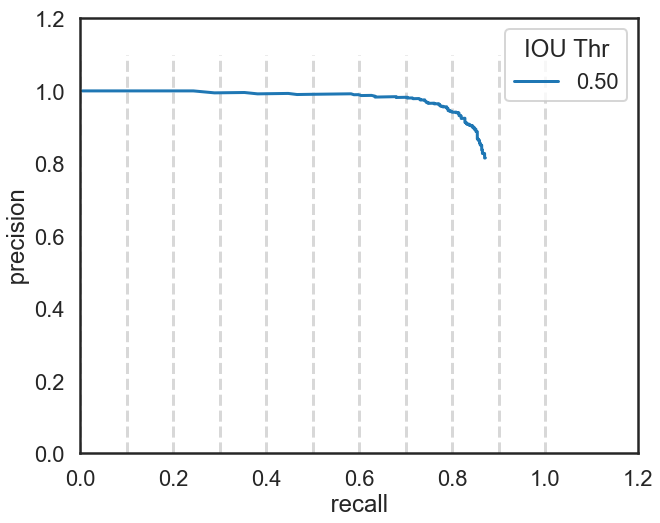

In [8]:
cls = 1

iou_thr = 0.5
start_time = time.time()
data =  cmap.get_avg_precision_at_iou(gt_boxes_class[cls], pr_boxes_class[cls], iou_thr=iou_thr, score_key = 'scores')
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))
# pp.pprint(data)

idx = 0
ax = None
avg_precs = []
iou_thrs = []
avg_precs.append(data['avg_prec'])
iou_thrs.append(iou_thr)
precisions = data['precisions']
recalls    = data['recalls']
print(iou_thrs)
print(avg_precs)
print(' precisions: ', precisions.shape)
print(' recalls   : ', recalls.shape)
ax = cmap.plot_pr_curve(precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

### Display mAP one threshold (across all classes)

Single IoU calculation took 4.3709 secs
avg precision: 0.4631
[0.5]
[0.4631445460351786]
 precisions:  (36,)
 recalls   :  (36,)
map: 46.31
avg precs:  [0.4631]
iou_thrs:   [0.5]

Plotting and calculating mAP takes 4.3865 secs


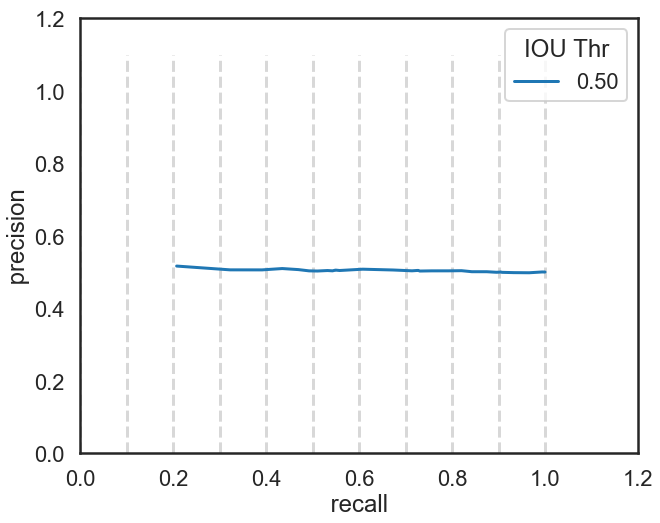

In [36]:
cls = 1

iou_thr = 0.5
start_time = time.time()
data =  cmap.get_avg_precision_at_iou(gt_boxes, pr_boxes, iou_thr=iou_thr, score_key = 'scores')
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))
# pp.pprint(data)

idx = 0
ax = None
avg_precs = []
iou_thrs = []
avg_precs.append(data['avg_prec'])
iou_thrs.append(iou_thr)
precisions = data['precisions']
recalls    = data['recalls']
print(iou_thrs)
print(avg_precs)
print(' precisions: ', precisions.shape)
print(' recalls   : ', recalls.shape)
ax = cmap.plot_pr_curve(precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

## Display distribution of various scores 

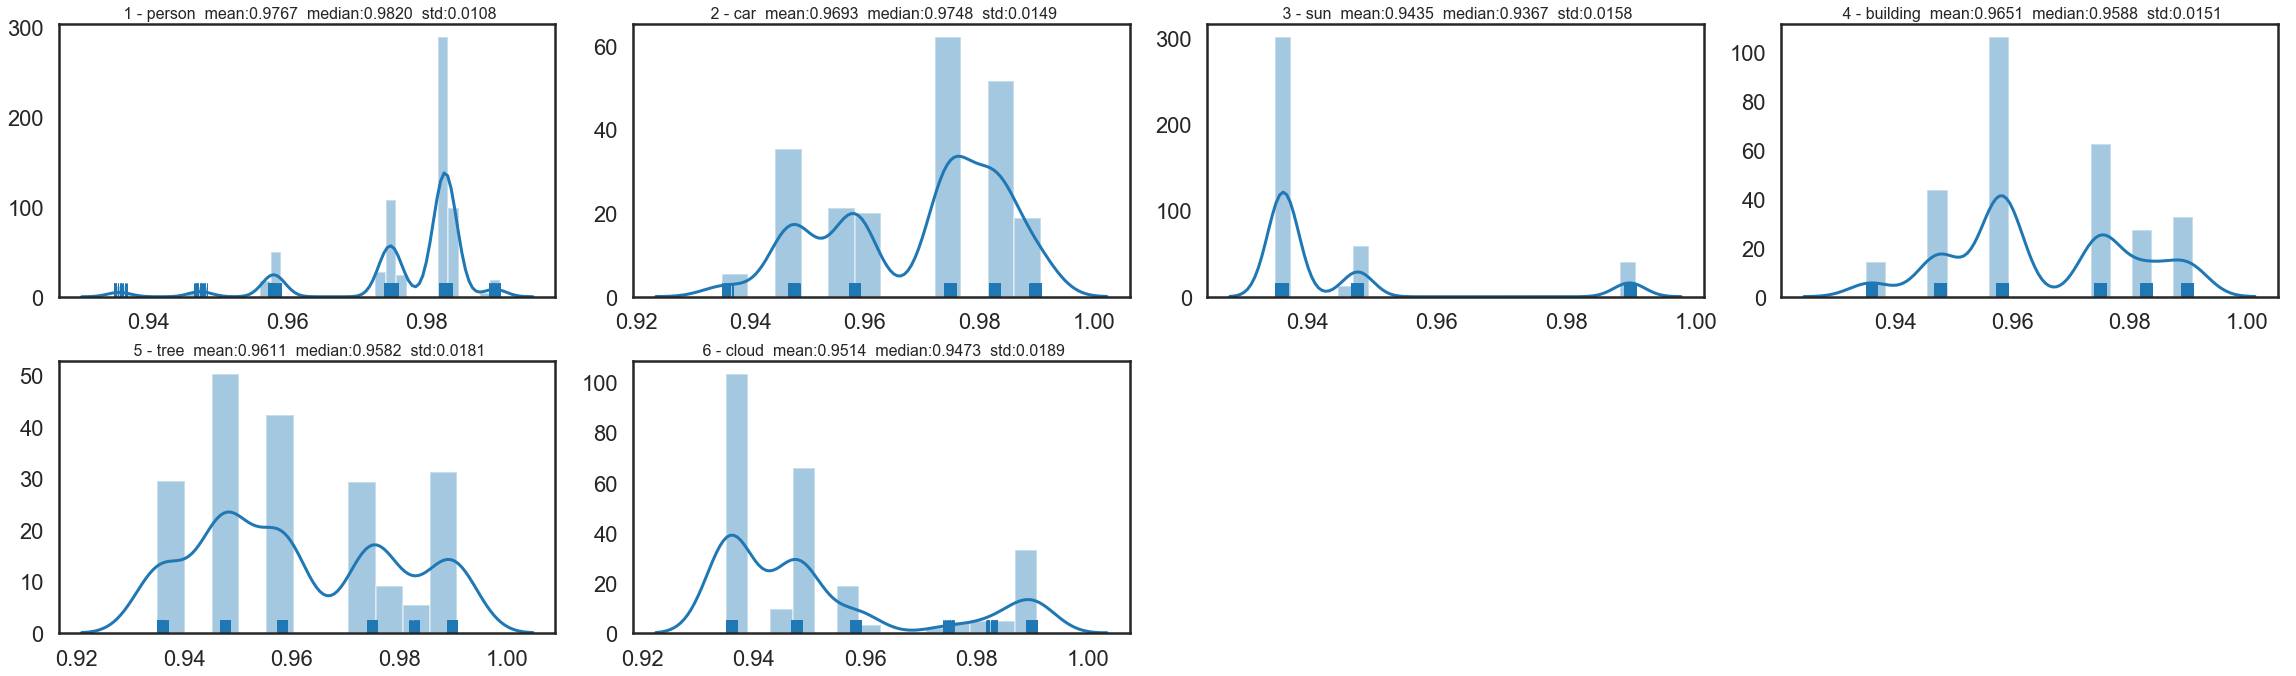

In [12]:
cmap.plot_score_distribution(cls_info, 'mrcnn_score_orig')

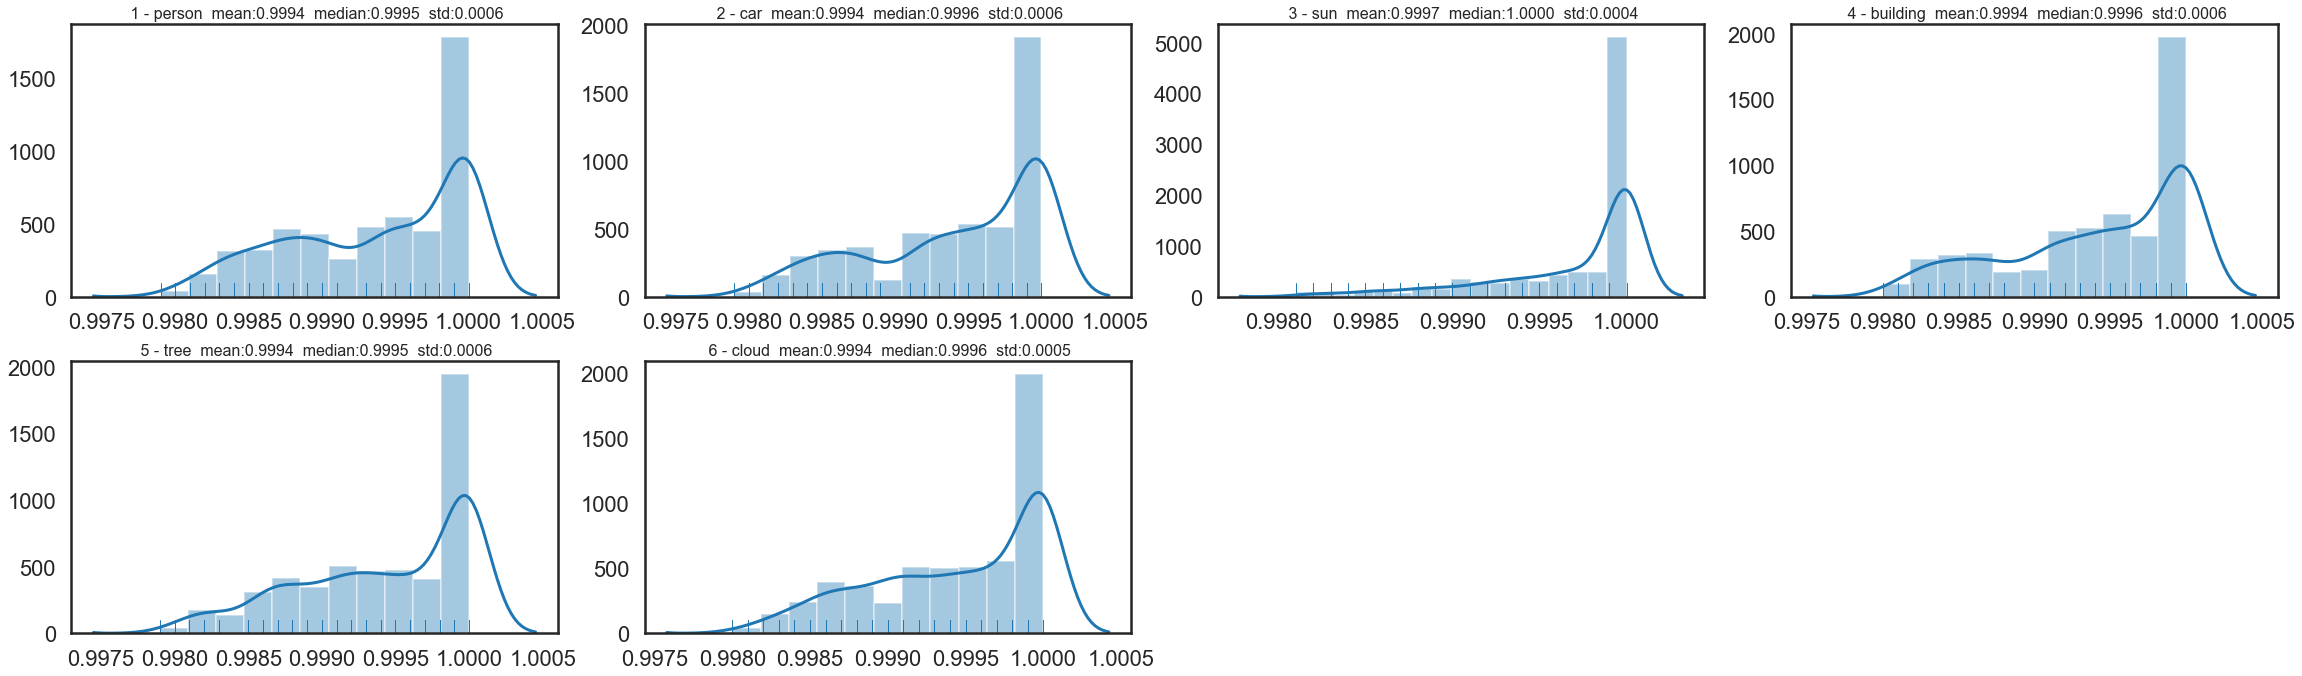

In [10]:
cmap.plot_score_distribution(cls_info, 'mrcnn_score_norm')

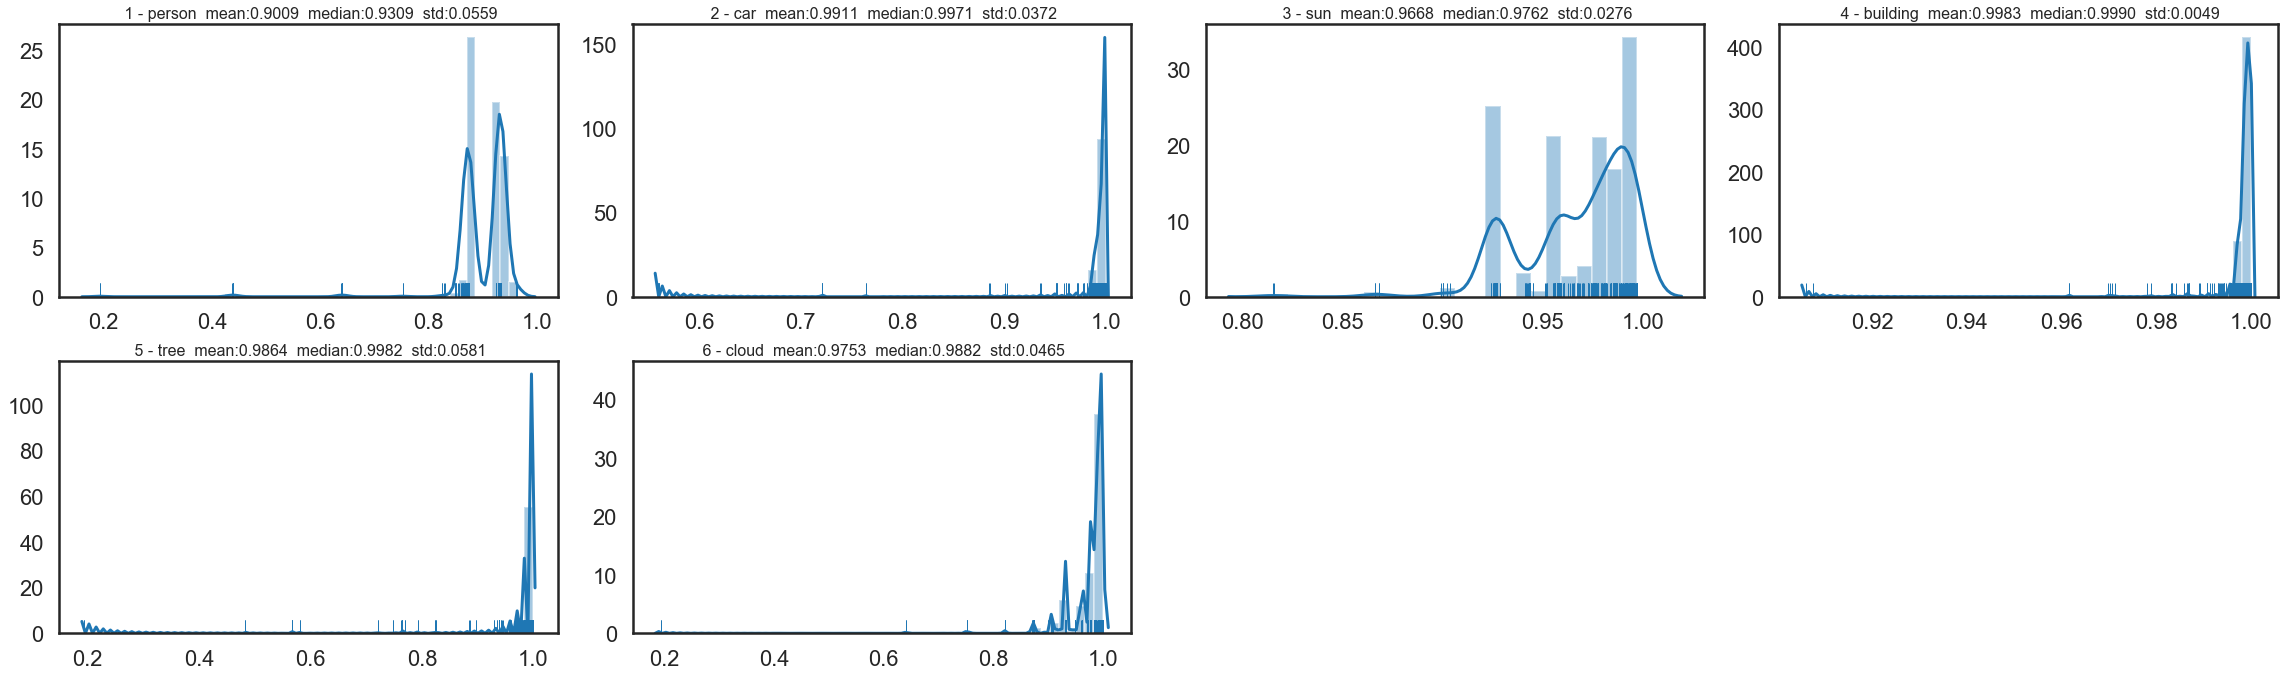

In [11]:
cmap.plot_score_distribution(cls_info, 'mrcnn_score_0')

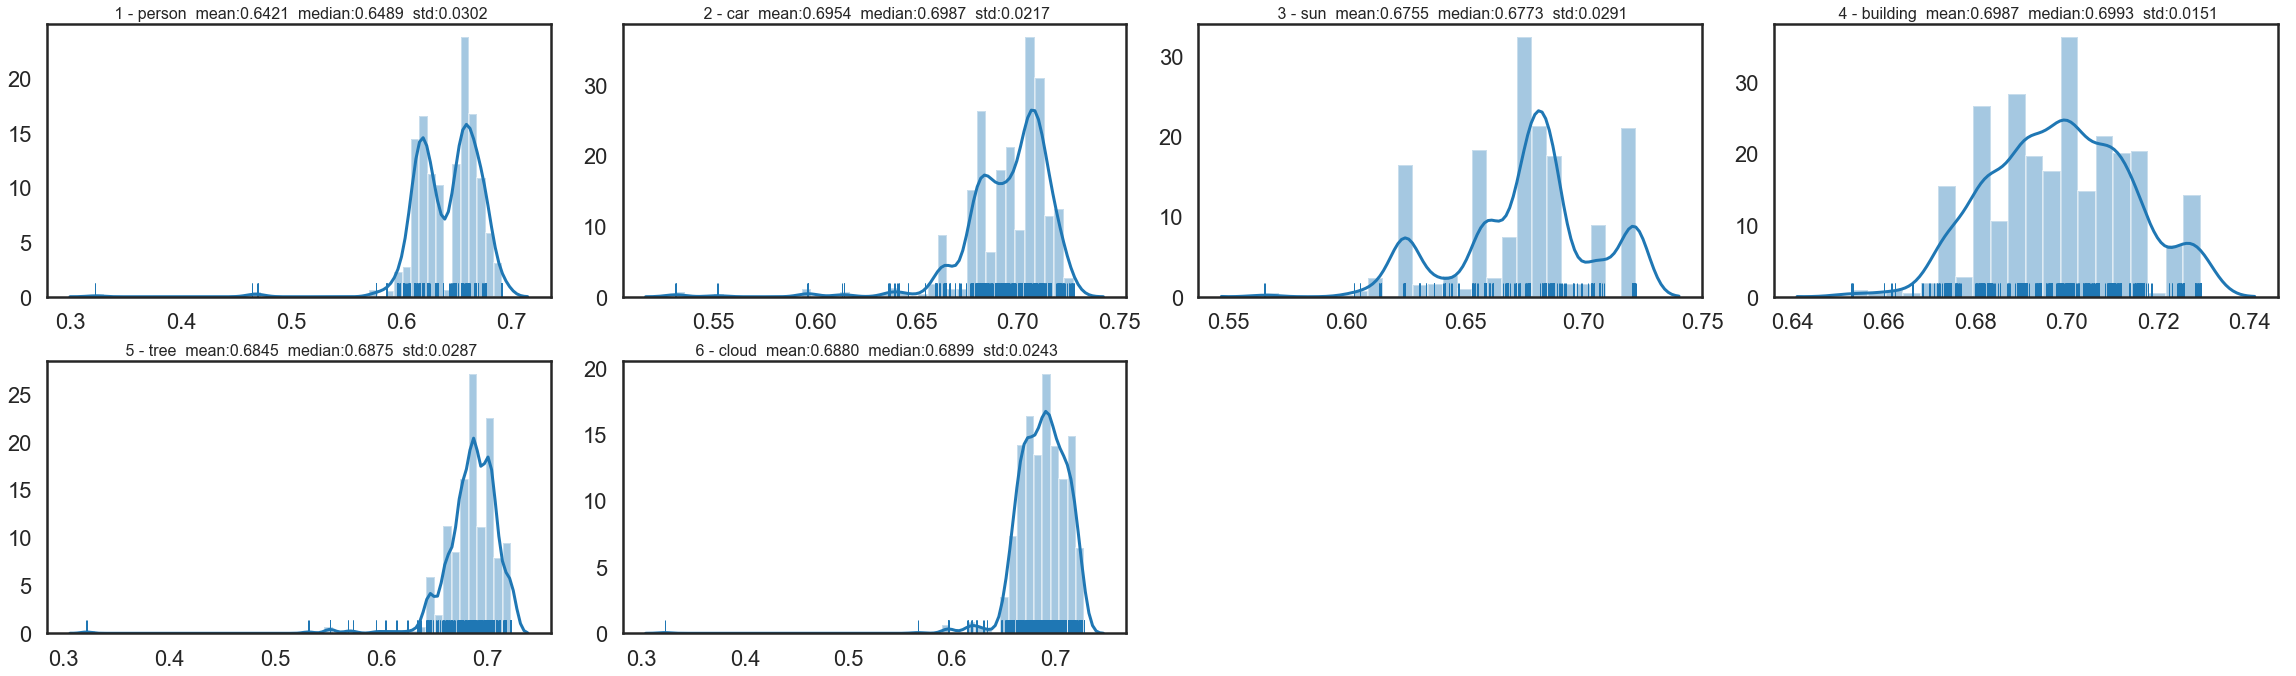

In [13]:
cmap.plot_score_distribution(cls_info, 'mrcnn_score_1')

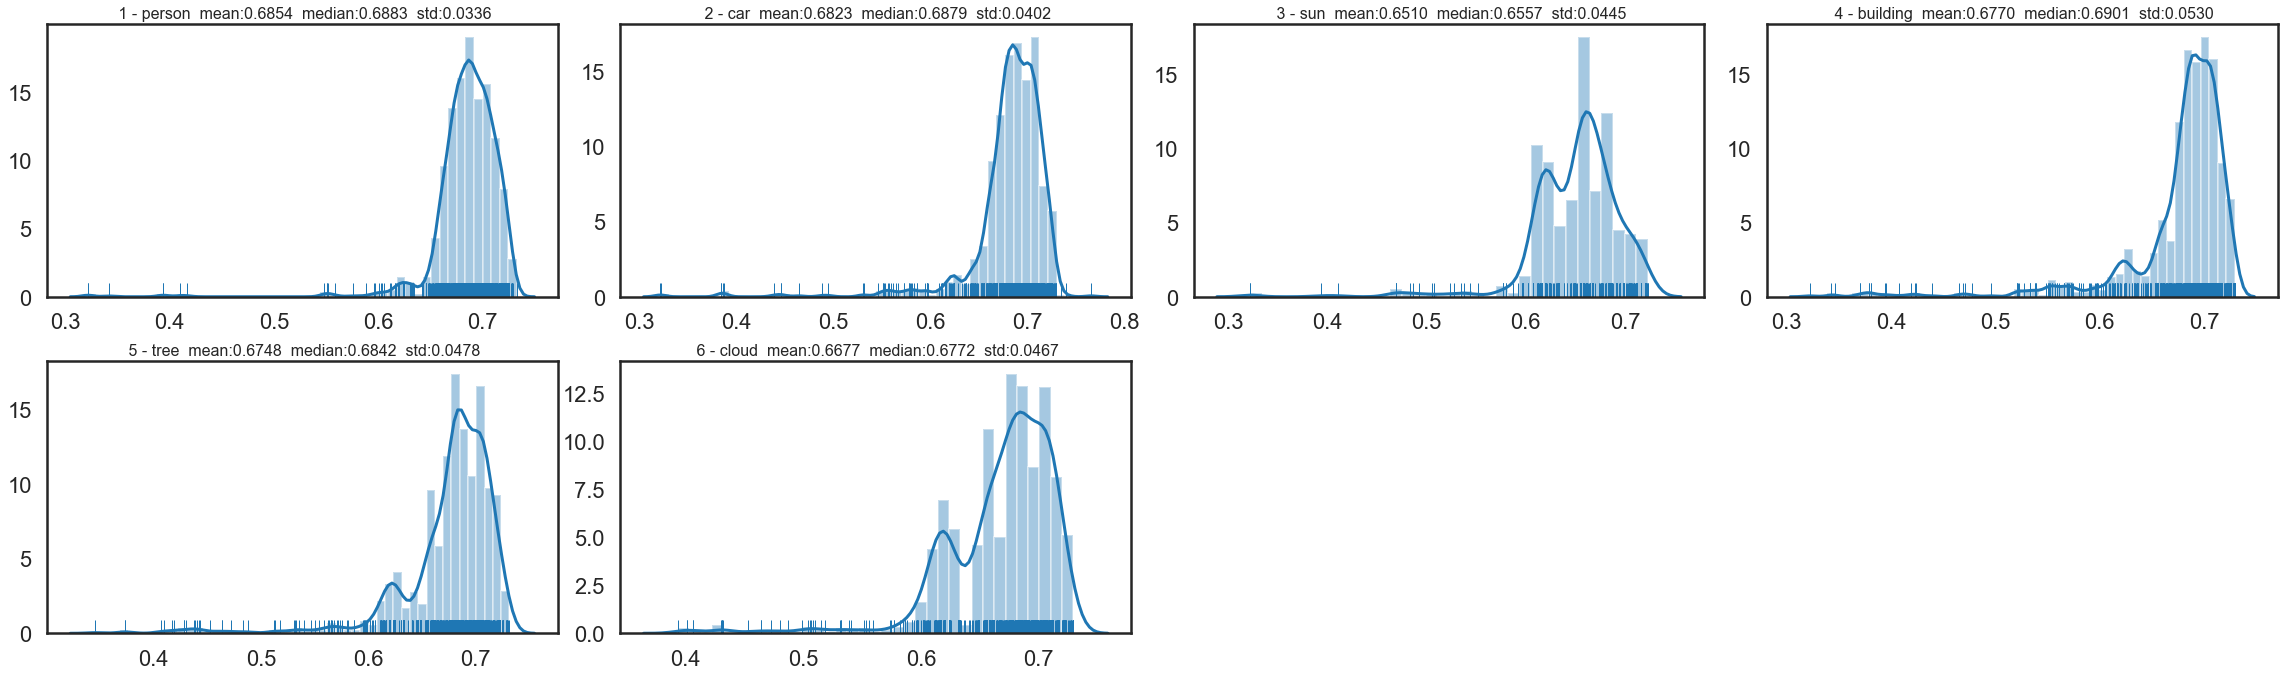

In [15]:
cmap.plot_score_distribution(cls_info, 'mrcnn_score_2')

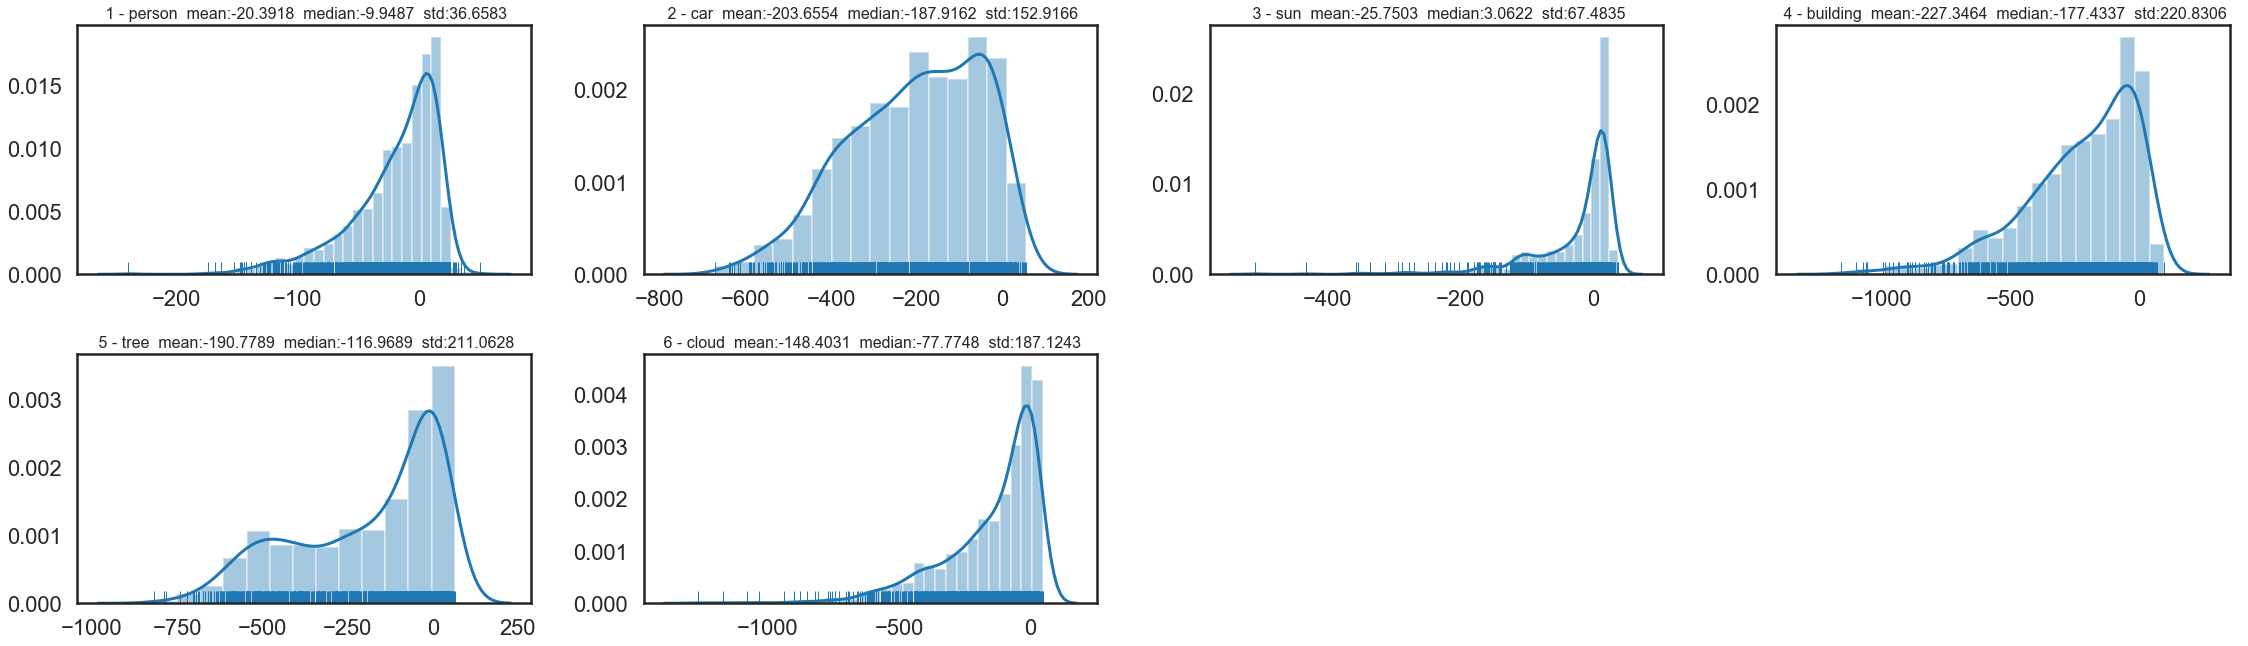

In [44]:
cmap.plot_score_distribution(cls_info, 'fcn_score_0')

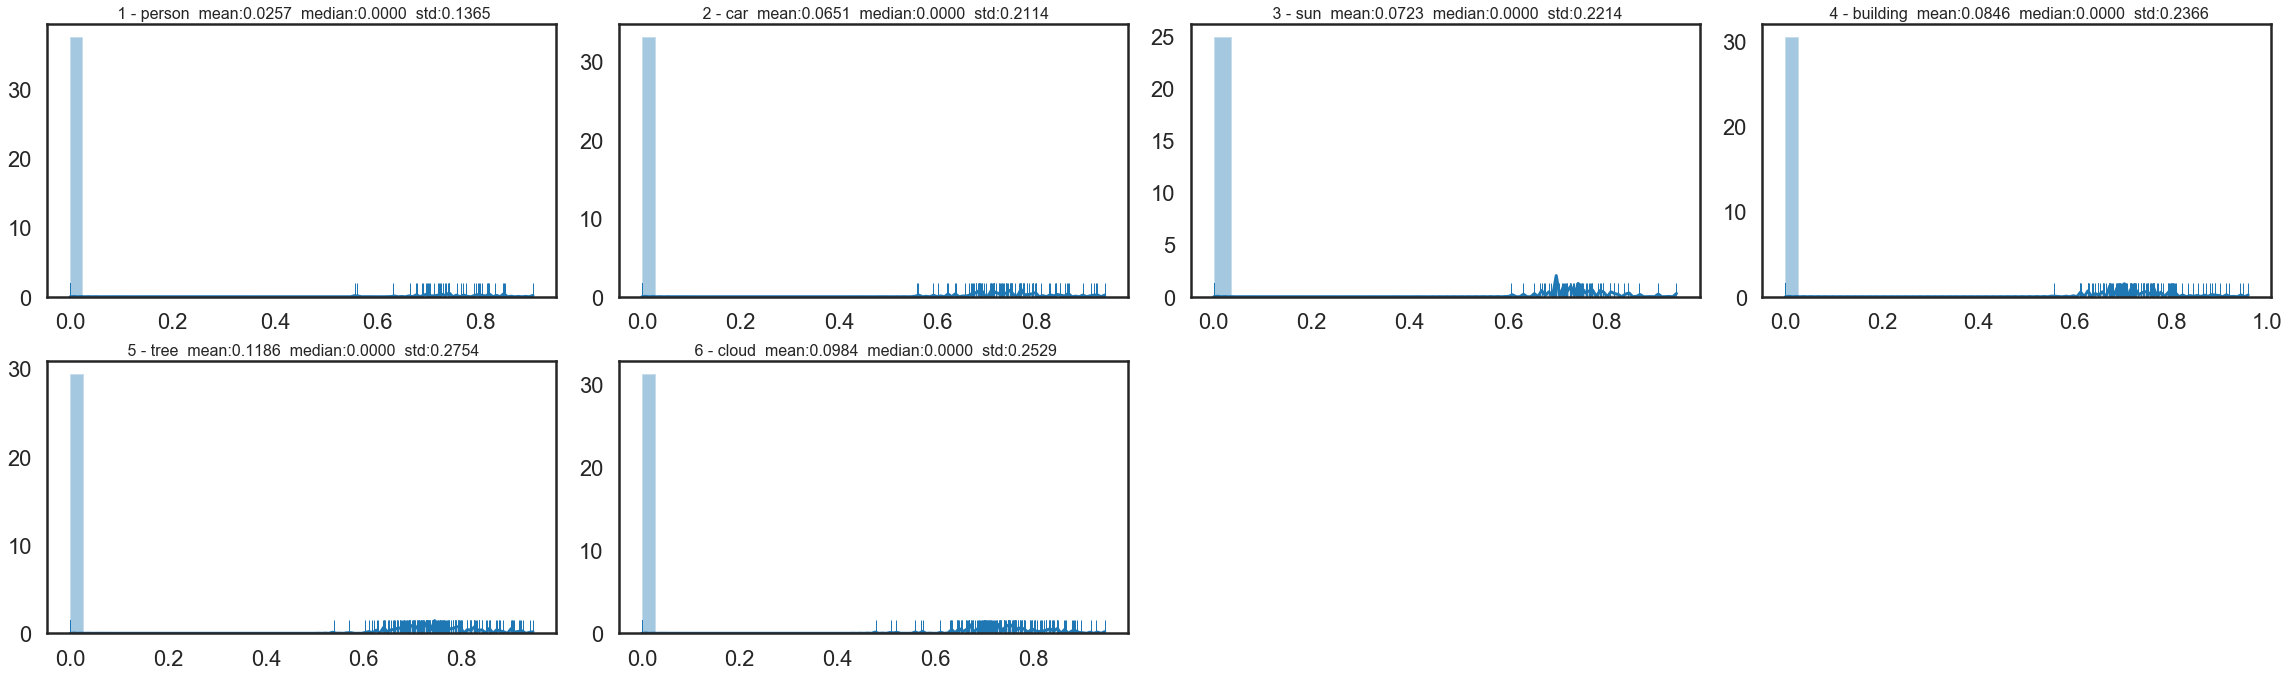

In [13]:
cmap.plot_score_distribution(cls_info, 'fcn_score_1')

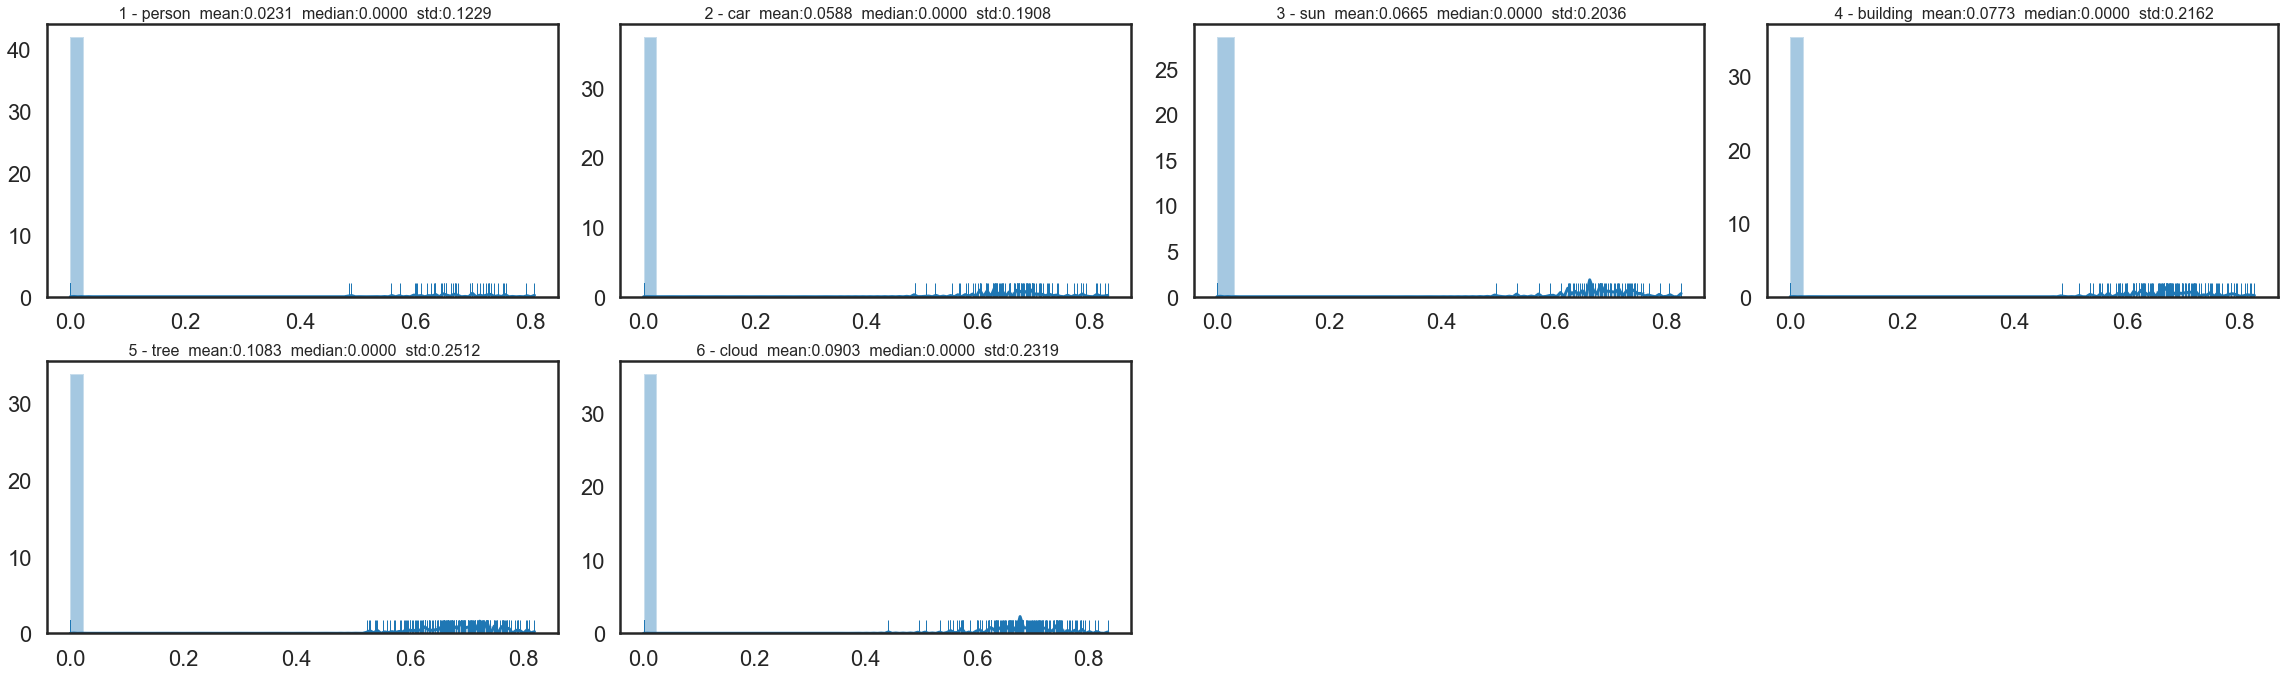

In [14]:
cmap.plot_score_distribution(cls_info, 'fcn_score_2')

## Barchart - AP vs. IoU Threshold for various scores 

 Num disp classes 1  Columns:  1  Rows:  1


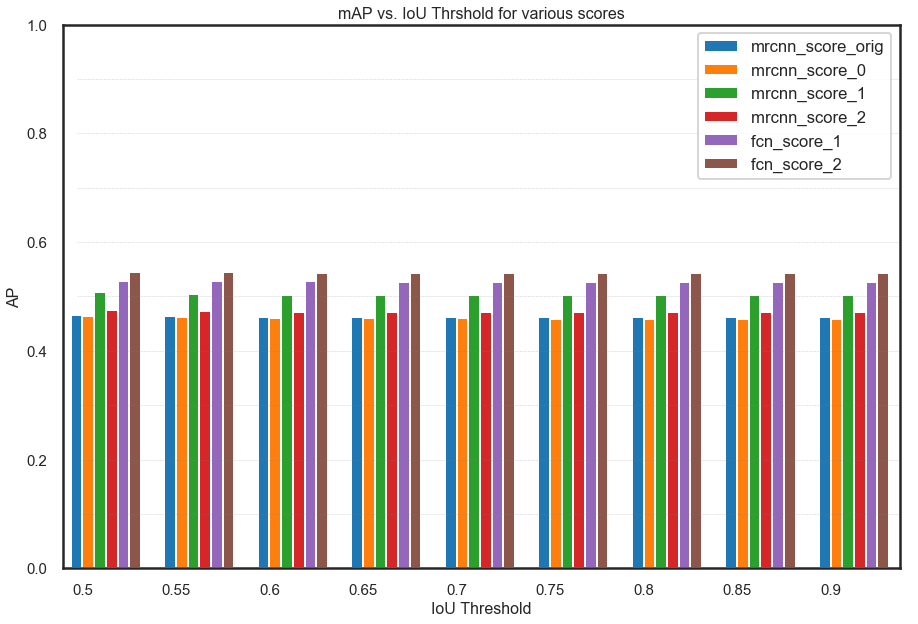


                                                  AP @ IoU Thresholds for computed scores                                                   

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Score -                           0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
mrcnn_score_orig                  0.4667     0.4645     0.4631     0.4627     0.4623     0.4620     0.4620     0.4618     0.4617     %46.30 
mrcnn_score_0                     0.4633     0.4618     0.4607     0.4605     0.4596     0.4595     0.4595     0.4595     0.4595     %46.04 
mrcnn_score_1                     0.5082     0.5048     0.5037     0.5035     0.5029     0.5027     0.5027     0.5027     0.5025     %50.38 
mrcnn_score_2

In [109]:
# disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2',  'fcn_score_1', 'fcn_score_2']
disp_ious    = [0.5 , 0.75, 0.9]
cmap.plot_mAP_vs_IoUs_BarChart(all_data, disp_scores, class_ids= [0])# , disp_ious)

## Barchart mAP vs. Class for different scores `plot_mAP_vs_class()`

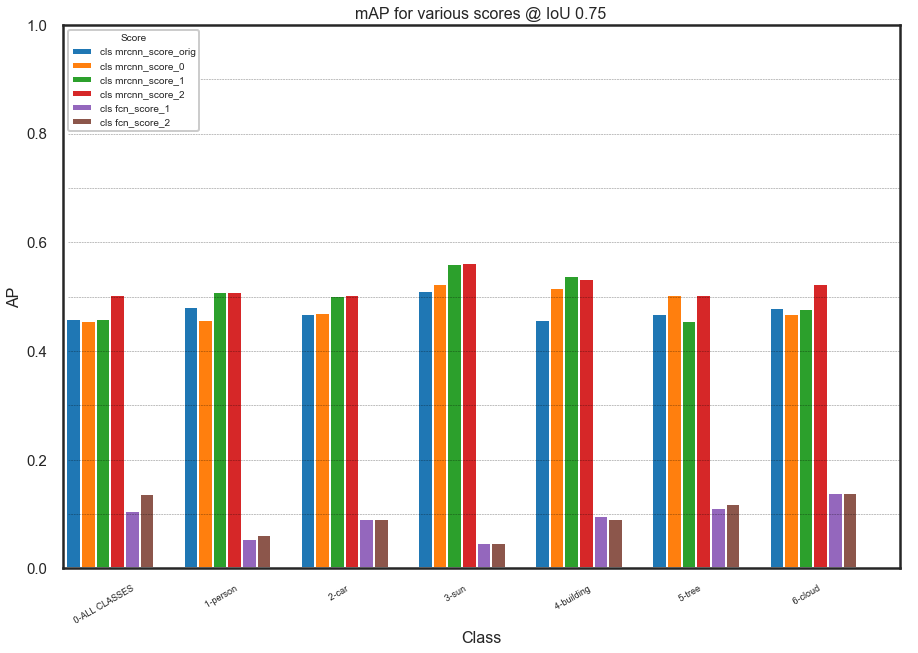


                                                AP @ IoU 0.75 Thresholds for Computed Scores                                                

-----------------------------------------------------------------  scores  -----------------------------------------------------------------
Id - ClassName           mrcnn_score_orig     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.4813            0.4568            0.5093            0.5090            0.0545            0.0606 
 2 - car                           0.4685            0.4704            0.5007            0.5030            0.0909            0.0909 
 3 - sun                           0.5096            0.5235            0.5608            0.5610            0.0462            0.0471 
 4 - building                      0.4576   

In [16]:
# disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_1', 'fcn_score_2']
disp_ious    = [0.5 , 0.75, 0.9]
cmap.plot_mAP_vs_class_BarChart(all_data, disp_scores, class_names = class_names, iou = 0.75)# , disp_ious)

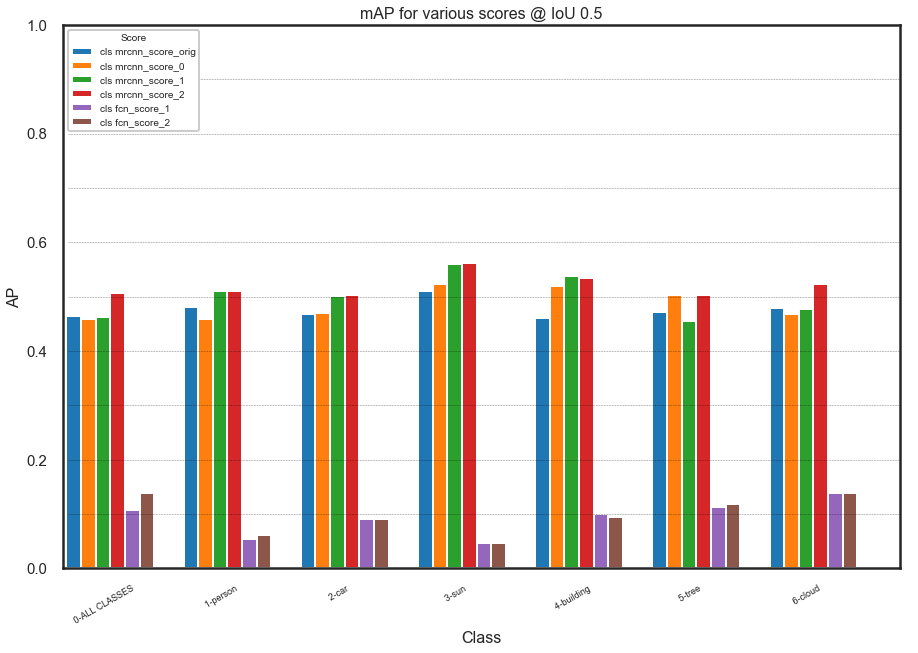


                                                AP @ IoU 0.50 Thresholds for Computed Scores                                                

-----------------------------------------------------------------  scores  -----------------------------------------------------------------
Id - ClassName           mrcnn_score_orig     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.4815            0.4593            0.5101            0.5096            0.0545            0.0606 
 2 - car                           0.4685            0.4704            0.5007            0.5030            0.0909            0.0909 
 3 - sun                           0.5096            0.5235            0.5608            0.5610            0.0462            0.0471 
 4 - building                      0.4601   

In [17]:
# disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_1', 'fcn_score_2']
disp_ious    = [0.5 , 0.75, 0.9]
cmap.plot_mAP_vs_class_BarChart(all_data, disp_scores, class_names = class_names, iou = 0.5)# , disp_ious)

## Plot combined mAP for different IoU thresholds for each score
(one type of score, e.g. 'scores' - all classes combined)

### `mrcnn_score_orig`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_orig                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  ALL CLASSES                     46.39%     46.10%     45.90%     45.85%     45.80%     45.75%     45.74%     45.72%     45.71%      %45.88 
--------------------------------------------------------------------------------------------------------------------------------------------


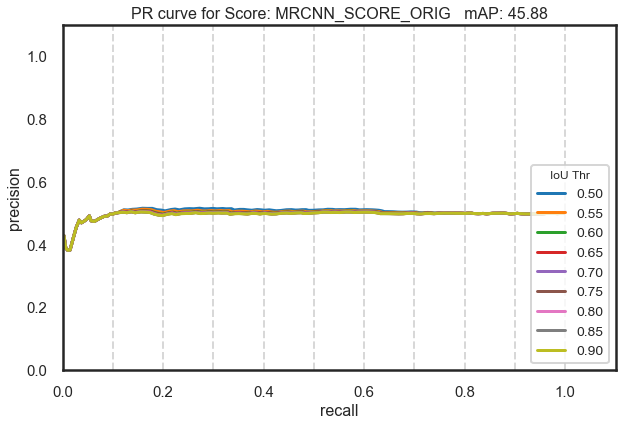

In [90]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_orig', class_ids = [0], class_names = class_names, columns = 3)

### `mrcnn_score_0`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_0                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.4592     0.4571     0.4559     0.4555     0.4550     0.4548     0.4547     0.4547     0.4546      %45.57 



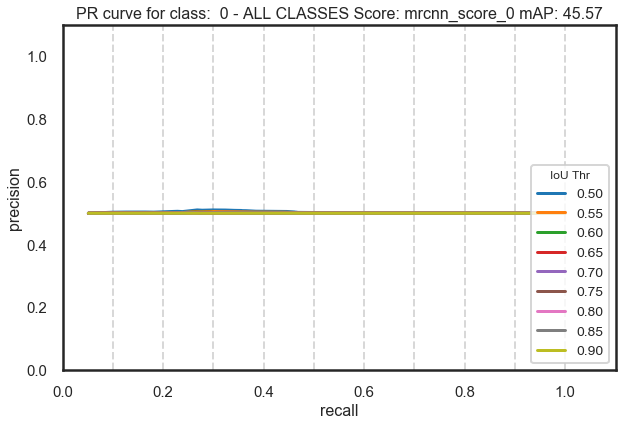

In [19]:
# plot_mAP_by_score(all_data, 'scores' )

cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_0' , class_ids = 0 , class_names = class_names, columns = 3)

### `mrcnn_score_1`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_1                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.4612     0.4581     0.4569     0.4567     0.4560     0.4552     0.4551     0.4551     0.4545      %45.65 



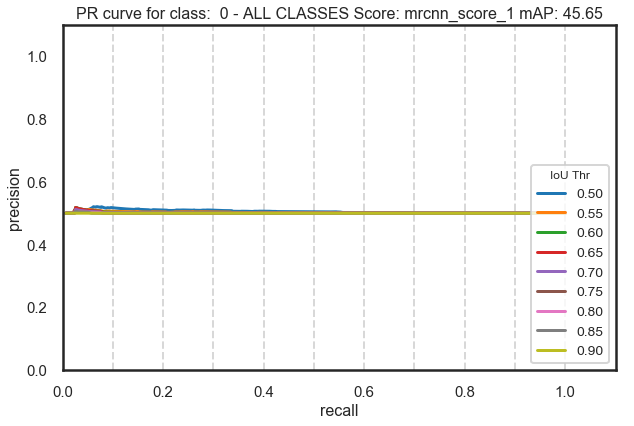

In [20]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_1' , class_ids = 0 ,class_names = class_names, columns = 3)

### `mrcnn_score_2`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_2                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.4740     0.4714     0.4705     0.4703     0.4701     0.4699     0.4699     0.4699     0.4699      %47.07 



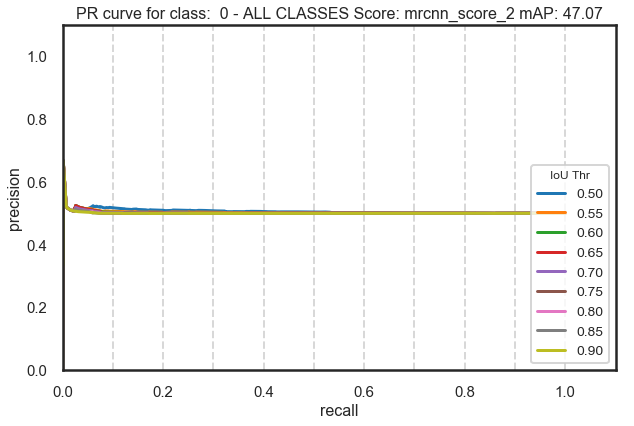

In [21]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_2' , class_ids = 0 ,class_names = class_names, columns = 3)

### `mrcnn_score_norm`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_norm                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.4572     0.4563     0.4555     0.4552     0.4547     0.4547     0.4547     0.4547     0.4545      %45.53 



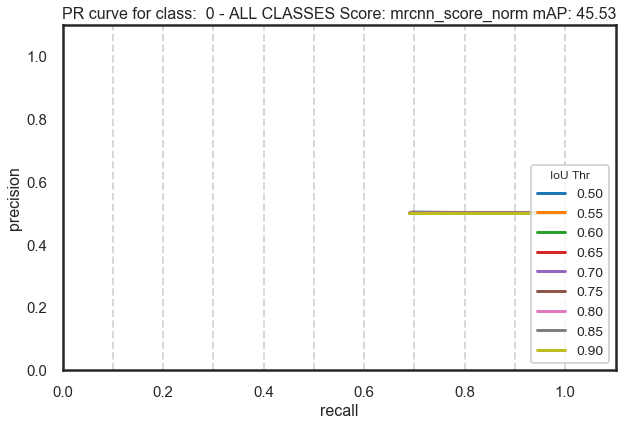

In [22]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_norm' , class_ids = 0 ,class_names = class_names, columns = 3)

### `fcn_score_0`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_0                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.4840     0.4835     0.4832     0.4831     0.4829     0.4829     0.4827     0.4827     0.4826      %48.31 



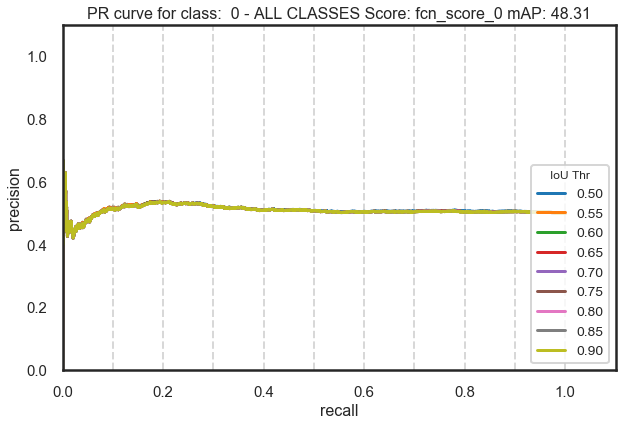

In [23]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_0' , class_ids = 0 , class_names = class_names,columns = 3)

### `fcn_score_1`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_1                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  ALL CLASSES                     53.49%     53.35%     53.26%     53.24%     53.17%     53.15%     53.15%     53.13%     53.12%      %53.23 
--------------------------------------------------------------------------------------------------------------------------------------------


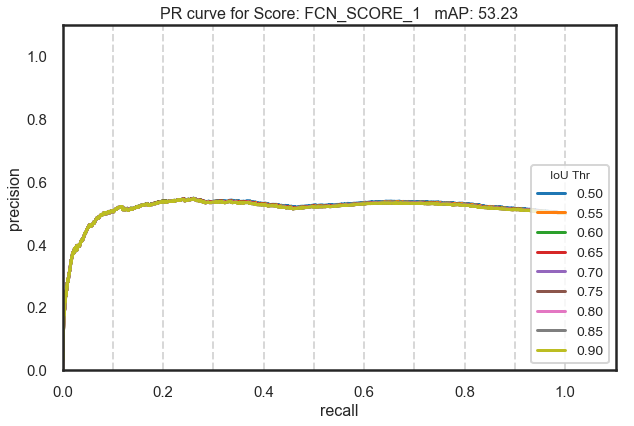

In [22]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_1' , class_ids = 0 , class_names = class_names,columns = 3)

### `fcn_score_2`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_2                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  ALL CLASSES                     58.85%     58.75%     58.71%     58.70%     58.64%     58.64%     58.63%     58.61%     58.61%      %58.68 
--------------------------------------------------------------------------------------------------------------------------------------------


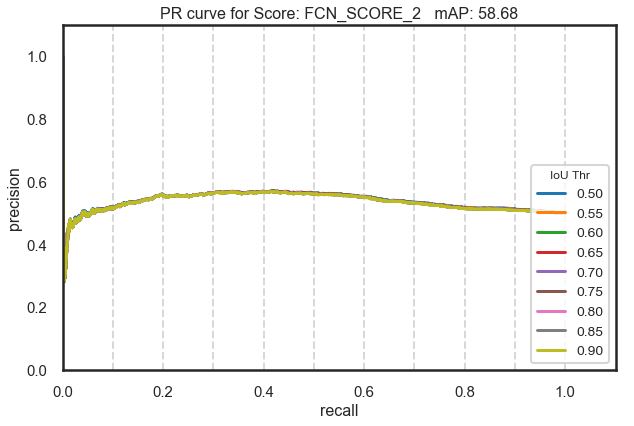

In [89]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_2' , class_ids = 0 , class_names = class_names,columns = 3)

## Plot combined mAP info for different scores (at a given IoU threshold, all classes combined)


                                                               AP @ IoU 0.50 Thresholds for Computed Scores                                                               

--------------------------------------------------------------------------------  scores  --------------------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig  mrcnn_score_norm     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_0       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ALL CLASSES                        46.39%            45.66%            46.44%            46.26%            47.52%            55.73%            53.47%            58.85%
-----------------------------------------------------------------------------------------------------------------------------------------------------

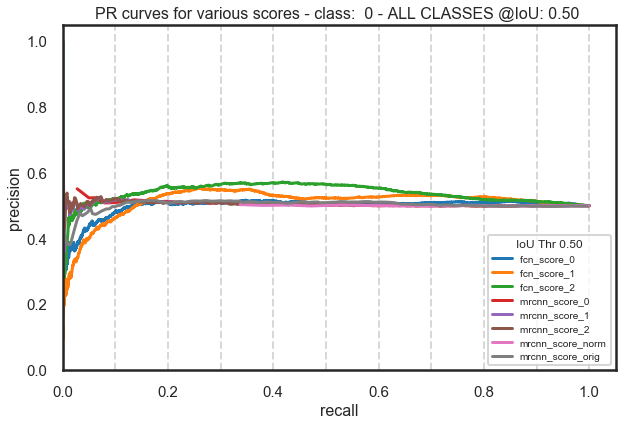

In [93]:
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2' ,'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = [0], class_names = class_names,iou = 0.50)


                                                               AP @ IoU 0.85 Thresholds for Computed Scores                                                               

--------------------------------------------------------------------------------  scores  --------------------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig  mrcnn_score_norm     mrcnn_score_0     mrcnn_score_1       fcn_score_0       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ALL CLASSES                        45.72%            45.48%            46.09%            45.82%            55.59%            53.17%            58.61%
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------


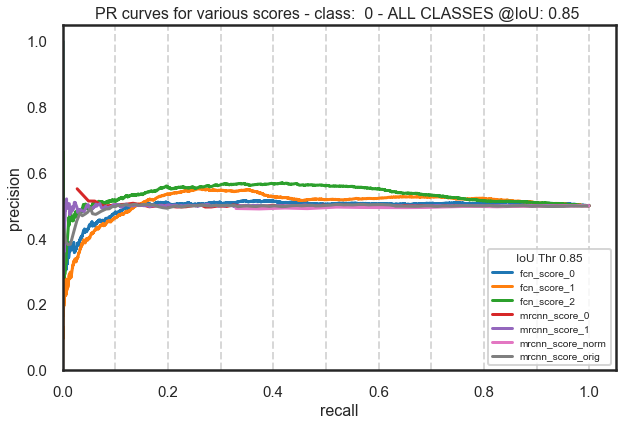

In [92]:
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1',  'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = [0], class_names = class_names, iou = 0.85)


                                                               AP @ IoU 0.50 Thresholds for Computed Scores                                                               

--------------------------------------------------------------------------------  scores  --------------------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig  mrcnn_score_norm     mrcnn_score_0     mrcnn_score_1       fcn_score_0       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.4553            0.4554            0.4562            0.4562            0.6297            0.7372            0.7241 
 2 - car                           0.4545            0.4545            0.4550            0.4545            0.5873            0.6327            0.6568 
 3 - sun                         

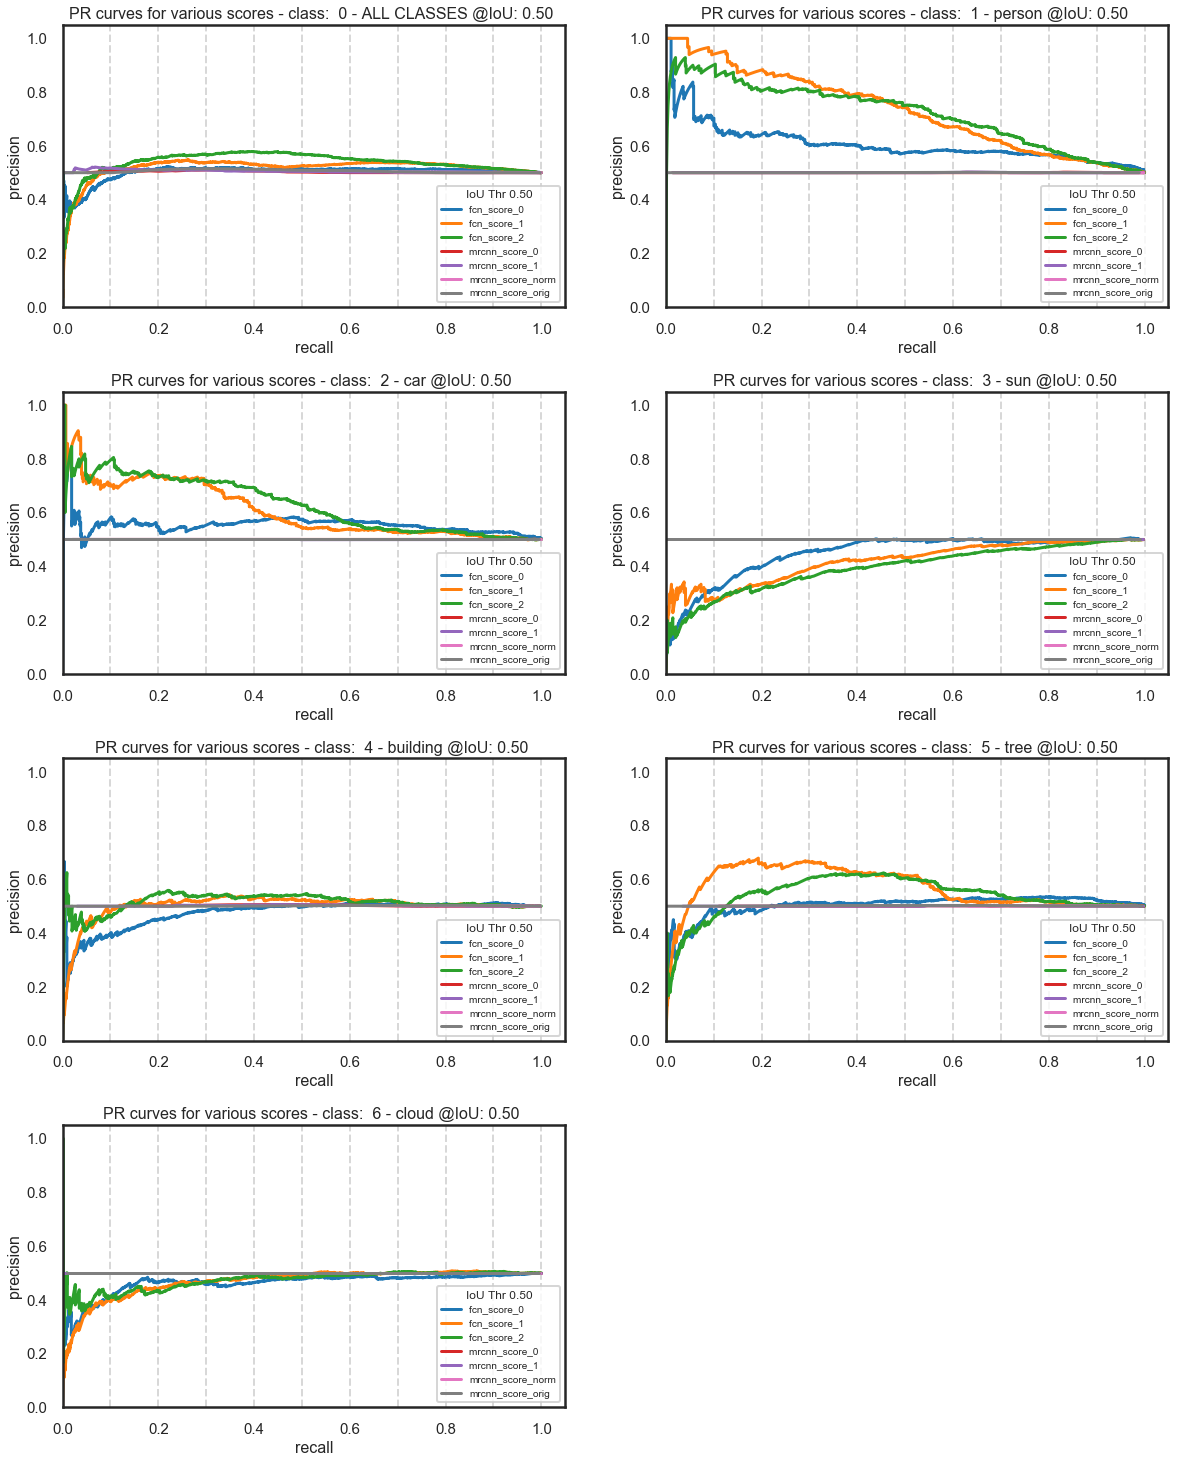

In [26]:
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1',  'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores , class_names = class_names, iou = 0.50)


## Indvidual classes - Plot mAP info for  at different thresholds (one type of score, e.g. 'scores')

### Plot mAP for `mrcnn_score_orig` for different IoU thresholds

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_orig                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.9054     0.9023     0.8921     0.7962     0.7721     0.6545     0.5047     0.2586     0.0795      %64.06 
  1 - person                      0.8084     0.7965     0.6878     0.5307     0.3618     0.1987     0.0708     0.0283     0.0069      %38.78 
  2 - car                         0.9082     0.9066     0.9024     0.8885     0.785

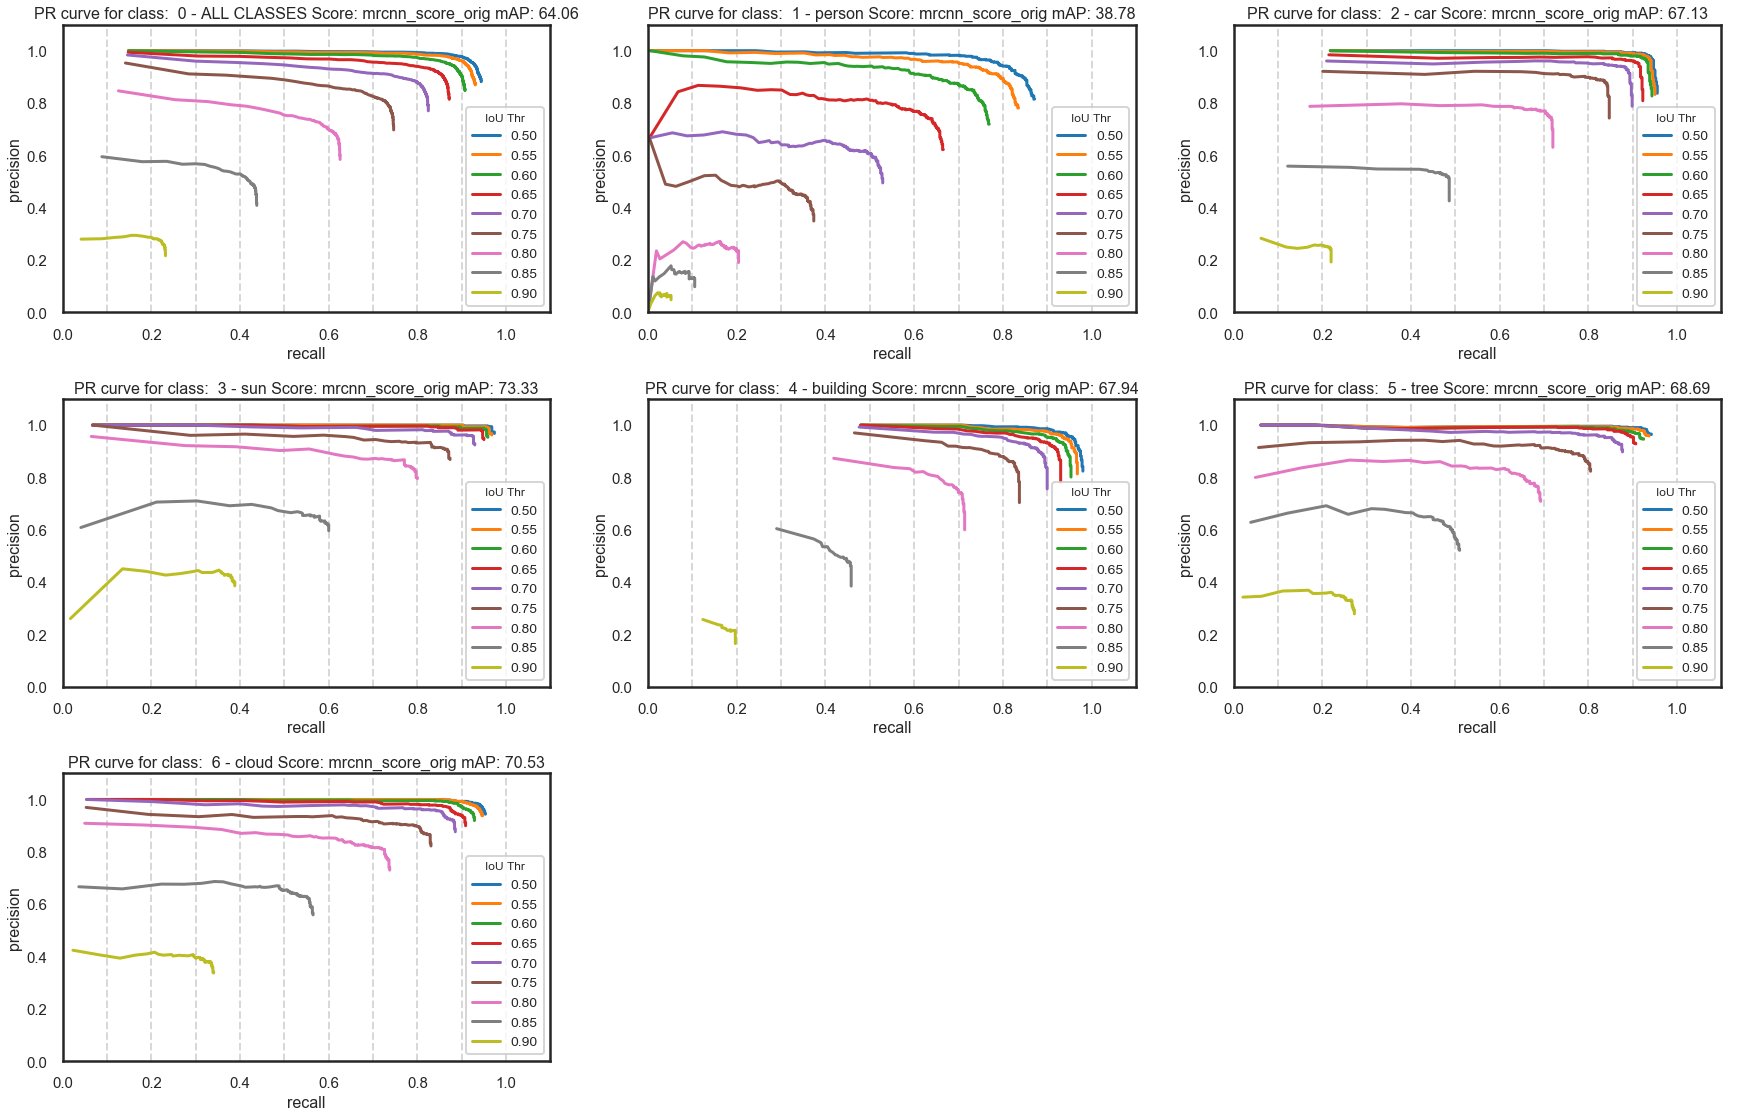

In [199]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_orig', class_names = class_names )

### Plot mAP for `mrcnn_score_norm` for different IoU thresholds


                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_norm                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.7777     0.7569     0.6442     0.4946     0.3545     0.1565     0.0654     0.0264     0.0050      %36.46 
  2 - car                         0.8921     0.8852     0.8817     0.8759     0.7737     0.7111     0.4763     0.2429     0.0719      %64.56 
  3 - sun                         0.9062     0.9062     0.8977     0.8919     0.8634     0.8205     0.5786     0.3862     0.1338      %70.94 
  4 - buil

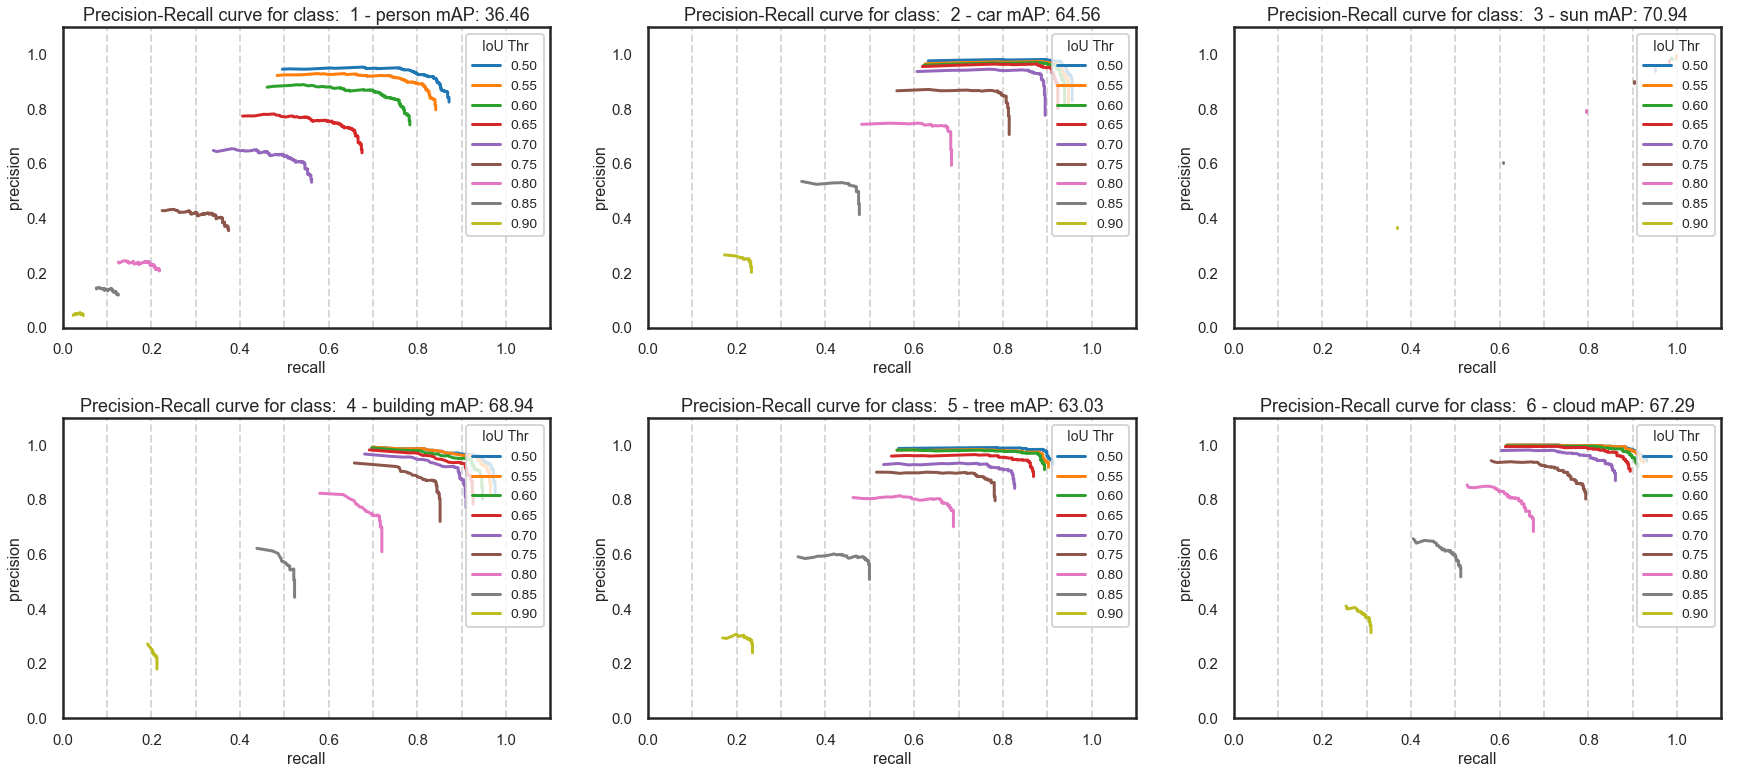

In [163]:
plot_mAP_by_IOU(all_data, 'mrcnn_score_norm')

### Plot mAP for `mrcnn_score_0` for different IoU thresholds

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_0                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.8912     0.8870     0.8770     0.7862     0.7696     0.6493     0.5006     0.2566     0.0779      %63.28 
  1 - person                      0.7774     0.7507     0.6410     0.5154     0.3580     0.1734     0.0717     0.0244     0.0061      %36.87 
  2 - car                         0.8851     0.8819     0.8780     0.8694     0.766

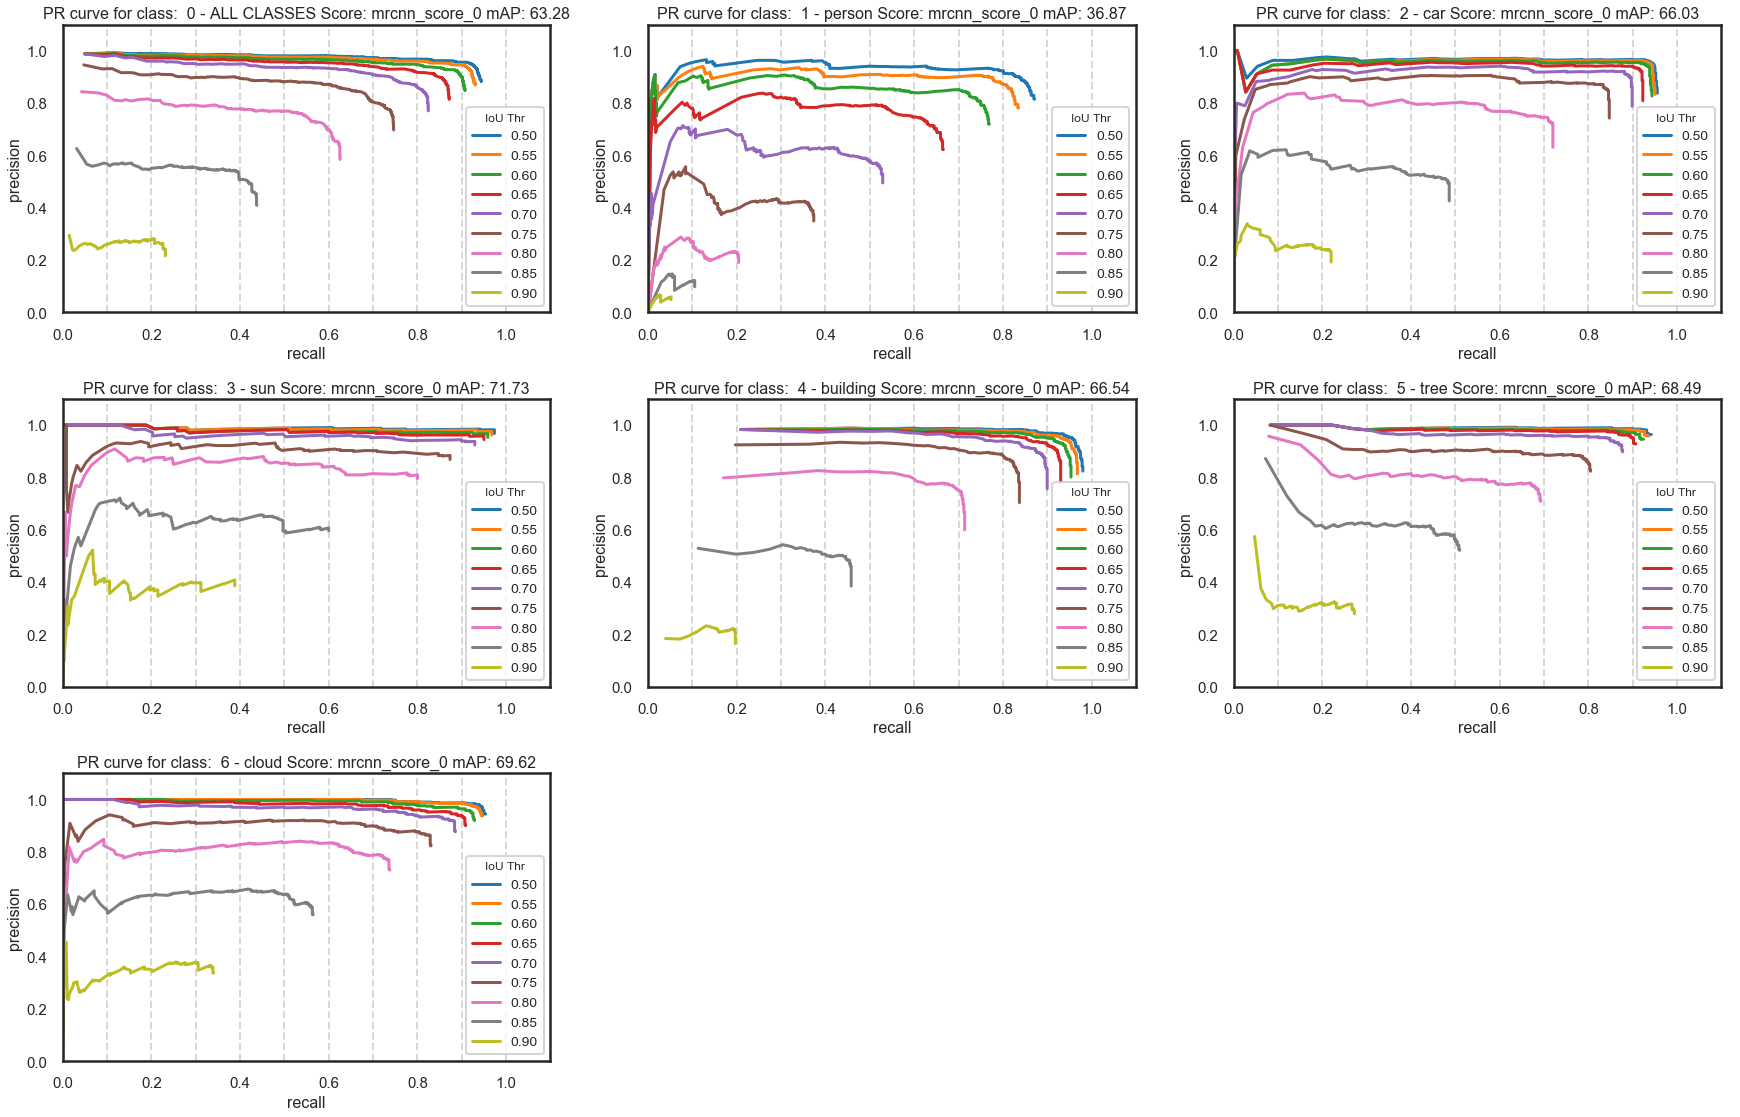

In [201]:
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_0', class_names = class_names )

### Plot mAP for `mrcnn_score_1` for different IoU thresholds

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_1                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.4563     0.4563     0.4555     0.4545     0.4545     0.4545     0.4545     0.4545     0.4545      %45.50 
  2 - car                         0.4545     0.4545     0.4545     0.4545     0.4545     0.4545     0.4545     0.4545     0.4545      %45.45 
  3 - sun                         0.4545     0.4545     0.4545     0.4545     0.454

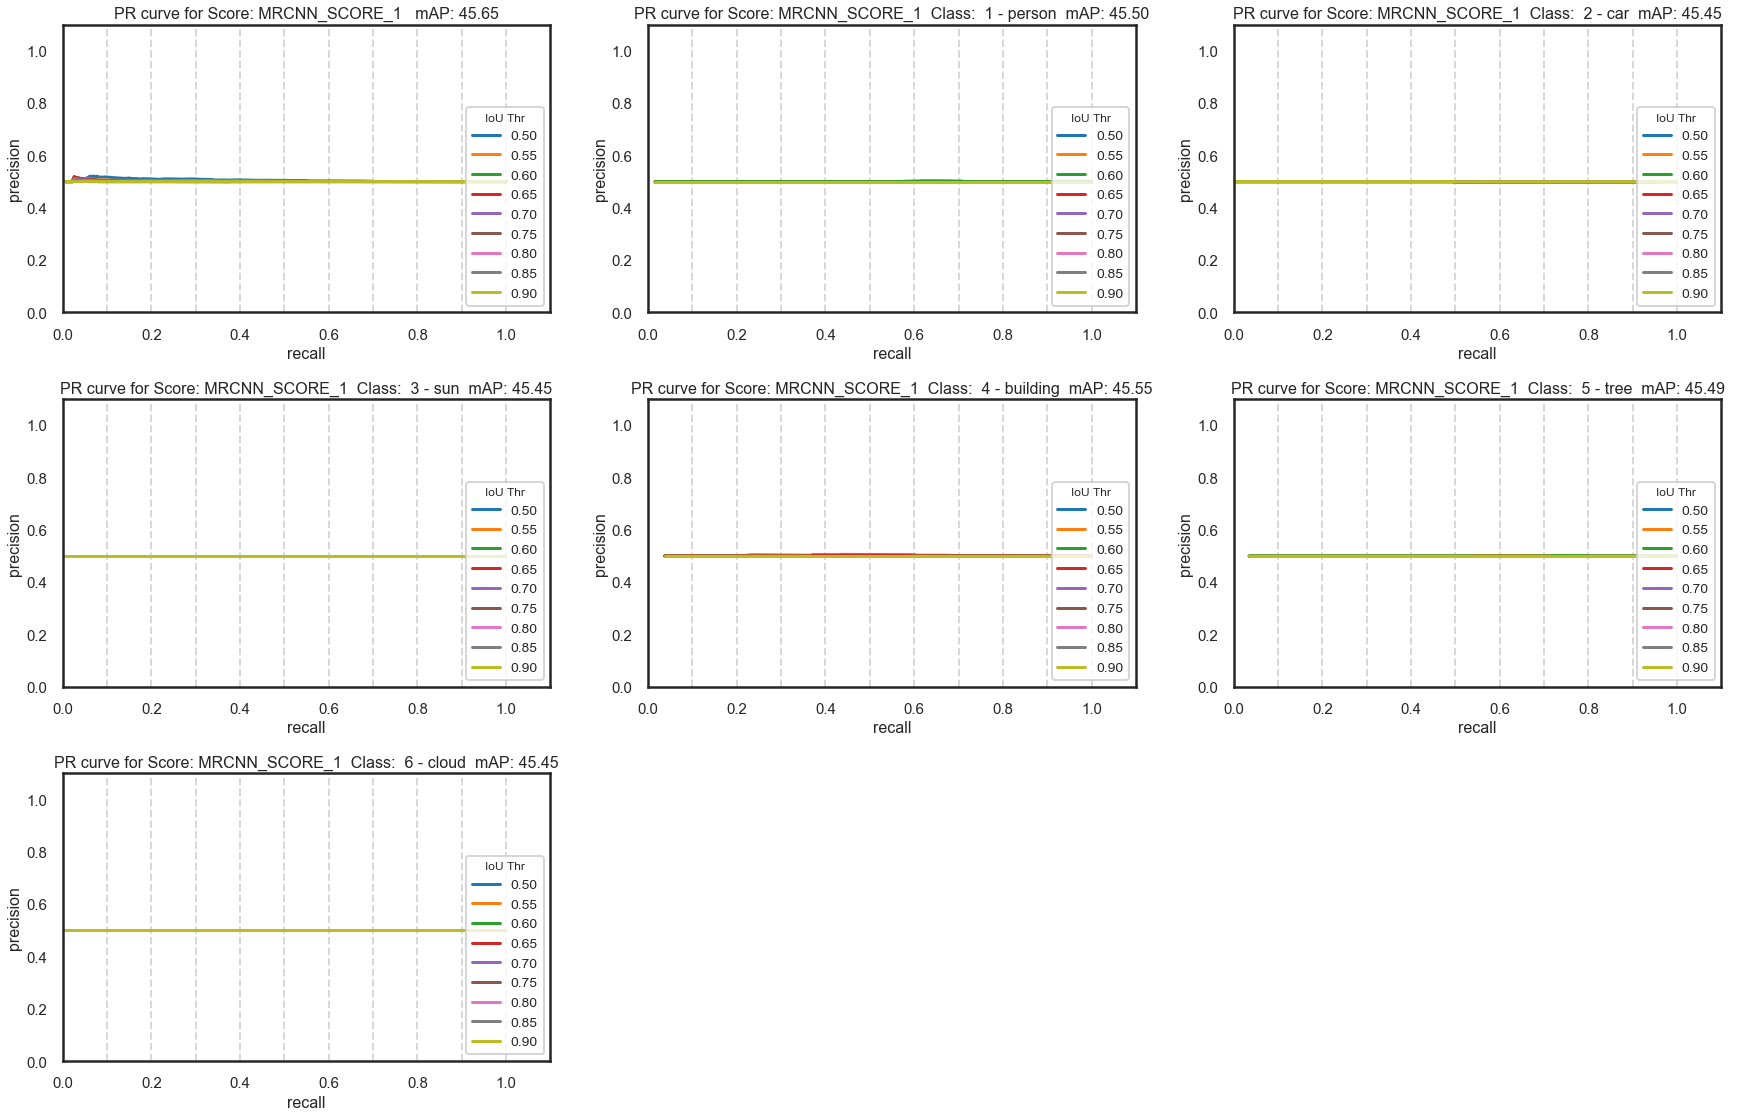

In [145]:
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_1', class_names = class_names )

### Plot mAP for `mrcnn_score_2` for different IoU thresholds

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_2                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.4560     0.4560     0.4560     0.4560     0.4560     0.4560     0.4560     0.4560     0.4560      %45.60 
  2 - car                         0.4549     0.4549     0.4549     0.4549     0.4549     0.4549     0.4549     0.4549     0.4549      %45.49 
  3 - sun                         0.4545     0.4545     0.4545     0.4545     0.454

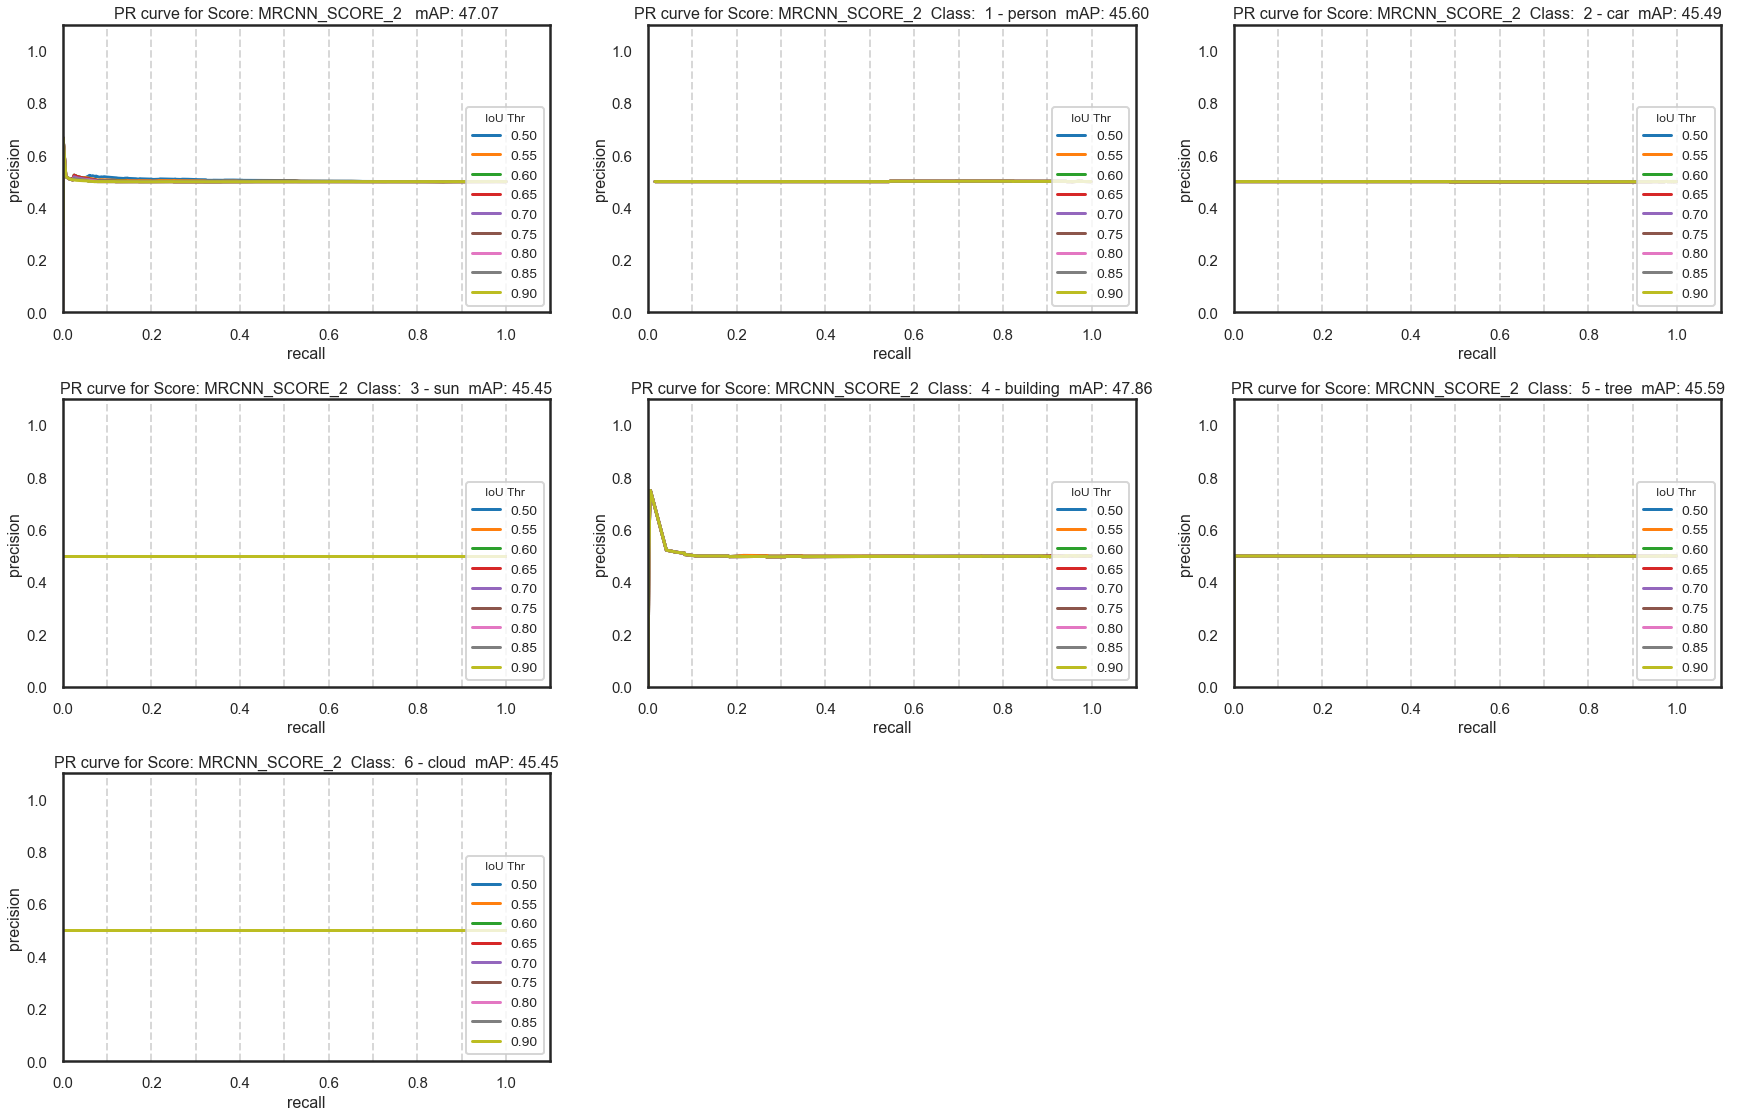

In [146]:
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_2', class_names = class_names )

### Plot mAP for `fcn_score_1` for different IoU thresholds

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_1                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.6864     0.6864     0.6856     0.6856     0.6856     0.6856     0.6856     0.6856     0.6856      %68.58 
  2 - car                         0.6158     0.6158     0.6158     0.6158     0.6158     0.6158     0.6158     0.6158     0.6158      %61.58 
  3 - sun                         0.4581     0.4581     0.4581     0.4581     0.458

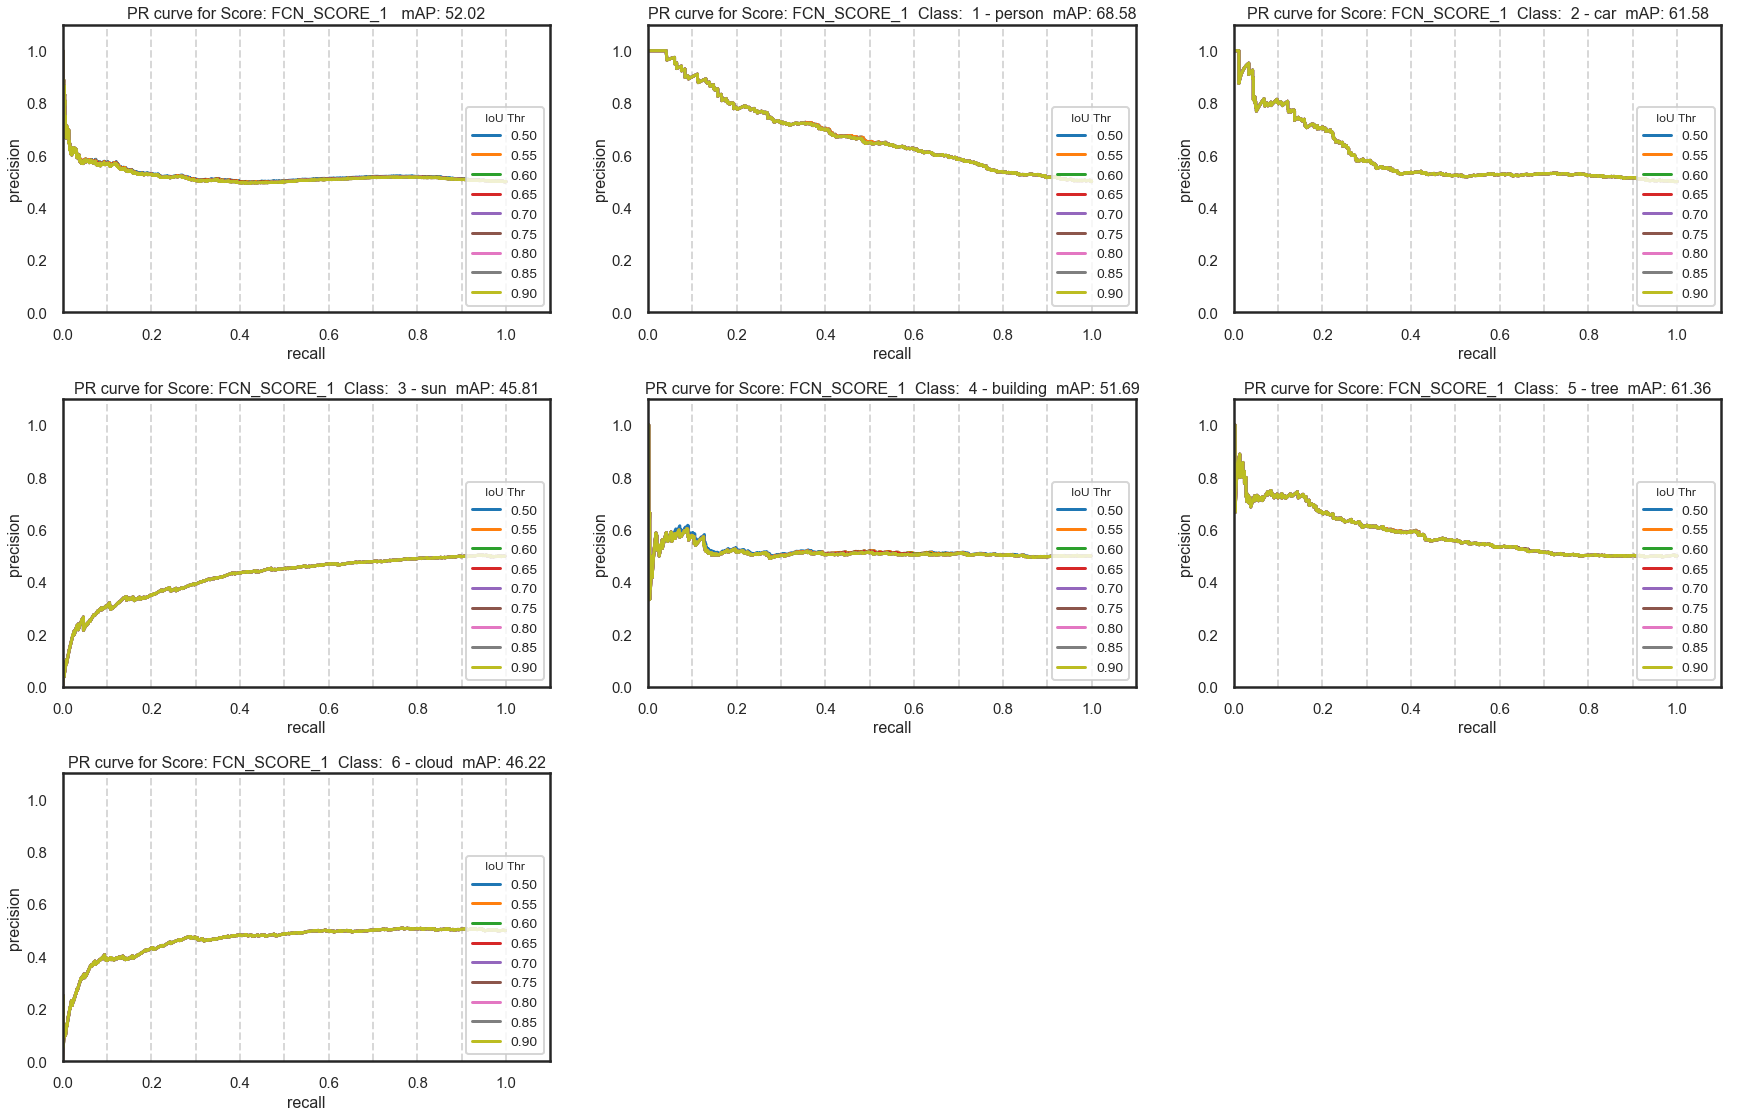

In [30]:
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_1', class_names = class_names )

### Plot mAP for `fcn_score_2` for different IoU thresholds

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_2                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.7241     0.7241     0.7241     0.7240     0.7240     0.7240     0.7240     0.7240     0.7240      %72.40 
  2 - car                         0.6568     0.6568     0.6568     0.6559     0.6559     0.6559     0.6559     0.6559     0.6559      %65.62 
  3 - sun                         0.4552     0.4552     0.4552     0.4552     0.455

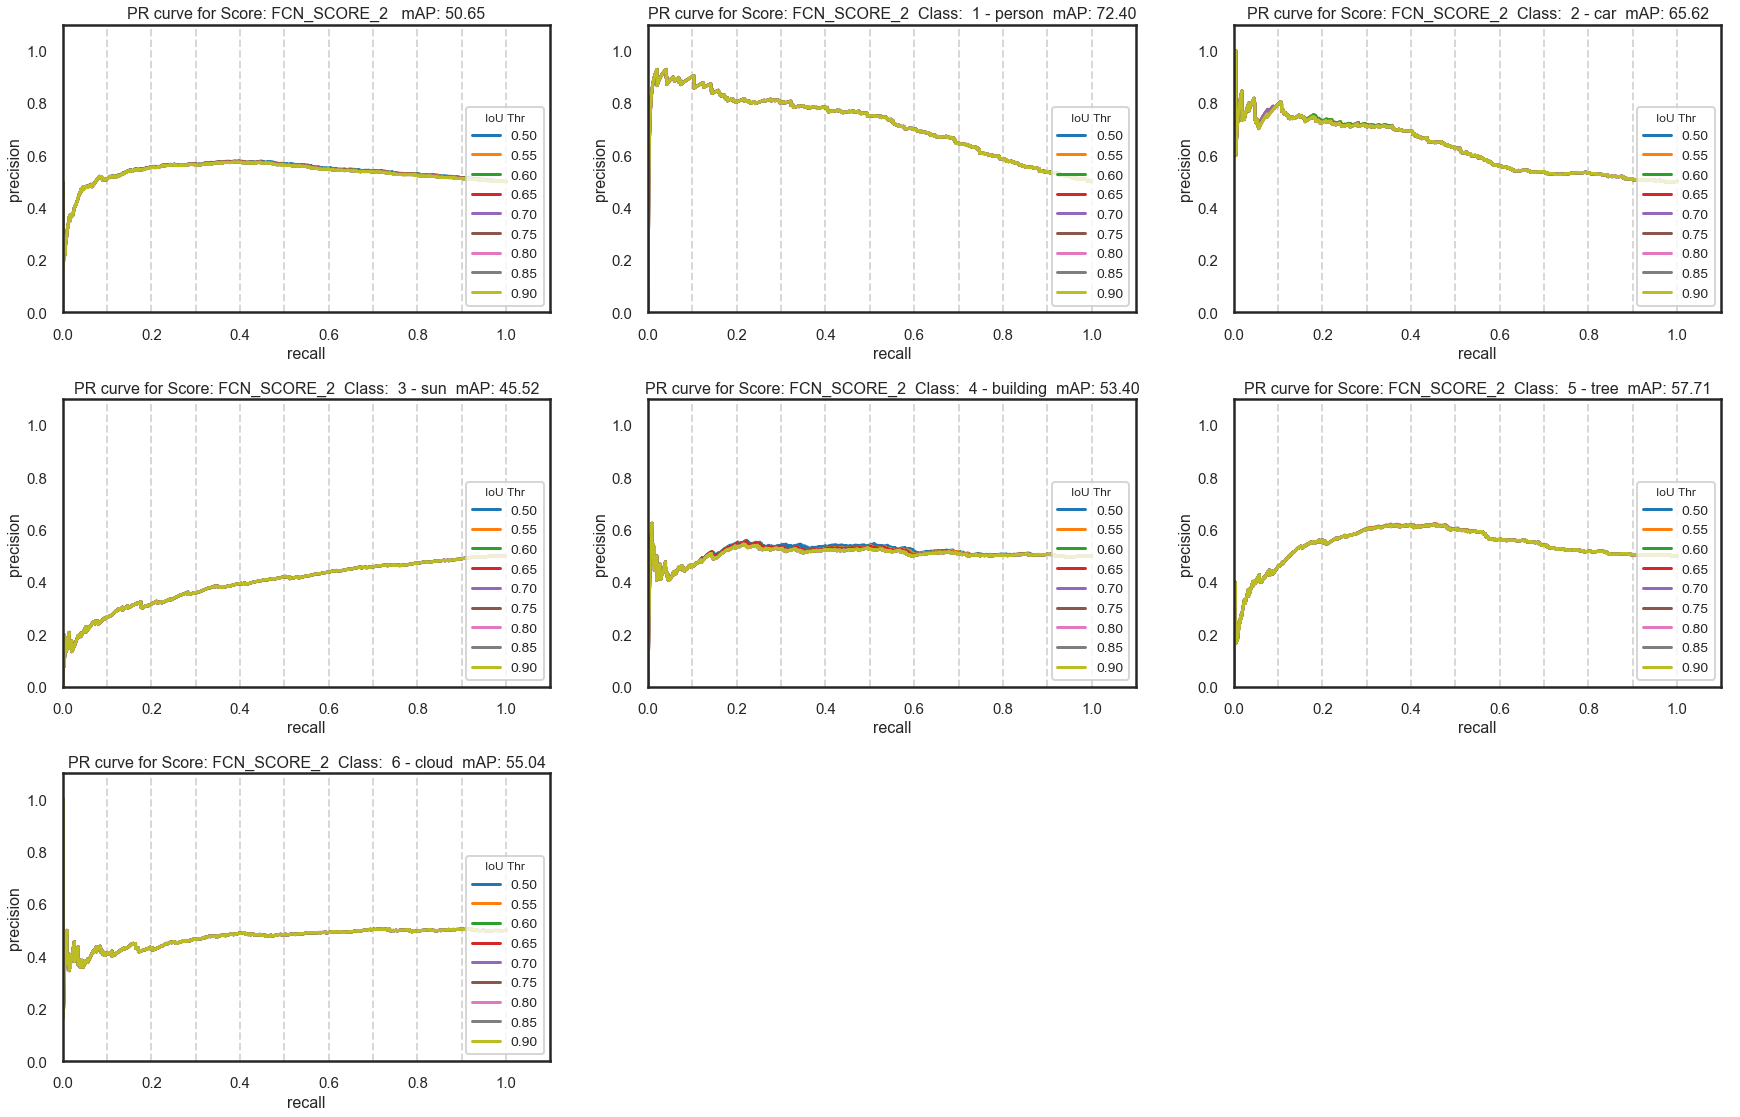

In [27]:
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_2', class_names = class_names )

## Indvidual classes - Plot mAP info for different scores (at a given IoU threshold)

### IoU = 0.5


                                                               AP @ IoU 0.50 Thresholds for Computed Scores                                                               

--------------------------------------------------------------------------------  scores  --------------------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_0       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.4682            0.4674            0.4656            0.4666            0.6149            0.6710            0.6383 
 2 - car                           0.4521            0.5223            0.4636            0.5091            0.5725            0.6171            0.6151 
 3 - sun                         

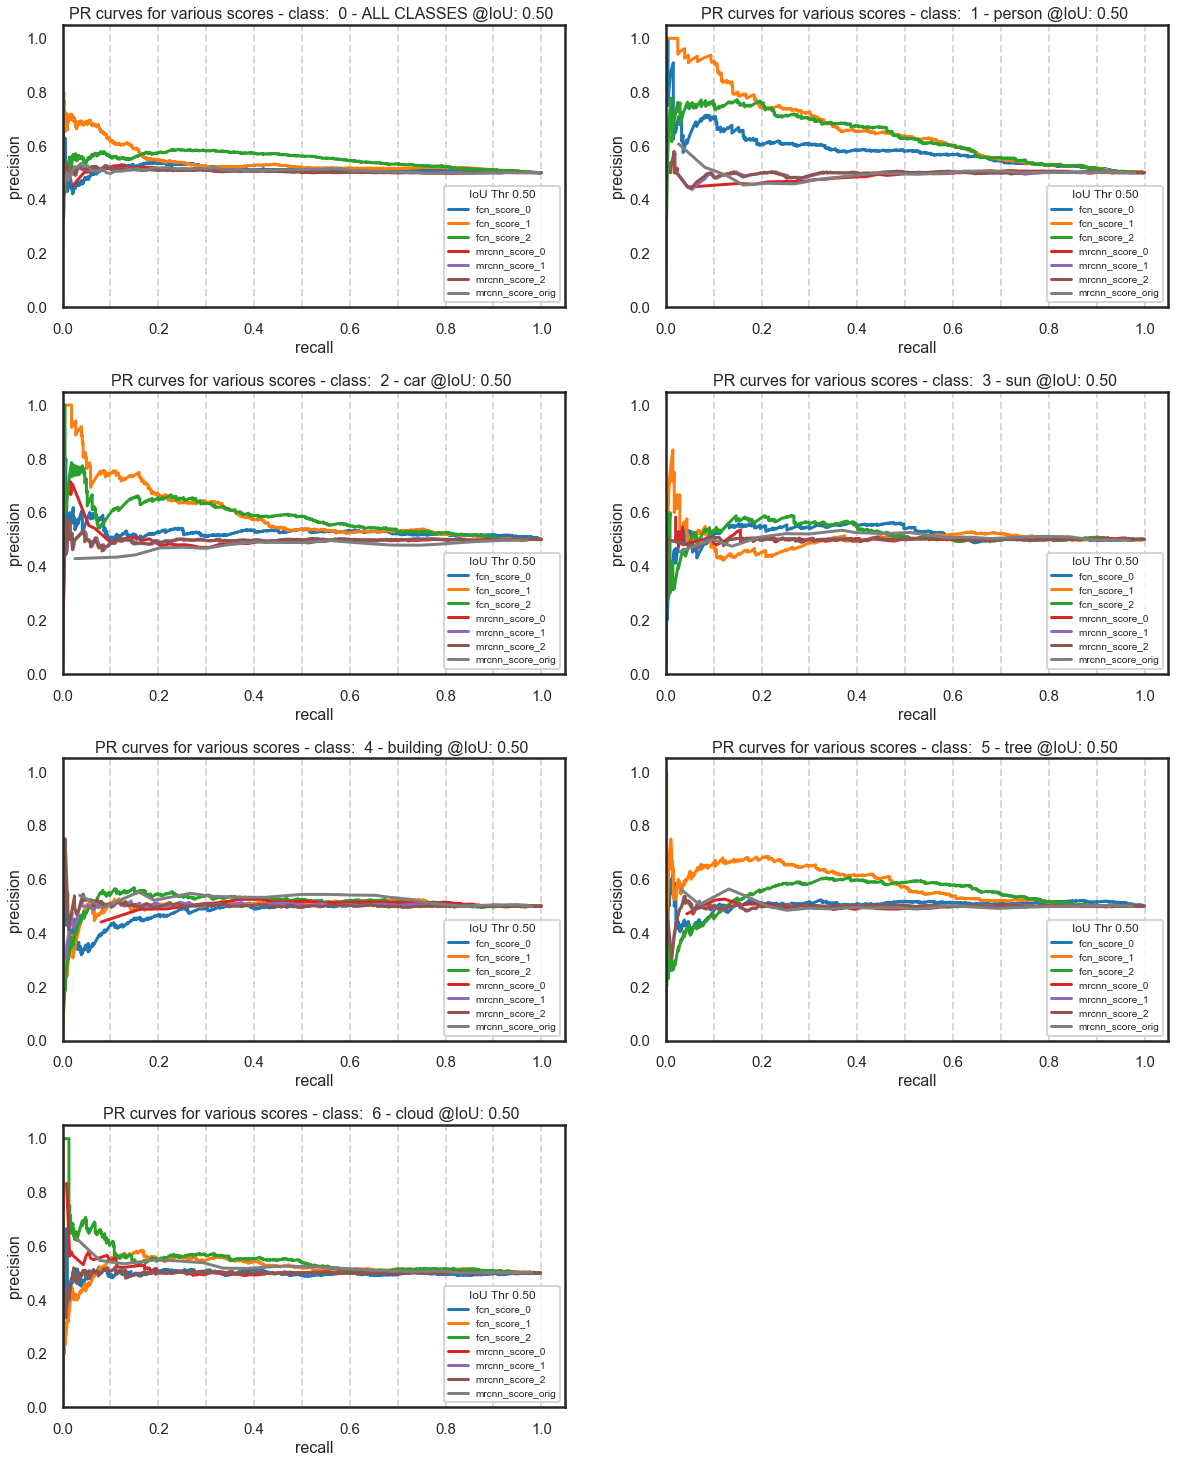

In [111]:
disp_classes = [0,1,2,3,4,5,6]  
disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = disp_classes, class_names= class_names, iou = 0.5)cv

col/rows:  2 4

                                                     AP @ IoU 0.50 Thresholds for Computed Scores                                                     

----------------------------------------------------------------------  scores  ----------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_0       fcn_score_1       fcn_score_2
------------------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.4815            0.4593            0.5101            0.5096            0.5101            0.0545            0.0606 
 2 - car                           0.4685            0.4704            0.5007            0.5030            0.5466            0.0909            0.0909 
 3 - sun                           0.5096            0.5235            0.5608 

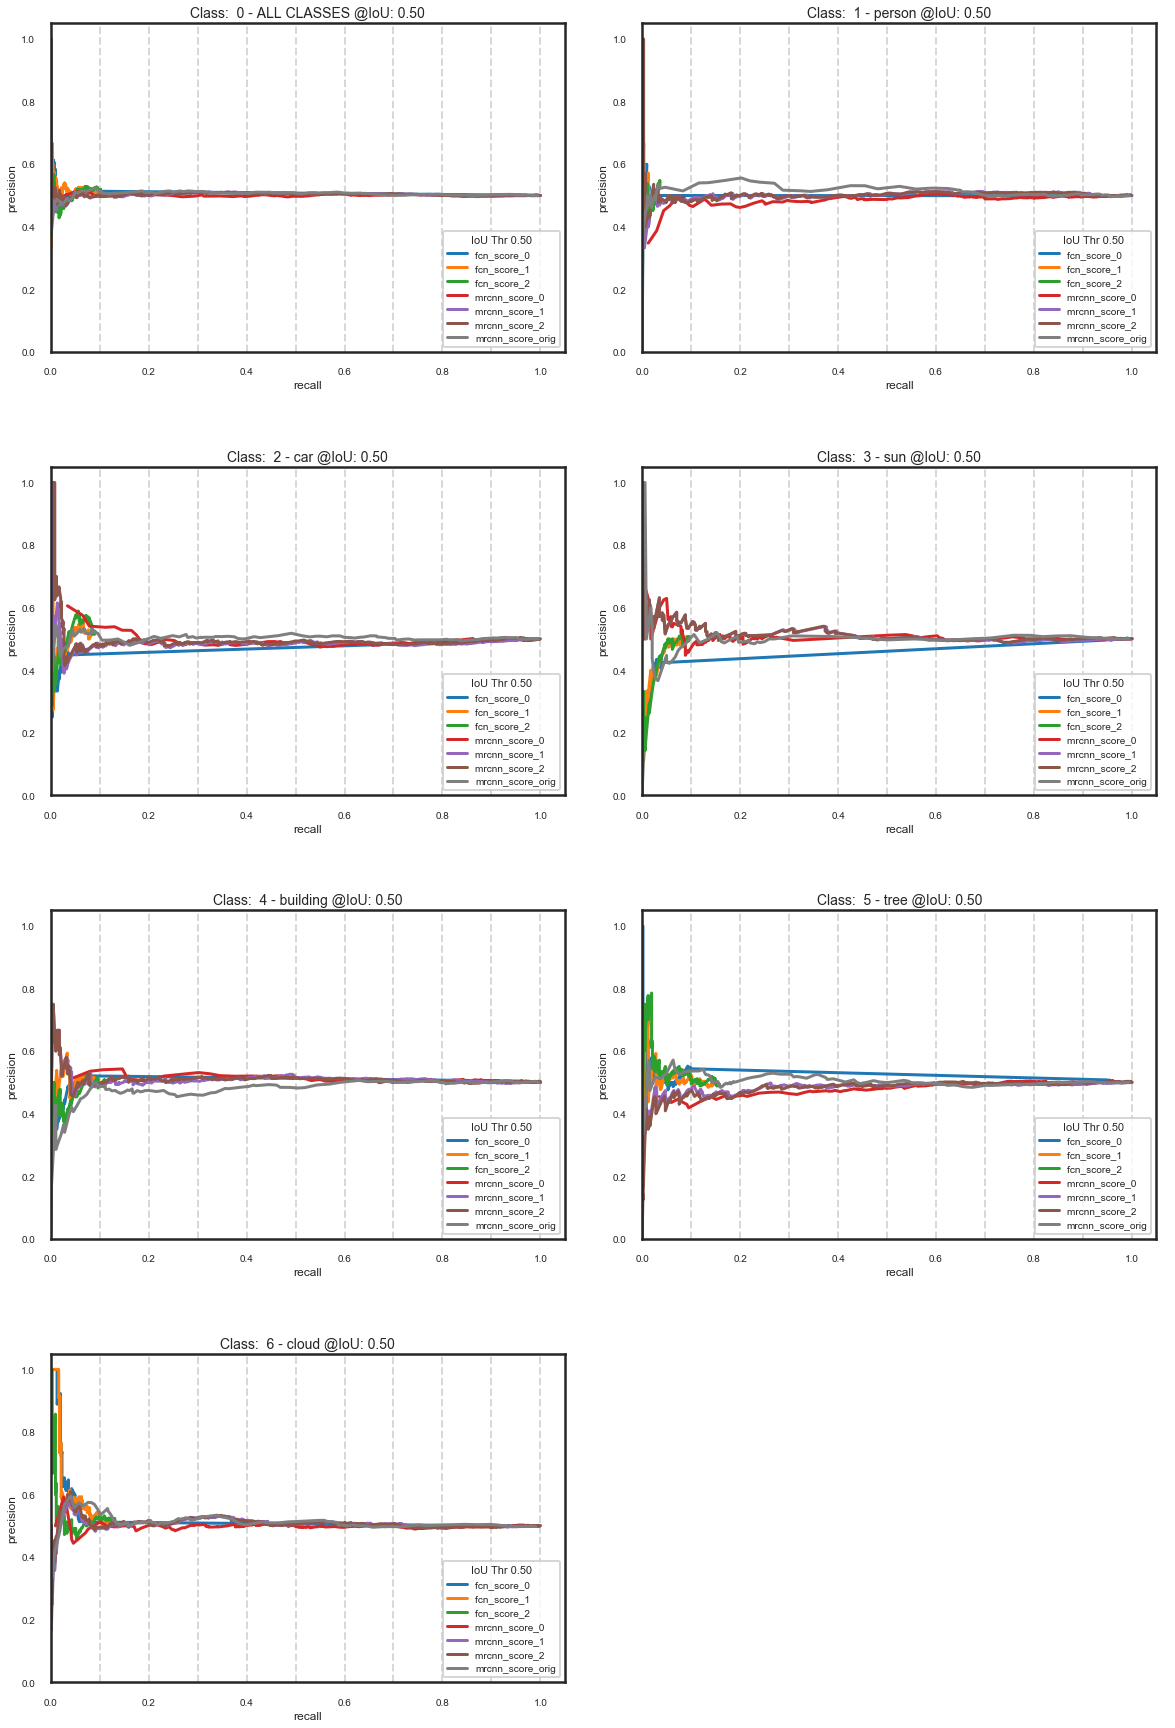

In [19]:
disp_classes = [0,1,2,3,4,5,6]  
disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = disp_classes, class_names= class_names, iou = 0.5)

### IoU = 0.75


                                                               AP @ IoU 0.75 Thresholds for Computed Scores                                                               

--------------------------------------------------------------------------------  scores  --------------------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_0       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.4676            0.4665            0.4656            0.4666            0.6139            0.6692            0.6365 
 2 - car                           0.4521            0.5223            0.4636            0.5091            0.5725            0.6171            0.6151 
 3 - sun                         

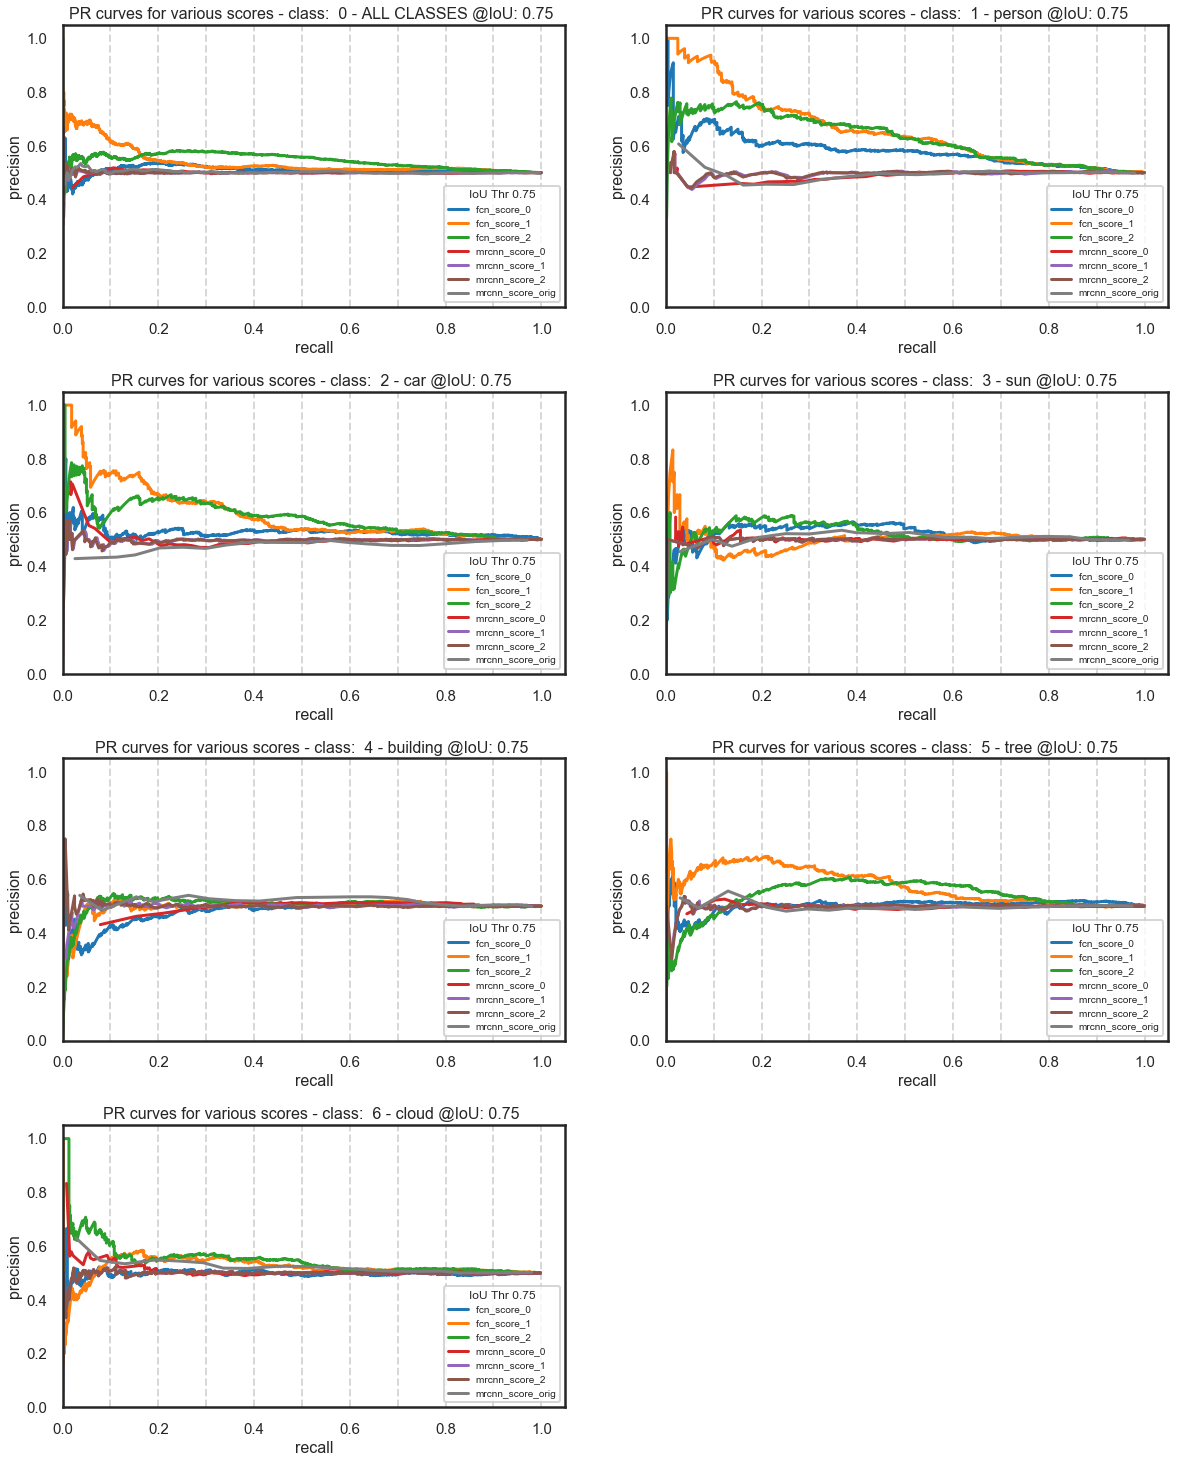

In [114]:
disp_classes = [0,1,2,3,4,5,6]  
disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = disp_classes, class_names= class_names, iou = 0.75)

### IoU = 0.9


                                                               AP @ IoU 0.90 Thresholds for Computed Scores                                                               

--------------------------------------------------------------------------------  scores  --------------------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_0       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.4676            0.4665            0.4656            0.4666            0.6139            0.6692            0.6365 
 2 - car                           0.4521            0.5223            0.4636            0.5091            0.5725            0.6171            0.6151 
 3 - sun                         

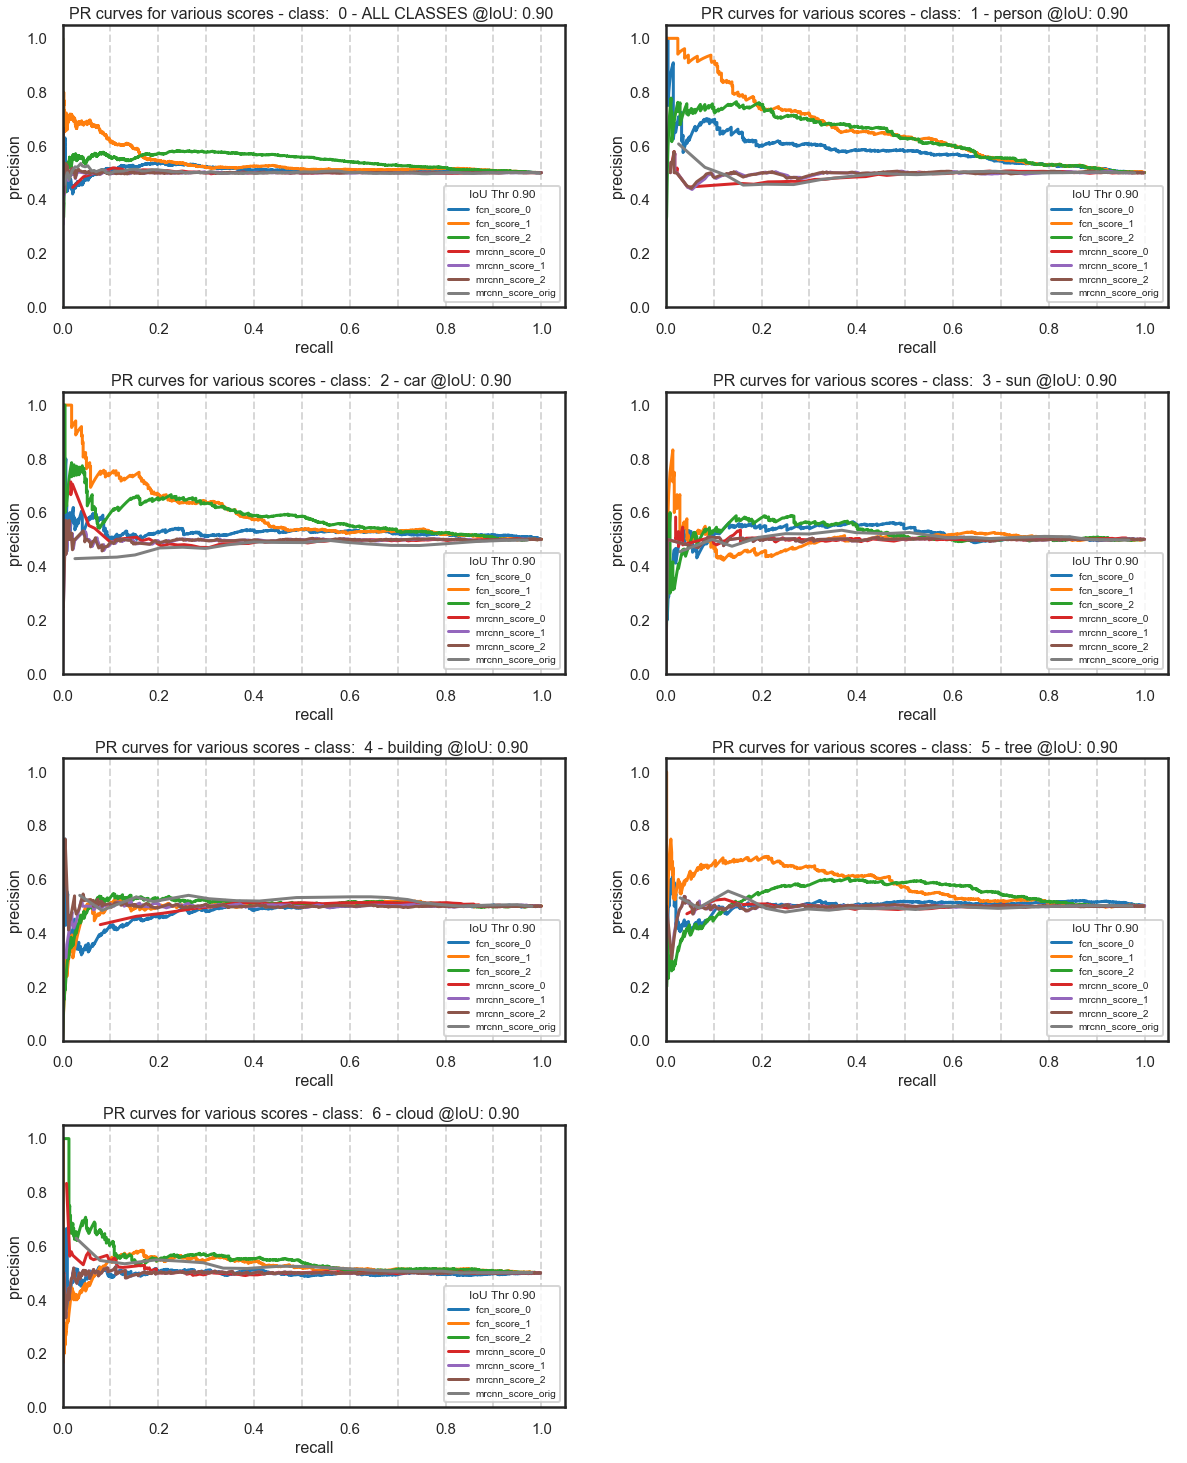

In [113]:
disp_classes = [0,1,2,3,4,5,6]  
disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = disp_classes, class_names= class_names, iou = 0.9)

In [166]:
objs_by_cls = np.zeros((7))
for img in sorted(gt_boxes.keys()):
#     print(img, gt_boxes[img]['class_ids'], np.bincount(gt_boxes[img]['class_ids'], minlength = 7))
    objs_by_cls += np.bincount(gt_boxes[img]['class_ids'], minlength = 7)
for i in class_ids:    
    print('{:3d} {:20s} {:6d}'.format(i, class_names[i], int(objs_by_cls[i])))    

  1 person                  637
  2 car                     582
  3 sun                     340
  4 building                559
  5 tree                    569
  6 cloud                   602


## Code from `calculate_mean_ap.py`

### `get_models_scores_map()`

In [ ]:
def get_model_scores_map(pred_boxes, score_key ):
    """Creates a dictionary of from model_scores to image ids.

    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'

    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)

    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for raw_score in val['scores']:
            score = round(raw_score,5)
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

In [ ]:
from copy import deepcopy
def get_avg_precision_at_iou(in_gt_boxes, in_pred_boxes, iou_thr=0.5, score_key = 'scores'):
    '''
    Calculates average precision at given IoU threshold.

    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.

    Returns:
        dict: avg precision as well as summary info about the PR curve

        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    '''
    gt_boxes = deepcopy(in_gt_boxes)
    pred_boxes = deepcopy(in_pred_boxes)
    model_scores_map    = get_model_scores_map(pred_boxes, score_key = score_key)
    sorted_model_scores = sorted(model_scores_map.keys())
    print('sorted_model_scores :' , sorted_model_scores)
    
    ## Sort the predicted boxes in ascending score order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        
        arg_sort = np.argsort(pred_boxes[img_id][score_key])
        print()
        print('image_id : ', img_id)
        print('--------------------------')
        print('scores:', pred_boxes[img_id]['scores'] )
        print(score_key, ':' ,pred_boxes[img_id][score_key] )
        print(pred_boxes[img_id]['boxes'] )
        print('argsort:' , arg_sort)
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id][score_key])[arg_sort].tolist()
        pred_boxes[img_id]['boxes']  = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()
        print('after')
        print('--------------------------')
        print('scores:', pred_boxes[img_id]['scores'] )
        print(score_key, ':' ,pred_boxes[img_id][score_key] )
        print(pred_boxes[img_id]['boxes'] )
        
        
    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions  = []
    recalls     = []
    model_thrs  = []
    img_results = {}
    
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        print('------------------------------------------------')
        print('ithr ', ithr, 'model_scr_thr', model_score_thr)
        print('------------------------------------------------')
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]['boxes']
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
#                     pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break
            print('Start Idx is ', start_idx)
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']  = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = cmap.get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)
            print('image_id : ', img_id)
            print('--------------------------')            
            pp.pprint(gt_boxes_img)
            pp.pprint(pred_boxes_pruned[img_id]['boxes'])
            pp.pprint(img_results[img_id])
            print()
        prec, rec = cmap.calc_precision_recall(img_results)
        print('precision:', prec, 'Recall:', rec)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    print('final precsions:', precisions)
    print('final recall   :', recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}


In [ ]:
class_ids = [1,2,3,4,5,6]
## build gt_boxes_class, pr_boxes_class which only containing info for each class 
gt_boxes_class = {}
pr_boxes_class = {}

for cls in class_ids :
    print('class id :', cls)
    a, b = filter_by_class(gt_boxes, pr_boxes, class_id= cls)
    gt_boxes_class[cls] = a
    pr_boxes_class[cls] = b
print(gt_boxes_class.keys())    
print(pr_boxes_class.keys())    
print(gt_boxes_class[1]['newshapes_00992'].keys())


In [ ]:
# msm = get_model_scores_map(pr_boxes_class[1], score_key = 'scores') 
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
# msm = get_model_scores_map(pr_boxes_class[1], score_key = 'scores') 
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

print()

print(pr_boxes['newshapes_00992']['class_ids'])
print(pr_boxes['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes['newshapes_00992']['scores'])
print(pr_boxes['newshapes_00992']['boxes'])

In [ ]:
data1 = get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'scores')
print(data1)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
data2 = get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'mrcnn_score_orig')
print(data2)

In [ ]:
print(data1)
print(data2)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
data3 = cmap.get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'mrcnn_score_orig')
print(data3)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
data4 = cmap.get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'scores')
print(data4)

In [ ]:
data5 = cmap.get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'mrcnn_score_norm')
print(data5)

In [ ]:
print(data3)
print(data4)
print(data5)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_norm'])
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])